# Purpose

2021-10-13: Run ad-hoc tests at subreddit level. Use this notebook to experiment & create a job/script that runs on Hydra to train multiple clustering algos in parallele and logs them to mlflow.


Ad-hoc test clustering algos at **subreddit-level.**

Use experimentation in this notebook to inform the class/functions that will log & repeat the process in mlflow.

# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import logging
from pathlib import Path

import numpy as np
import pandas as pd
import plotly
import seaborn as sns

import mlflow

import subclu
from subclu.utils import set_working_directory, get_project_subfolder
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl, 
    get_color_dict, base_colors_for_manual_labels,
    check_colors_used,
)
from subclu.data.data_loaders import LoadPosts, LoadSubreddits, create_sub_level_aggregates


# ===
# imports specific to this notebook
from collections import Counter
# import umap
# import openTSNE
# from openTSNE import TSNE

# import hdbscan

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize  # if we normalize the data, euclidean distance is approx of cosine

from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering

print_lib_versions([np, pd, plotly, sklearn, sns, subclu])

python		v 3.7.10
===
numpy		v: 1.19.5
pandas		v: 1.2.4
plotly		v: 4.14.3
sklearn		v: 0.24.1
seaborn		v: 0.11.1
subclu		v: 0.4.0


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Set sqlite database as MLflow URI

In [4]:
# use new class to initialize mlflow
mlf = MlflowLogger(tracking_uri='sqlite')
mlflow.get_tracking_uri()

'sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db'

## Get list of experiments with new function

In [5]:
mlf.list_experiment_meta(output_format='pandas')

,experiment_id,name,artifact_location,lifecycle_stage
0,0,Default,./mlruns/0,active
1,1,fse_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/1,active
2,2,fse_vectorize_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/2,active
3,3,subreddit_description_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/3,active
4,4,fse_vectorize_v1.1,gs://i18n-subreddit-clustering/mlflow/mlruns/4,active
5,5,use_multilingual_v0.1_test,gs://i18n-subreddit-clustering/mlflow/mlruns/5,active
6,6,use_multilingual_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/6,active
7,7,use_multilingual_v1_aggregates_test,gs://i18n-subreddit-clustering/mlflow/mlruns/7,active
8,8,use_multilingual_v1_aggregates,gs://i18n-subreddit-clustering/mlflow/mlruns/8,active
9,9,v0.3.2_use_multi_inference_test,gs://i18n-subreddit-clustering/mlflow/mlruns/9,active


## Get experiment IDs to use for clustering

There are two runs that completed and they both have the same parameters, so we should be able to use either one. For now, let's select:<br>
`0591fdae9b7d4da7ae3839767b8aab66`

In [6]:
%%time

df_mlf = mlf.search_all_runs(experiment_ids=[16])
df_mlf.shape

CPU times: user 78.7 ms, sys: 2.91 ms, total: 81.6 ms
Wall time: 80.4 ms


(13, 86)

In [7]:
mask_finished = df_mlf['status'] == 'FINISHED'
mask_df_similarity_complete = ~df_mlf['metrics.df_sub_level_agg_a_post_only_similarity-rows'].isnull()

df_mlf_clustering_candidates = df_mlf[mask_finished & mask_df_similarity_complete]
df_mlf_clustering_candidates.shape

(2, 86)

In [8]:
cols_with_multiple_vals = df_mlf_clustering_candidates.columns[df_mlf_clustering_candidates.nunique(dropna=False) > 1]

df_mlf_clustering_candidates[cols_with_multiple_vals]

,run_id,artifact_uri,start_time,end_time,metrics.memory_used_percent,metrics.memory_used,metrics.vectorizing_time_minutes,metrics.memory_free,params.f_log_file,params.memory_used,params.memory_used_percent,params.run_name,params.memory_free,tags.mlflow.runName
0,cbb12818e82345dda96928bfdab8b16b,gs://i18n-subreddit-clustering/mlflow/mlruns/16/cbb12818e82345dda96928bfdab8b16b/artifacts,2021-10-12 10:46:05.235000+00:00,2021-10-12 16:41:33.492000+00:00,0.181436,702999.0,355.468028,3465918.0,logs/AggregateEmbeddings/2021-10-12_10-46-05_agg_full_lc_false_pd-2021-10-12_104604.log,278514,0.07188136995649137,agg_full_lc_false_pd-2021-10-12_104604,3465918,agg_full_lc_false_pd-2021-10-12_104604
1,0591fdae9b7d4da7ae3839767b8aab66,gs://i18n-subreddit-clustering/mlflow/mlruns/16/0591fdae9b7d4da7ae3839767b8aab66/artifacts,2021-10-12 10:27:33.324000+00:00,2021-10-12 16:40:41.501000+00:00,0.181490,703208.0,373.134208,3681161.0,logs/AggregateEmbeddings/2021-10-12_10-27-33_agg_full_lc_false-2021-10-12_102732.log,64759,0.016713578624458464,agg_full_lc_false-2021-10-12_102732,3681161,agg_full_lc_false-2021-10-12_102732


# Set path for saving intermediary files

In [9]:
path_this_model = get_project_subfolder(
    f"data/models/clustering/manual_v040_{datetime.utcnow().strftime('%Y-%m-%d_%H_%M')}"
)
Path.mkdir(path_this_model, parents=True, exist_ok=True)
path_this_model

PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_v040_2021-10-13_19_23')

In [10]:
# path_this_model_prev_run = Path(
#     '/home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_2021-07-20_15_13'
# )
# path_this_model_prev_run

# Load vectors for selected run

In [16]:
run_uuid = '0591fdae9b7d4da7ae3839767b8aab66'

In [12]:
# %%time

# df_logs = mlf.read_run_artifact(
#     run_id=run_uuid,
#     artifact_file='2021-10-12_10-27-33_agg_full_lc_false-2021-10-12_102732.log',
#     read_function='pd_csv',
#     verbose=False,
#     read_csv_kwargs=dict(sep='|', quotechar='"', error_bad_lines=False)
# )
# df_logs.shape

In [13]:
# df_logs.head()

In [11]:
%%time
mlf.list_run_artifacts(
    run_id=run_uuid,
    verbose=False,
    only_top_level=True,
)

19:23:20 | INFO | " 4,777 <- Artifacts clean count"
19:23:20 | INFO | "    12 <- Artifacts & folders at TOP LEVEL clean count"


CPU times: user 942 ms, sys: 43 ms, total: 985 ms
Wall time: 1.62 s


['2021-10-12_10-27-33_agg_full_lc_false-2021-10-12_102732.log',
 'config',
 'd_logged_dfs_subfolders',
 'df_post_level_agg_c_post_comments_sub_desc',
 'df_sub_level_agg_a_post_only',
 'df_sub_level_agg_a_post_only_similarity',
 'df_sub_level_agg_a_post_only_similarity_pair',
 'df_sub_level_agg_a_post_only_similarity_top_pair',
 'df_sub_level_agg_c_post_comments_and_sub_desc',
 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity',
 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair',
 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity_top_pair']

In [19]:
%%time
d_dfs_mlflow = mlf.read_run_artifact(
    run_id=run_uuid,
    artifact_file='d_logged_dfs_subfolders/d_logged_dfs_subfolders.json',
    read_function='json',
    verbose=False,
)

19:25:04 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/16/0591fdae9b7d4da7ae3839767b8aab66/artifacts/d_logged_dfs_subfolders"
100%|###########################################| 2/2 [00:00<00:00, 7469.82it/s]

CPU times: user 691 ms, sys: 20.2 ms, total: 711 ms
Wall time: 877 ms


In [20]:
list(d_dfs_mlflow.keys())

['df_sub_level_agg_c_post_comments_and_sub_desc',
 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity',
 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair',
 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity_top_pair',
 'df_sub_level_agg_a_post_only',
 'df_sub_level_agg_a_post_only_similarity',
 'df_sub_level_agg_a_post_only_similarity_pair',
 'df_sub_level_agg_a_post_only_similarity_top_pair',
 'df_post_level_agg_c_post_comments_sub_desc']

In [21]:
f_embeddings_sub_level = 'df_sub_level_agg_c_post_comments_and_sub_desc'
f_embeddings_post_level = 'df_post_level_agg_c_post_comments_sub_desc'

f_sub_distance_c = 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity'

## Subreddit distance

This doesn't get used for clustering, but loading just to check on it

In [22]:
%%time

df_sub_distance = mlf.read_run_artifact(
    run_id=run_uuid,
    artifact_folder=f_sub_distance_c,
    read_function='pd_parquet',
    verbose=False,
)
print(df_sub_distance.shape)

19:25:25 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/16/0591fdae9b7d4da7ae3839767b8aab66/artifacts/df_sub_level_agg_c_post_comments_and_sub_desc_similarity"
100%|#######################################| 2171/2171 [00:46<00:00, 47.03it/s]
19:26:11 | INFO | "  Parquet files found:    47"
19:26:11 | INFO | "  Parquet files to use:    47"


(19192, 19192)
CPU times: user 4min 29s, sys: 3min 48s, total: 8min 18s
Wall time: 1min 37s


In [23]:
df_sub_distance.iloc[:9, :16]

,0sanitymemes,0xpolygon,1000lbsisters,100gecs,100kanojo,100thieves,100yearsago,1022,1050ti,10s,11foot8,11hr11min,1200australia,1200isfineiguessugh,1200isjerky,1200isplenty
subreddit_name,,,,,,,,,,,,,,,,
0sanitymemes,1.000000,0.323620,0.473484,0.541708,0.609227,0.641112,0.252647,0.283359,0.228379,0.324135,0.307192,0.242164,0.254572,0.411682,0.393787,0.266932
0xpolygon,0.323620,1.000000,0.157210,0.350132,0.258499,0.446187,0.196747,0.360179,0.291814,0.374882,0.295531,0.056076,0.215521,0.246148,0.269604,0.213691
1000lbsisters,0.473484,0.157210,1.000000,0.426692,0.493127,0.395050,0.192530,0.222239,0.046362,0.206581,0.293279,0.152359,0.237677,0.306629,0.314846,0.237828
100gecs,0.541708,0.350132,0.426692,1.000000,0.490515,0.595395,0.258179,0.398795,0.268588,0.391884,0.307137,0.211697,0.293759,0.381281,0.352718,0.318848
100kanojo,0.609227,0.258499,0.493127,0.490515,1.000000,0.522462,0.249595,0.191399,0.188991,0.271813,0.199841,0.211212,0.254396,0.347652,0.348710,0.270919
100thieves,0.641112,0.446187,0.395050,0.595395,0.522462,1.000000,0.321409,0.357185,0.333538,0.462633,0.325306,0.164549,0.297389,0.365696,0.357763,0.296177
100yearsago,0.252647,0.196747,0.192530,0.258179,0.249595,0.321409,1.000000,0.213160,0.074235,0.118345,0.326878,0.055648,0.214622,0.201936,0.203808,0.193652
1022,0.283359,0.360179,0.222239,0.398795,0.191399,0.357185,0.213160,1.000000,0.293922,0.497022,0.323100,0.090291,0.272050,0.258773,0.253875,0.249945
1050ti,0.228379,0.291814,0.046362,0.268588,0.188991,0.333538,0.074235,0.293922,1.000000,0.297552,0.176264,0.087839,0.160803,0.173626,0.162926,0.200787


## Subreddit-level


In [32]:
%%time

df_v_sub = mlf.read_run_artifact(
    run_id=run_uuid,
    artifact_folder=f_embeddings_sub_level,
    read_function='pd_parquet',
    verbose=False,
).drop(['index'], axis=1)

print(df_v_sub.shape)

19:31:45 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/16/0591fdae9b7d4da7ae3839767b8aab66/artifacts/df_sub_level_agg_c_post_comments_and_sub_desc"
100%|###################################| 2176/2176 [00:00<00:00, 886958.75it/s]
19:31:45 | INFO | "  Parquet files found:     3"
19:31:45 | INFO | "  Parquet files to use:     3"


(19192, 514)
CPU times: user 1.35 s, sys: 621 ms, total: 1.97 s
Wall time: 1.63 s


In [33]:
%%time
df_v_sub.iloc[:10, :18]

CPU times: user 627 µs, sys: 519 µs, total: 1.15 ms
Wall time: 971 µs


,subreddit_name,subreddit_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15
0,0sanitymemes,t5_2qlzfy,-0.015309,-0.000338,0.004237,-0.003082,-0.005160,0.039126,-0.007306,-0.001087,-0.040298,0.005632,0.014986,0.008301,0.009121,-0.001766,0.002140,0.004529
1,0xpolygon,t5_2qgijx,-0.032465,0.040708,-0.038430,-0.053849,-0.011010,0.011037,0.002698,0.001709,-0.006547,0.016146,0.026604,0.011281,0.032107,0.006964,-0.017149,0.030576
2,1000lbsisters,t5_2axvbl,-0.015282,-0.010422,0.003329,0.007292,0.000404,0.053924,0.018400,0.021107,-0.049664,0.021106,0.002576,0.033415,0.027110,-0.021416,0.001191,-0.011647
3,100gecs,t5_131dor,-0.004657,-0.008885,0.018894,0.004370,-0.031983,0.041073,0.014725,-0.007694,-0.048880,0.015949,-0.004769,0.001468,0.010662,-0.012723,0.011491,0.014758
4,100kanojo,t5_2asd3o,0.004579,0.022865,0.017590,-0.025580,0.004692,0.040058,0.003381,0.010890,-0.033801,0.039107,0.001168,0.034285,-0.017844,0.029286,-0.017823,-0.002958
5,100thieves,t5_3e98s,0.000797,-0.006705,0.013810,0.002443,0.006766,0.039071,0.005408,-0.008182,-0.034920,-0.006254,0.009869,-0.000474,0.010354,0.003454,0.004920,-0.001382
6,100yearsago,t5_2y3jq,0.002633,-0.006108,0.014209,-0.005926,0.030038,0.031586,-0.011541,-0.027743,0.054863,-0.005560,0.010610,-0.007959,-0.001142,0.002105,-0.032363,-0.009333
7,1022,t5_2v7cn,-0.024393,0.010842,0.001057,0.012960,-0.045104,0.046439,0.025671,0.000203,-0.049951,-0.005975,0.000300,0.008399,0.018779,0.004230,0.015567,0.012057
8,1050ti,t5_3aw8hb,-0.034112,0.022275,-0.005730,0.009530,-0.061777,-0.079557,0.004721,-0.037082,-0.012889,0.044403,0.059290,-0.042273,-0.021837,0.006665,0.036723,0.002950
9,10s,t5_2u7it,-0.015521,0.013037,0.003630,-0.013879,-0.043684,0.048049,0.013089,0.006329,-0.050186,0.013844,0.008129,-0.010067,0.049038,-0.014054,0.006099,0.007681


In [34]:
l_ix_sub = ['subreddit_name', 'subreddit_id',]
l_ix_post = ['subreddit_name', 'subreddit_id', 'post_id']
l_cols_embeddings = [c for c in df_v_sub.columns if c.startswith('embeddings_')]
print(len(l_cols_embeddings))

512


## Post-level

don't need post-level for clustering, so ignore for now

In [26]:
# %%time

# df_v_posts = mlf.read_run_artifact(
#     run_id=run_uuid,
#     artifact_folder=f_embeddings_post_level,
#     read_function='pd_parquet',
# )
# print(df_v_posts.shape)

In [27]:
# df_v_posts.head()

In [28]:
# df_v_posts.info()

# Merge posts & subs to single df

We can apply SVD & t-SNE at the same level, so it's easier/better to compare at different grains.

In [29]:
# df_v_all = pd.concat([df_v_sub, df_v_posts], axis=0, ignore_index=True)
# df_v_all.shape

In [30]:

# l_cols_embeddings_all = [c for c in df_v_all.columns if c.startswith('embeddings_')]

# print(len(l_cols_embeddings))

In [35]:
# df_v_all[l_cols_embeddings[0]].isnull().sum()

In [36]:
# df_v_all[df_v_all[l_cols_embeddings[0]].isnull()].head(20)

In [37]:
# df_v_all[l_cols_embeddings].head()

In [38]:
# df_v_all[l_cols_embeddings].tail()

# Load metadata

In [ ]:
TODO: load from CONFIG FILE!

In [40]:
col_manual_labels = 'manual_topic_and_rating'

l_cols_posts_load = [
    # IDs
    'subreddit_name',
    'subreddit_id',
    'post_id',
#     'user_id',
#     'thing_type',
    
    # Meta
    'submit_date',
#     'removed',
    'upvotes',
#     'successful',
#     'app_name',
    'combined_topic_and_rating',
    'post_type',
    'post_nsfw',
    'geolocation_country_code',
    
    # Language & text content
    'post_url',
    'language',
    'probability',
    'weighted_language',
    'weighted_language_probability',
    'text_len',
    'text_word_count',
    'post_url_for_embeddings',
    'text',
]


df_posts = LoadPosts(
    bucket_name='i18n-subreddit-clustering',
    folder_path='posts/de/2021-06-16',
    columns=l_cols_posts_load,
    col_new_manual_topic=col_manual_labels,
).read_and_apply_transformations()
df_posts.shape

In [41]:
# %%time

# df_subs = LoadSubreddits(
#     bucket_name='i18n-subreddit-clustering',
#     folder_path='subreddits/de/2021-06-16',
#     columns=None,
#     col_new_manual_topic=col_manual_labels,
# ).read_apply_transformations_and_merge_post_aggs(df_posts=df_posts)
# df_subs.shape

## Check for nulls

# Apply SVD

for 262k rows it took 8 seconds
```
(262854, 50)
CPU times: user 4min 13s, sys: 1min 32s, total: 5min 46s
Wall time: 8.22 s
```

In [39]:
# %%time

# posts_vec_svd = (
#     TruncatedSVD(n_components=50, random_state=42)
#     .fit_transform(df_v_all[l_cols_embeddings])
# )
# print(posts_vec_svd.shape)

## convert to df so we can keep track of index

In [20]:
%%time

df_vect_svd = pd.DataFrame(posts_vec_svd)
df_vect_svd = df_vect_svd.rename(columns={c: f"svd_{c}" for c in df_vect_svd.columns})

df_vect_svd = (
    df_v_all[l_ix_post]
    .merge(
        df_vect_svd,
        how='left',
        left_index=True,
        right_index=True,
    )
    .set_index(l_ix_post)
)

print(df_vect_svd.shape)

(262854, 50)
CPU times: user 530 ms, sys: 76.3 ms, total: 606 ms
Wall time: 605 ms


In [21]:
%%time

shape_ = df_vect_svd.shape
df_vect_svd.to_parquet(
    path_this_model / f'df_svd_posts_and_subs-{shape_[0]}_by_{shape_[1]}.parquet'
)

CPU times: user 867 ms, sys: 185 ms, total: 1.05 s
Wall time: 967 ms


In [22]:
df_vect_svd.head()

,,,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,svd_11,svd_12,svd_13,svd_14,svd_15,svd_16,svd_17,svd_18,svd_19,svd_20,svd_21,svd_22,svd_23,svd_24,svd_25,svd_26,svd_27,svd_28,svd_29,svd_30,svd_31,svd_32,svd_33,svd_34,svd_35,svd_36,svd_37,svd_38,svd_39,svd_40,svd_41,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49
subreddit_name,subreddit_id,post_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1fcnuernberg,t5_30jst,NaN,0.222840,0.000204,0.024081,0.063317,-0.132110,-0.055637,0.040146,-0.046460,-0.052776,-0.008773,-0.042769,0.070928,-0.034158,0.025777,-0.064311,0.003641,0.030935,-0.003533,-0.020378,0.024936,-0.035412,0.027751,-0.051836,0.027525,-0.022105,-0.009327,0.011011,0.008331,-0.001928,-0.012515,0.055163,0.063328,-0.014557,0.018073,0.031067,-0.004751,-0.013114,-0.009013,0.041001,-0.004795,-0.032076,-0.030410,-0.023992,-0.003504,-0.024986,0.043527,-0.014166,0.012205,-0.022387,-0.019383
3thedward,t5_2eeymn,NaN,0.255387,0.147757,0.032305,-0.061291,-0.118992,-0.000174,-0.009139,-0.058684,0.043216,0.009949,0.013206,0.005211,0.025003,-0.041626,-0.010192,0.017208,-0.004637,-0.000268,-0.033026,-0.007660,-0.020325,0.017145,0.003959,0.022870,0.039858,-0.015332,-0.018666,-0.025389,-0.011681,0.000225,0.008590,0.011976,0.022002,-0.003024,0.015800,-0.007602,-0.014605,0.006651,0.002072,0.019162,-0.027642,-0.031061,-0.010591,0.009320,0.030091,-0.021030,0.001044,-0.004239,0.037638,0.019334
600euro,t5_3caax,NaN,0.233825,0.036164,-0.006401,0.014257,-0.148316,0.001211,0.042717,0.000280,-0.027061,0.000389,0.006695,-0.051155,0.000947,-0.058265,-0.006256,-0.026925,0.010946,-0.017355,0.016914,0.001165,-0.043181,0.008907,0.030442,0.007596,-0.002369,-0.029640,-0.015655,-0.009348,-0.011743,0.001516,-0.024053,-0.020273,0.003483,0.005677,-0.000236,0.008566,0.000607,-0.008050,-0.010965,0.003653,0.002573,0.001821,0.021896,0.006452,0.021129,-0.007104,0.006212,0.004096,-0.007677,-0.007917
aachen,t5_2t4y2,NaN,0.219124,-0.043050,-0.050471,0.158570,-0.120792,-0.057563,-0.022799,0.029657,0.046299,0.026831,0.030359,0.018974,0.008621,0.002752,-0.013379,0.013019,-0.006006,-0.020961,-0.028905,-0.004260,0.022138,-0.028987,0.009586,-0.006960,-0.010025,0.006184,-0.026392,0.015233,-0.008033,-0.004515,-0.026837,0.005698,-0.003156,0.017153,-0.018319,-0.017741,-0.007431,0.004647,0.015259,0.002024,0.006584,0.007883,0.025302,0.008364,0.016183,0.014510,-0.011095,0.009870,-0.007056,-0.019834
aeiou,t5_2qmr6,NaN,0.276386,0.088939,0.015256,-0.029987,-0.155789,0.010343,0.001697,-0.013627,-0.002120,0.028648,-0.013168,-0.001978,0.022569,-0.042015,-0.006479,-0.035291,-0.002008,-0.010256,-0.014381,0.009433,-0.036223,-0.025497,0.026145,0.010167,0.010201,0.003460,-0.009011,-0.004831,0.023406,0.011332,-0.009656,0.022179,0.000257,0.006067,-0.005638,0.012306,-0.018230,-0.020892,0.018287,-0.006878,-0.023449,0.010020,0.002500,0.000668,-0.007141,0.005814,-0.003973,-0.005554,-0.003912,-0.006351


In [23]:
df_vect_svd.tail()

svd_0     svd_1     svd_2     svd_3     svd_4     svd_5     svd_6     svd_7     svd_8     svd_9    svd_10    svd_11    svd_12    svd_13    svd_14    svd_15    svd_16    svd_17    svd_18    svd_19    svd_20    svd_21    svd_22    svd_23    svd_24  \
subreddit_name     subreddit_id post_id                                                                                                                                                                                                                                                               
julesboringlifehot t5_35ivuz    t3_njts7x  0.163426 -0.003923 -0.061023 -0.123474 -0.031081 -0.097794 -0.044711 -0.119671 -0.057904 -0.046472 -0.102027  0.081628 -0.141420 -0.075969  0.032903  0.055067  0.133867 -0.233296  0.050129 -0.073582  0.016135 -0.111402  0.143120  0.092314 -0.006776   
                                t3_nju5c9  0.464914  0.030893 -0.037769 -0.011387  0.037560 -0.105888 -0.203250 -0.188919  0.165714 -0.105901  0.061408  0.207631 -0.180404 -0.086581  0.100301 -0.101623  0.075403 -0.027592  0.096137 -0.048058 -0.039554 -0.112191  0.008234  0.174592 -0.042756   
                                t3_njuin5  0.399133 -0.087055 -0.267788 -0.105893  0.096341 -0.098854 -0.122453  0.038833 -0.029296 -0.043533 -0.068612  0.061049  0.006719  0.058286  0.214584 -0.072580  0.020440 -0.052836  0.060111 -0.081780  0.090700  0.086156 -0.012391 -0.032981 -0.001360   
                                t3_njux8e  0.392761 -0.107330 -0.362585 -0.129785  0.146008 -0.171299 -0.112182  0.098037 -0.026398 -0.021915 -0.003406  0.110609  0.104719  0.020234 -0.049208  0.013021  0.060553  0.143711 -0.023443 -0.044771  0.049786  0.112820  0.050140 -0.055780  0.048863   
                                t3_njv999  0.397542 -0.040969  0.084619 -0.009956 -0.009300 -0.031628  0.002801 -0.038361  0.008080 -0.255870 -0.054738 -0.050197  0.074784 -0.083655 -0.007528 -0.002616 -0.058431  0.075130 -0.068382 -0.053536  0.006889 -0.097059  0.060603 -0.108478  0.087492   

                                             svd_25    svd_26    svd_27    svd_28    svd_29    svd_30    svd_31    svd_32    svd_33    svd_34    svd_35    svd_36    svd_37    svd_38    svd_39    svd_40    svd_41    svd_42    svd_43    svd_44    svd_45    svd_46    svd_47    svd_48    svd_49  
subreddit_name     subreddit_id post_id                                                                                                                                                                                                                                                              
julesboringlifehot t5_35ivuz    t3_njts7x  0.146898  0.176222  0.001274 -0.109513 -0.025089 -0.066446  0.199164  0.001497 -0.042383 -0.005247 -0.056429 -0.006604  0.029666  0.040979 -0.007542 -0.016162  0.000406  0.015318  0.059010  0.006261  0.092220  0.012056  0.039044  0.068977 -0.137410  
                                t3_nju5c9 -0.101813 -0.102635 -0.008655  0.078635  0.122736 -0.043855  0.107991 -0.069666 -0.065567 -0.016162 -0.130977  0.008425  0.058008  0.002532  0.120812  0.014123 -0.024665 -0.020919 -0.002717 -0.061739 -0.016529 -0.014934 -0.057876 -0.026168 -0.079370  
                                t3_njuin5  0.118180 -0.037475 -0.076526  0.004119  0.025199  0.118456  0.000474  0.014006 -0.049243  0.038114 -0.000449  0.011774 -0.013905  0.007583  0.023996 -0.013548 -0.046637  0.006349  0.068327  0.032552  0.052414  0.161258 -0.020872 -0.058229 -0.014634  
                                t3_njux8e -0.103438  0.176042 -0.036570 -0.011034 -0.070839  0.025785  0.011187  0.056145  0.047544 -0.063020  0.018422  0.021833 -0.014255  0.021576 -0.215822 -0.005292  0.082477  0.077834 -0.037370 -0.010204  0.072357  0.064374  0.028577 -0.024375  0.081679  
                                t3_njv999 -0.065034  0.066278  0.022908  0.116373 -0.058821 -0.132082  0.004065 -0.060626 -0.006513  0.000094  0.012870  0.041185  0.032946  0.017191  0.021497 -0.064557 -0.084788 -0.0

In [24]:
# df_vect_svd.iloc[:5, :7].to_numpy()

## Create 2 separate dfs & append metadata

- subreddit-level
- post-level

Best to keep things in two separate tables instead of going back and forth

### subreddit-level

In [60]:
# df_v_sub.head()

In [59]:
# df_vect_svd.head()

In [55]:
l_svd_full_cols = list(df_vect_svd.columns)

In [57]:
%%time

# use merge.right so that the metadata columns show up before SVD cols
df_subs_meta_and_svd = df_subs.merge(
    (
        # keep only the subreddits
        df_vect_svd[df_vect_svd.index.get_level_values('post_id').isnull()]
        .reset_index()
        [l_ix_sub + l_svd_full_cols]
    ),
    how='right',
    on=l_ix_sub,
)

df_subs_meta_and_svd.shape

CPU times: user 27 ms, sys: 1.3 ms, total: 28.3 ms
Wall time: 27.5 ms


(628, 93)

In [64]:
# df_subs_meta_and_svd.head()

In [63]:
%%time

shape_ = df_subs_meta_and_svd.shape
(
    df_subs_meta_and_svd
    #.astype({'post_nsfw': str})
    .to_parquet(
        # path_this_model / f'df_subs_meta_and_svd-{shape_[0]}_by_{shape_[1]}.parquet'
        # path_this_model_prev_run / f'df_subs_meta_and_svd-{shape_[0]}_by_{shape_[1]}.parquet'
    )
)

CPU times: user 20 ms, sys: 3.81 ms, total: 23.8 ms
Wall time: 22.1 ms


### post-level meta + svd

In [65]:
%%time

# use merge.right so that the metadata columns show up before SVD cols
df_posts_meta_and_svd = df_posts.merge(
    (
        # keep only the POSTS
        df_vect_svd[~df_vect_svd.index.get_level_values('post_id').isnull()]
        .reset_index()
        [l_ix_post + l_svd_full_cols]
    ),
    how='right',
    on=l_ix_post,
)

df_posts_meta_and_svd.shape

CPU times: user 968 ms, sys: 191 ms, total: 1.16 s
Wall time: 1.16 s


(262226, 72)

In [66]:
df_posts_meta_and_svd.head()

,subreddit_name,subreddit_id,post_id,submit_date,upvotes,combined_topic_and_rating,post_type,post_nsfw,geolocation_country_code,post_url,language,probability,weighted_language,weighted_language_probability,text_len,text_word_count,post_url_for_embeddings,text,weighted_language_top,post_type_agg3,post_type_agg2,manual_topic_and_rating,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,...,svd_20,svd_21,svd_22,svd_23,svd_24,svd_25,svd_26,svd_27,svd_28,svd_29,svd_30,svd_31,svd_32,svd_33,svd_34,svd_35,svd_36,svd_37,svd_38,svd_39,svd_40,svd_41,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49
0,1fcnuernberg,t5_30jst,t3_mjwbjc,2021-04-04,18,uncategorized,text,False,de,/r/1FCNuernberg/comments/mjwbjc/1_fc_nürnberg_sc_paderborn_07_21_11/,de,0.999995,de,1.145695,43,11,None,1. FC Nürnberg - SC Paderborn 07 2:1 (1:1),de,text,text,uncategorized,0.164979,0.027708,0.011357,0.088850,-0.118963,-0.083193,0.058674,-0.025479,...,0.002197,-0.028191,-0.061149,0.046622,-0.032495,0.011589,0.017807,-0.039668,0.051204,-0.011172,0.052575,0.111680,-0.013922,0.034699,0.027842,-0.020531,-0.013736,-0.064405,0.034722,-0.004113,-0.094052,-0.018429,-0.044279,0.020050,0.003752,0.081001,-0.060046,0.058255,-0.016019,0.002500
1,1fcnuernberg,t5_30jst,t3_mjwik7,2021-04-04,47,uncategorized,image,False,de,https://i.redd.it/ng48176vu5r61.png,de,0.999997,de,1.147996,20,4,i.redd.it ng48176vu5r61.png,Wer würde gewinnen?,de,image,image,uncategorized,0.290775,0.076220,0.003085,0.069772,-0.142911,0.216499,-0.131061,0.077955,...,-0.105780,0.055640,-0.124719,0.108773,-0.031945,0.018980,0.012562,-0.031696,-0.099113,-0.102852,0.078151,0.057303,0.055733,-0.027795,-0.006824,-0.008245,0.036646,0.079268,-0.014034,0.000859,-0.022723,-0.098025,-0.033977,0.000047,0.016063,0.061949,-0.006233,0.016778,-0.066399,0.067692
2,1fcnuernberg,t5_30jst,t3_mm8azo,2021-04-07,28,uncategorized,image,False,de,https://i.redd.it/0xr02x7ulsr61.jpg,de,0.999998,de,1.144098,59,10,i.redd.it 0xr02x7ulsr61.jpg,"Clubberer, wenn Gündogan Manchester City zum Sieg schießt:",de,image,image,uncategorized,0.212733,-0.035106,0.024589,0.051284,-0.171500,0.016093,0.121907,-0.169584,...,-0.049755,-0.000343,-0.108092,-0.068467,-0.067525,0.080401,-0.038081,0.082781,0.062684,0.027023,0.048090,0.030772,-0.014007,-0.024794,0.127562,-0.061145,-0.086639,-0.055611,0.058783,-0.025610,-0.005141,-0.073197,-0.099684,-0.084594,0.071610,0.046942,0.020306,-0.005746,-0.152800,-0.052711
3,1fcnuernberg,t5_30jst,t3_moqu14,2021-04-11,9,uncategorized,text,False,de,/r/1FCNuernberg/comments/moqu14/fc_würzburger_kickers_1_fc_nürnberg_11_01/,de,0.999997,de,1.136096,139,28,None,FC Würzburger Kickers - 1. FC Nürnberg 1:1 (0:1) [0:1 Shuranov 5'](https://streamja.com/6BZKV)\n\n[1:1 Dietz 79'](https://streamja.com/l21er),de,text,text,uncategorized,0.294502,-0.072486,0.113365,0.168651,-0.065302,-0.120250,0.024804,-0.021261,...,-0.020491,-0.008313,-0.112701,0.048067,-0.008202,-0.052210,0.052280,0.114416,0.057252,-0.026629,0.102569,0.114030,-0.027705,0.062739,0.045456,-0.067521,0.004326,-0.014137,0.057594,0.030605,-0.006231,0.057039,-0.014887,-0.031327,-0.009537,0.093540,-0.046808,0.065807,-0.043123,-0.049276
4,1fcnuernberg,t5_30jst,t3_mpibr7,2021-04-12,4,uncategorized,link,False,de,https://www.fcn.de/index.php?id=19217&tx_ttnews%5Btt_news%5D=33136&cHash=0602ee17c1f5efadbed49bf5150514c8,de,0.999996,de,1.142295,77,12,fcn.de index.php id=19217&tx ttnews%5Btt news%5D=33136&cHash=0602ee17c1f5efadbed49bf5150514c8,1. FC Nürnberg: Zweitliga-Spiel abgesetzt: Heimspiel gegen Kiel wird verlegt,de,link,other,uncategorized,0.219580,-0.056354,0.007379,0.105313,-0.123206,-0.068815,0.076095,-0.109889,...,-0.041893,0.045834,-0.149769,-0.001459,-0.033519,-0.008614,-0.042946,0.004909,-0.008248,0.009195,0.096201,0.127665,0.003705,0.030418,0.029867,0.052259,0.023280,0.010833,0.030480,-0.019899,-0.093790,-0.065495,-0.015838,-0.000043,-0.019840,-0.018711,0.002349,0.038524,-0.047009,-0.013738


In [68]:
%%time

shape_ = df_posts_meta_and_svd.shape
(
    df_posts_meta_and_svd
    .astype({'post_nsfw': str})
    .to_parquet(
        path_this_model / f'df_posts_meta_and_svd-{shape_[0]}_by_{shape_[1]}.parquet'
        # path_this_model_prev_run / f'df_posts_meta_and_svd-{shape_[0]}_by_{shape_[1]}.parquet'
    )
)

CPU times: user 1.68 s, sys: 463 ms, total: 2.14 s
Wall time: 2.02 s


# Run clustrering

## HDBSCAN

If we use leaf, we get more groups, but then we get a huge number of un-grouped subreddits (over 400)

In [487]:
%%time

# cluster 3, samples = 2 seems more balanced?
cluster = hdbscan.HDBSCAN(
    min_cluster_size=3,
    min_samples=3,
    metric='euclidean',
    # cluster_selection_method='leaf',
)

cluster.fit(df_v_sub[l_cols_embeddings])
len(set(cluster.labels_))

CPU times: user 387 ms, sys: 2.41 ms, total: 389 ms
Wall time: 387 ms


7

In [488]:
(
    pd.DataFrame([Counter(cluster.labels_)], index=['subreddit_count'])
    .T
    .rename_axis(index='cluster_id')
    .sort_values(by=['subreddit_count'], ascending=False)
)

,subreddit_count
cluster_id,
3,451
-1,153
4,11
1,4
0,3
2,3
5,3


<AxesSubplot:ylabel='$\\lambda$ value'>

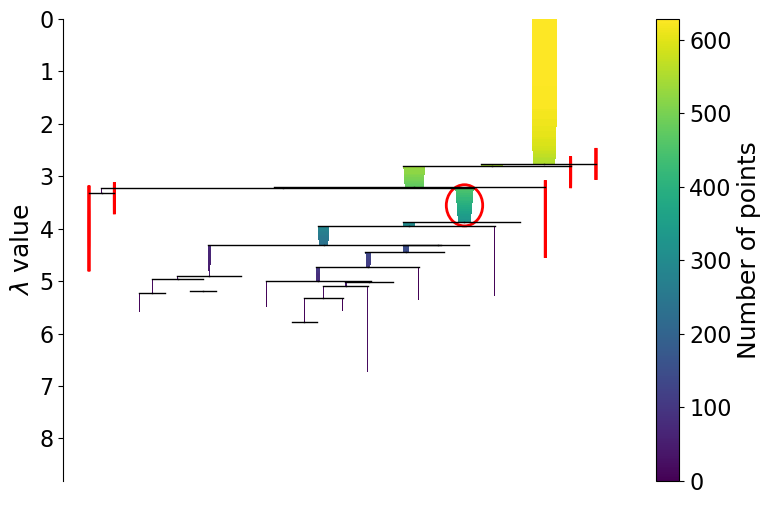

In [489]:
cluster.condensed_tree_.plot(select_clusters=True)

NetworkX get errors, looks like there's a conflict with one of our installed versions... sigh

- https://stackoverflow.com/questions/66922359/unexpected-error-while-drawing-networkx-graph
- https://github.com/microsoft/CyberBattleSim/issues/4

In [491]:
# import networkx as nx

# g = cluster.condensed_tree_.to_networkx()
# g

# nx.draw(g)

In [492]:
# df_cluster_groups = cluster.condensed_tree_.to_pandas()
# # df_cluster_groups['cluster_id'] = cluster.labels_
# # df_cluster_groups['cluster_id'] = df_cluster_groups['cluster_id'].astype(str)

# df_cluster_groups.shape

In [239]:
# df_cluster_groups.tail()

In [240]:
# counts_describe(df_cluster_groups)

In [151]:
# df_cluster_groups['child'].describe()

In [493]:
# counts_describe(df_cluster_groups[df_cluster_groups['child'] > 628])

In [494]:
# counts_describe(df_cluster_groups[df_cluster_groups['child'] < 628])

## Use pre-computed cosine distances

For some reason, couldn't get cosine to work with hdbscan. 

- I also tried the pre-computed square distance matrix, but that returns an unexpected number of clusters...

- So let's try normalizing and then running the normal HDBSCAN process.

See: 
- https://github.com/scikit-learn-contrib/hdbscan/issues/69

In [499]:
%%time

cluster_pre_computed = hdbscan.HDBSCAN(
    metric='precomputed', 
    min_cluster_size=3,
    min_samples=3,
    cluster_selection_method='leaf',
)
cluster_pre_computed.fit(df_sub_distance.to_numpy())

set(cluster_pre_computed.labels_)

CPU times: user 27.7 ms, sys: 0 ns, total: 27.7 ms
Wall time: 26.8 ms


{-1, 0, 1}

In [500]:
(
    pd.DataFrame([Counter(cluster_pre_computed.labels_)], index=['subreddit_count'])
    .T
    .rename_axis(index='cluster_id')
    .sort_values(by=['subreddit_count'], ascending=False)
)

,subreddit_count
cluster_id,
-1,621
1,4
0,3


In [502]:
# cluster_pre_computed.condensed_tree_.plot(select_clusters=True)

## HDBSCAN with cosine (normalize + l2)

In [533]:
%%time

# we get 482 subs as -1:
#     min_cluster_size=6,
#     min_samples=4,

# 419 subs as -1 (unclassified) with:
#     min_cluster_size=6,
#     min_samples=2,

# 408 subs as -1 (unclassified) with:
#     min_cluster_size=5,
#     min_samples=2,


cluster_cosine = hdbscan.HDBSCAN(
    metric='euclidean', 
    min_cluster_size=5,
    min_samples=2,
    cluster_selection_method='leaf',  # eom, leaf
    # cluster_selection_epsilon=0.,
    prediction_data=True,
)

cluster_cosine.fit(normalize(df_v_sub[l_cols_embeddings], norm='l2'))

len(set(cluster_cosine.labels_))

CPU times: user 668 ms, sys: 2.62 ms, total: 671 ms
Wall time: 669 ms


20

In [534]:
(
    pd.DataFrame([Counter(cluster_cosine.labels_)], index=['subreddit_count'])
    .T
    .rename_axis(index='cluster_id')
    .sort_values(by=['subreddit_count'], ascending=False)
)

,subreddit_count
cluster_id,
-1,408
15,31
13,23
14,20
11,18
16,16
5,15
0,12
18,11


In [535]:
soft_clusters_cosine = hdbscan.all_points_membership_vectors(cluster_cosine)
(
    pd.DataFrame([Counter(np.argmax(soft_clusters_cosine, axis=1))], index=['subreddit_count'])
    .T
    .rename_axis(index='cluster_id')
    .sort_values(by=['subreddit_count'], ascending=False)
)

,subreddit_count
cluster_id,
16,109
12,56
15,53
13,49
14,43
8,40
10,39
11,28
7,26


<AxesSubplot:ylabel='$\\lambda$ value'>

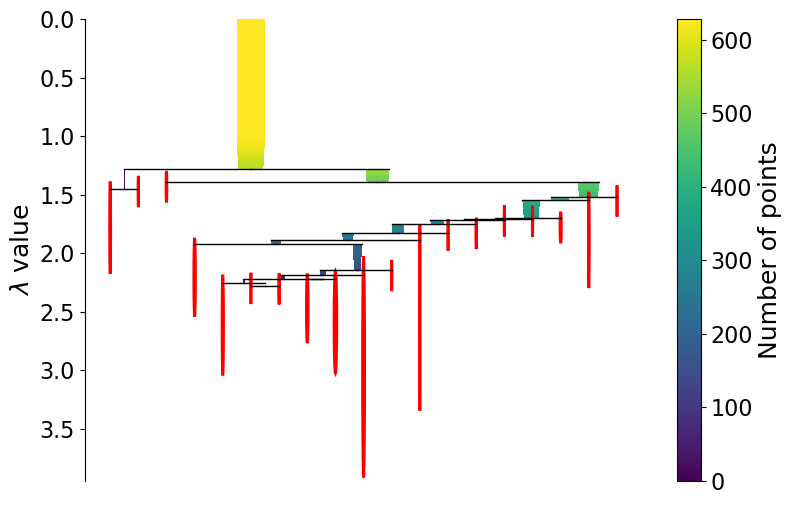

In [536]:
cluster_cosine.condensed_tree_.plot(select_clusters=True)

## We _could_ manually split our own clusters given the parent/child relationship df

In [372]:
df_cluster_groups_cosine = cluster_cosine.condensed_tree_.to_pandas()
# df_cluster_groups['cluster_id'] = cluster.labels_
# df_cluster_groups['cluster_id'] = df_cluster_groups['cluster_id'].astype(str)

df_cluster_groups_cosine.shape

(648, 4)

In [373]:
df_cluster_groups_cosine.head()

,parent,child,lambda_val,child_size
0,628,545,0.906748,1
1,628,376,0.909361,1
2,628,312,0.910546,1
3,628,74,0.947910,1
4,628,492,0.955193,1


In [374]:
df_cluster_groups.head()

,parent,child,lambda_val,child_size
0,628,376,1.168208,1
1,628,545,1.190091,1
2,628,492,1.200526,1
3,628,458,1.278373,1
4,628,86,1.514146,1


In [375]:
# value_counts_and_pcts(df_cluster_groups['parent'])

In [376]:
# value_counts_and_pcts(df_cluster_groups['child_size'])

## K-means clustering

For subreddit-level it's less than 1 second.

For post-level it takes around `2 minutes`

```
kmeans_20_all = KMeans(n_clusters=20, random_state=42)
kmeans_20_all.fit(df_v_all[l_cols_embeddings])

> CPU times: user 59min 43s, sys: 14min 48s, total: 1h 14min 31s
> Wall time: 2min 1s
```

In [404]:
%%time

kmeans_8 = KMeans(n_clusters=8, random_state=42)
kmeans_8.fit(df_v_sub[l_cols_embeddings])

print(len(set(kmeans_8.labels_)))

8
CPU times: user 26.2 s, sys: 29.2 s, total: 55.4 s
Wall time: 908 ms


In [444]:
%%time

kmeans_15 = KMeans(n_clusters=15, random_state=42)
kmeans_15.fit(df_v_sub[l_cols_embeddings])

print(len(set(kmeans_15.labels_)))

15
CPU times: user 24.4 s, sys: 27 s, total: 51.4 s
Wall time: 841 ms


In [537]:
%%time

kmeans_20 = KMeans(n_clusters=20, random_state=42)
kmeans_20.fit(df_v_sub[l_cols_embeddings])

print(len(set(kmeans_20.labels_)))

20
CPU times: user 39.8 s, sys: 46.1 s, total: 1min 25s
Wall time: 1.39 s


In [553]:
%%time

kmeans_20_all = KMeans(n_clusters=20, random_state=42)
kmeans_20_all.fit(df_v_all[l_cols_embeddings])

print(len(set(kmeans_20_all.labels_)))

20
CPU times: user 59min 43s, sys: 14min 48s, total: 1h 14min 31s
Wall time: 2min 1s


In [407]:
(
    pd.DataFrame([Counter(kmeans_8.labels_)], index=['subreddit_count'])
    .T
    .rename_axis(index='cluster_id')
    .sort_values(by=['subreddit_count'], ascending=False)
)

,subreddit_count
cluster_id,
6,117
2,109
1,99
7,88
4,84
5,55
0,42
3,34


In [445]:
(
    pd.DataFrame([Counter(kmeans_15.labels_)], index=['subreddit_count'])
    .T
    .rename_axis(index='cluster_id')
    .sort_values(by=['subreddit_count'], ascending=False)
)

,subreddit_count
cluster_id,
8,99
13,70
2,69
0,53
3,49
4,48
6,42
1,40
7,39


In [558]:
(
    pd.DataFrame([Counter(kmeans_20_all.labels_)], index=['post_count'])
    .T
    .rename_axis(index='cluster_id')
    .sort_values(by=['post_count'], ascending=False)
)

,post_count
cluster_id,
13,29350
0,28215
7,23958
12,23506
15,21761
17,16761
5,14681
16,11171
18,10612


## DB Scan

In [539]:
%%time

dbscan_euclidean = DBSCAN(
    metric='euclidean', 
    eps=0.3,
    min_samples=3,
    # leaf_size=50,
    n_jobs=-1,
)

dbscan_euclidean.fit(df_v_sub[l_cols_embeddings])

len(set(dbscan_euclidean.labels_))

CPU times: user 3.34 s, sys: 3.57 s, total: 6.91 s
Wall time: 144 ms


6

In [540]:
(
    pd.DataFrame([Counter(dbscan_euclidean.labels_)], index=['subreddit_count'])
    .T
    .rename_axis(index='cluster_id')
    .sort_values(by=['subreddit_count'], ascending=False)
)

,subreddit_count
cluster_id,
1,462
-1,143
0,12
4,5
2,3
3,3


## Hierarchical clustering

Do it for subreddit-level only for now.

Linkage algos to try:
- Ward
    - euclidean
    - cosine (normalize vectors before applying euclidean)
- Average linkange
- Complete
- Single (ignore for now, it's brittle)

In [609]:
%%time
agg_cluster_ward_25 = AgglomerativeClustering(
    n_clusters=25,
    affinity='euclidean',
    linkage='ward'
)


agg_cluster_ward_25.fit(df_v_sub[l_cols_embeddings])

len(set(agg_cluster_ward_25.labels_))

CPU times: user 72.7 ms, sys: 99 µs, total: 72.8 ms
Wall time: 71.5 ms


25

In [610]:
(
    pd.DataFrame([Counter(agg_cluster_ward_25.labels_)], index=['subreddit_count'])
    .T
    .rename_axis(index='cluster_id')
    .sort_values(by=['subreddit_count'], ascending=False)
)

,subreddit_count
cluster_id,
6,83
1,81
9,66
12,49
19,46
23,36
0,32
3,27
10,27


### Ward 35

In [636]:
%%time
agg_cluster_ward_35 = AgglomerativeClustering(
    n_clusters=35,
    affinity='euclidean',
    linkage='ward'
)


agg_cluster_ward_35.fit(df_v_sub[l_cols_embeddings])

len(set(agg_cluster_ward_35.labels_))

CPU times: user 75 ms, sys: 1.08 ms, total: 76.1 ms
Wall time: 74.6 ms


35

In [637]:
(
    pd.DataFrame([Counter(agg_cluster_ward_35.labels_)], index=['subreddit_count'])
    .T
    .rename_axis(index='cluster_id')
    .sort_values(by=['subreddit_count'], ascending=False)
)

,subreddit_count
cluster_id,
0,66
9,52
25,49
19,46
28,42
...,...
32,1
30,1
20,1


### Ward 35 + cosine

In [641]:
%%time
agg_cluster_ward_cosine_35 = AgglomerativeClustering(
    n_clusters=35,
    affinity='euclidean',
    linkage='ward'
)

agg_cluster_ward_cosine_35.fit(normalize(df_v_sub[l_cols_embeddings], norm='l2'))
print(len(set(agg_cluster_ward_cosine_35.labels_)))

(
    pd.DataFrame([Counter(agg_cluster_ward_cosine_35.labels_)], index=['subreddit_count'])
    .T
    .rename_axis(index='cluster_id')
    .sort_values(by=['subreddit_count'], ascending=False)
)

35
CPU times: user 70.7 ms, sys: 6.42 ms, total: 77.2 ms
Wall time: 76.1 ms


,subreddit_count
cluster_id,
4,66
6,47
32,41
22,39
12,34
...,...
8,6
20,4
34,4


### Average linkage

In [642]:
%%time
agg_cluster_avg_cosine_35 = AgglomerativeClustering(
    n_clusters=35,
    affinity='cosine',
    linkage='average'
)

# agg_cluster_avg_cosine_35.fit(normalize(df_v_sub[l_cols_embeddings], norm='l2'))
agg_cluster_avg_cosine_35.fit(df_v_sub[l_cols_embeddings])
print(len(set(agg_cluster_avg_cosine_35.labels_)))

(
    pd.DataFrame([Counter(agg_cluster_avg_cosine_35.labels_)], index=['subreddit_count'])
    .T
    .rename_axis(index='cluster_id')
    .sort_values(by=['subreddit_count'], ascending=False)
)

35
CPU times: user 75.6 ms, sys: 0 ns, total: 75.6 ms
Wall time: 74 ms


,subreddit_count
cluster_id,
1,378
0,92
10,31
4,30
11,22
...,...
17,1
31,1
21,1


### Complete linkage

In [643]:
%%time
agg_cluster_complete_cosine_35 = AgglomerativeClustering(
    n_clusters=35,
    affinity='cosine',
    linkage='complete'
)

# agg_cluster_avg_cosine_35.fit(normalize(df_v_sub[l_cols_embeddings], norm='l2'))
agg_cluster_complete_cosine_35.fit(df_v_sub[l_cols_embeddings])
print(len(set(agg_cluster_complete_cosine_35.labels_)))

(
    pd.DataFrame([Counter(agg_cluster_complete_cosine_35.labels_)], index=['subreddit_count'])
    .T
    .rename_axis(index='cluster_id')
    .sort_values(by=['subreddit_count'], ascending=False)
)

35
CPU times: user 74.9 ms, sys: 0 ns, total: 74.9 ms
Wall time: 73.3 ms


,subreddit_count
cluster_id,
11,122
14,83
0,60
22,44
1,43
...,...
27,2
34,1
17,1


# Merge svd + metadata + cluster info to visualize the clusters

In [377]:
# df_vect_svd.head()

### Merge all (posts & subs)

In [590]:
d_cluster_name_and_labels_all = {
    'cluster_id_kmeans20_all': kmeans_20_all.labels_,
}

df_all_meta_plot = df_v_all[l_ix_post].copy()

# Add cluster IDs for different methods
for c_name, labels_ in d_cluster_name_and_labels_all.items():
    df_all_meta_plot[c_name] = labels_
    df_all_meta_plot[c_name] = df_all_meta_plot[c_name].astype(str)

    
df_all_meta_plot = pd.concat(
    [
        df_all_meta_plot[df_all_meta_plot['post_id'].isnull()]
        .merge(
            (
                # keep only the SUBREDDIT coordinates
                df_vect_svd[df_vect_svd.index.get_level_values('post_id').isnull()]
                .reset_index()
                [['svd_0', 'svd_1', 'svd_2'] + l_ix_sub]
            ),
            how='left',
            on=l_ix_sub,
        ),
        df_all_meta_plot[~df_all_meta_plot['post_id'].isnull()]
        .merge(
            (
                # keep only the POST-LEVEL coordinates
                df_vect_svd[~df_vect_svd.index.get_level_values('post_id').isnull()]
                .reset_index()
                [['svd_0', 'svd_1', 'svd_2'] + l_ix_post]
            ),
            how='left',
            on=l_ix_post,
        )
    ],
    axis=0,
    ignore_index=False,
).merge(
    # Merge sub-level metadata
    df_subs,
    how='left',
    on=l_ix_sub,
)

df_all_meta_plot.shape

(262854, 48)

In [596]:
# df_all_meta_plot.head()

In [597]:
# df_all_meta_plot.tail()

#### Save for checking later

In [598]:

shape_ = df_all_meta_plot.shape
(
    df_all_meta_plot
    #.astype({'post_nsfw': str})
    .to_parquet(
        path_this_model / f'df_posts_and_subs-k_means_clustering-{shape_[0]}_by_{shape_[1]}.parquet'
    )
)

### Merge for subreddit-only

In [644]:
d_cluster_name_and_labels = {
    'cluster_id_agg_ward_25': agg_cluster_ward_25.labels_,
    'cluster_id_agg_ward_35': agg_cluster_ward_35.labels_,
    'cluster_id_agg_ward_cosine_35': agg_cluster_ward_cosine_35.labels_,
    
    'cluster_id_agg_avg_cosine_35': agg_cluster_avg_cosine_35.labels_,
    'cluster_id_agg_complete_cosine_35': agg_cluster_complete_cosine_35.labels_,
    
    'cluster_id_kmeans8': kmeans_8.labels_,
    'cluster_id_kmeans15': kmeans_15.labels_,
    'cluster_id_kmeans20': kmeans_20.labels_,
    
    'cluster_id_hdbscan_cosine': cluster_cosine.labels_,
    'cluster_id_hdbscan_euclidean': cluster.labels_,
    'cluster_id_hdbscan_cosine': cluster_cosine.labels_,
    'cluster_id_hdbscan_cosine_soft': np.argmax(soft_clusters_cosine, axis=1)
}

In [645]:
df_subs_meta_plot = df_v_sub[l_ix_sub].copy()

# Add cluster IDs for different methods
for c_name, labels_ in d_cluster_name_and_labels.items():
    df_subs_meta_plot[c_name] = labels_
    df_subs_meta_plot[c_name] = df_subs_meta_plot[c_name].astype(str)

df_subs_meta_plot = (
    df_subs_meta_plot
    .merge(
        (
            # keep only the subreddit coordinates
            df_vect_svd[df_vect_svd.index.get_level_values('post_id').isnull()]
            .reset_index()
            [['svd_0', 'svd_1', 'svd_2'] + l_ix_sub]
        ),
        how='left',
        on=l_ix_sub,
    )
    .merge(
        df_subs,
        how='left',
        on=l_ix_sub,
    )
)

# append the label using all data:
df_subs_meta_plot = (
    df_all_meta_plot[df_all_meta_plot['post_id'].isnull()]
    [l_ix_sub + [k for k in d_cluster_name_and_labels_all.keys()]]
#     .drop(['post_id', 'svd_0', 'svd_1', 'svd_2'], axis=1)
    .merge(
        df_subs_meta_plot,
        how='right',
        on=l_ix_sub
    )
)

df_subs_meta_plot.shape

(628, 58)

#### Save for checking later

In [647]:
# df_subs_meta_plot.head()

In [648]:

shape_ = df_subs_meta_plot.shape
(
    df_subs_meta_plot
    .to_parquet(
        path_this_model / f'df_subs_only-multiple_clustering_algos-{shape_[0]}_by_{shape_[1]}.parquet'
    )
)

In [614]:
# counts_describe(df_subs_meta_plot)

In [638]:
# df_subs_meta_plot.head()

# Start plotting

In [616]:
df_posts['submit_date'] = pd.to_datetime(df_posts['submit_date'], format="%Y-%m-%d")

In [69]:
df_posts['submit_date'].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                  262226
unique                     75
top       2021-05-17 00:00:00
freq                     4658
first     2021-04-01 00:00:00
last      2021-06-14 00:00:00
Name: submit_date, dtype: object

In [617]:
# meta for all posts
n_posts = len(df_v_posts)  # len(df_emb_svd2)
n_subs = df_posts['subreddit_name'].nunique()
first_date = df_posts['submit_date'].min()
last_date = df_posts['submit_date'].max()


## Custom hover over data
use sparingly! adding too much overlay data can make makes the images too large for the notebook to save.

**Be careful with this template**

In [618]:

posts_hover_data = "<br>".join([
    "subreddit name: %{customdata[0]}",
    "subreddit manual label: %{customdata[1]}",
#    "post text: %{customdata[2]}",
#    "  %{customdata[3]}"
])

l_custom_data_posts = ['subreddit_name', col_manual_labels,
                       # 'text_1',
                       # 'text_2'
                      ]

### set default colors for categories

In [619]:
# sns.palplot([v for v in get_color_dict('dirl').values()])

In [620]:
# sns.palplot([v for v in get_color_dict('plotly').values()])

15  Total keys in d_new
15  Unique values in d_new
Unused keys from d_ref:
  []
15  Total keys in d_new
15  Unique values in d_new
Unused keys from d_ref:
  ['blue_purple', 'orange', 'mint', 'orange_light', 'yellow']


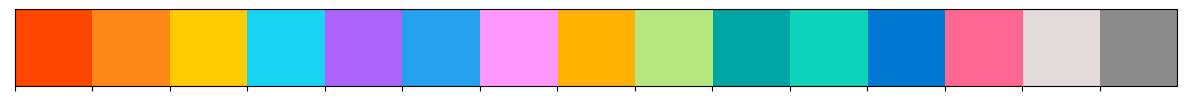

In [621]:
d_manual_label_colors = base_colors_for_manual_labels()
sns.palplot([v for v in d_manual_label_colors.values()])
check_colors_used(d_manual_label_colors, get_color_dict('dirl'))
check_colors_used(d_manual_label_colors, get_color_dict('plotly'))

## Plot by cluster ID

In [622]:
# df_subs_meta_plot.head()

## Subreddit-level

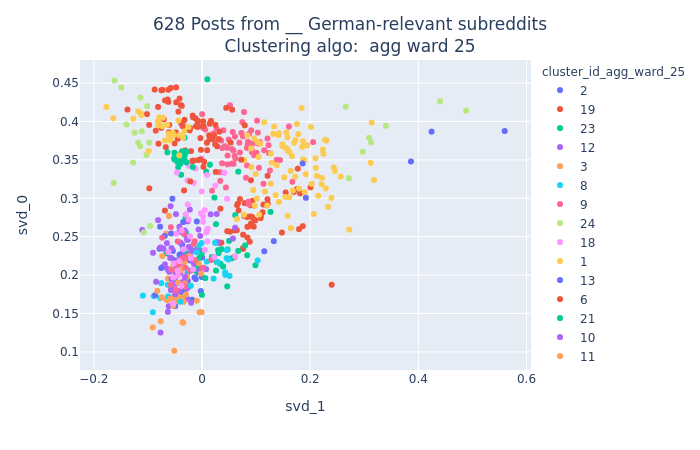

,cluster_id_agg_ward_25-count,cluster_id_agg_ward_25-percent,cluster_id_agg_ward_25-pct_cumulative_sum
6,83,13.2%,13.2%
1,81,12.9%,26.1%
9,66,10.5%,36.6%
12,49,7.8%,44.4%
19,46,7.3%,51.8%
23,36,5.7%,57.5%
0,32,5.1%,62.6%
3,27,4.3%,66.9%
10,27,4.3%,71.2%
16,26,4.1%,75.3%


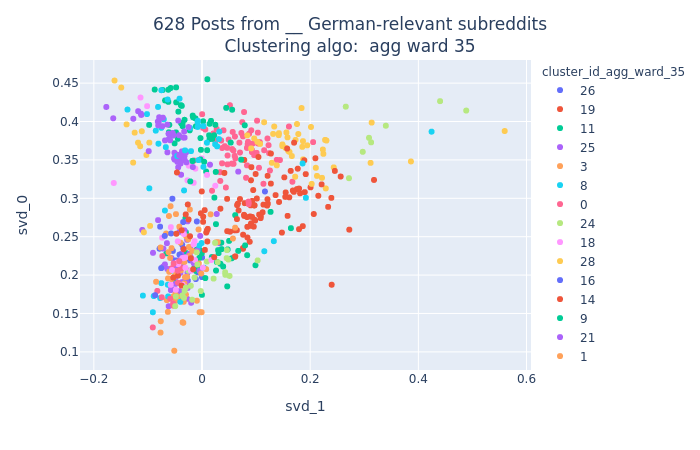

,cluster_id_agg_ward_35-count,cluster_id_agg_ward_35-percent,cluster_id_agg_ward_35-pct_cumulative_sum
0,66,10.5%,10.5%
9,52,8.3%,18.8%
25,49,7.8%,26.6%
19,46,7.3%,33.9%
28,42,6.7%,40.6%
14,37,5.9%,46.5%
11,36,5.7%,52.2%
27,31,4.9%,57.2%
12,27,4.3%,61.5%
3,27,4.3%,65.8%


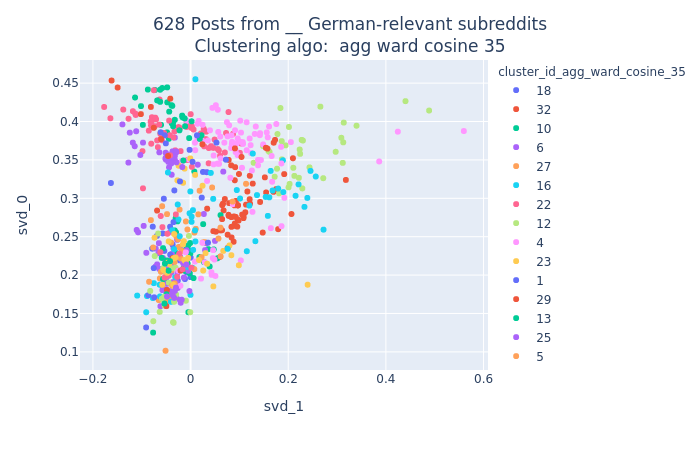

,cluster_id_agg_ward_cosine_35-count,cluster_id_agg_ward_cosine_35-percent,cluster_id_agg_ward_cosine_35-pct_cumulative_sum
4,66,10.5%,10.5%
6,47,7.5%,18.0%
32,41,6.5%,24.5%
22,39,6.2%,30.7%
12,34,5.4%,36.1%
13,32,5.1%,41.2%
10,28,4.5%,45.7%
24,26,4.1%,49.8%
25,24,3.8%,53.7%
9,22,3.5%,57.2%


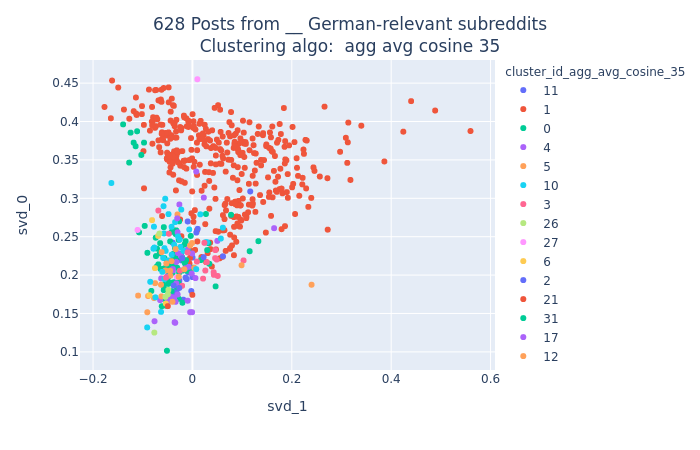

,cluster_id_agg_avg_cosine_35-count,cluster_id_agg_avg_cosine_35-percent,cluster_id_agg_avg_cosine_35-pct_cumulative_sum
1,378,60.2%,60.2%
0,92,14.6%,74.8%
10,31,4.9%,79.8%
4,30,4.8%,84.6%
11,22,3.5%,88.1%
3,15,2.4%,90.4%
5,12,1.9%,92.4%
12,8,1.3%,93.6%
2,6,1.0%,94.6%
6,3,0.5%,95.1%


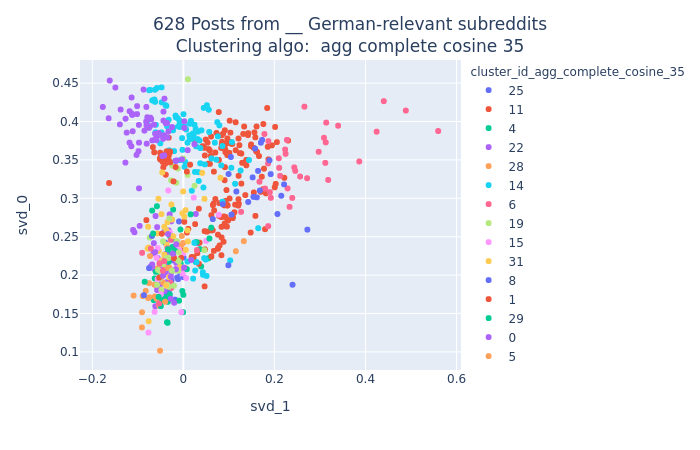

,cluster_id_agg_complete_cosine_35-count,cluster_id_agg_complete_cosine_35-percent,cluster_id_agg_complete_cosine_35-pct_cumulative_sum
11,122,19.4%,19.4%
14,83,13.2%,32.6%
0,60,9.6%,42.2%
22,44,7.0%,49.2%
1,43,6.8%,56.1%
6,35,5.6%,61.6%
4,26,4.1%,65.8%
8,21,3.3%,69.1%
25,20,3.2%,72.3%
12,18,2.9%,75.2%


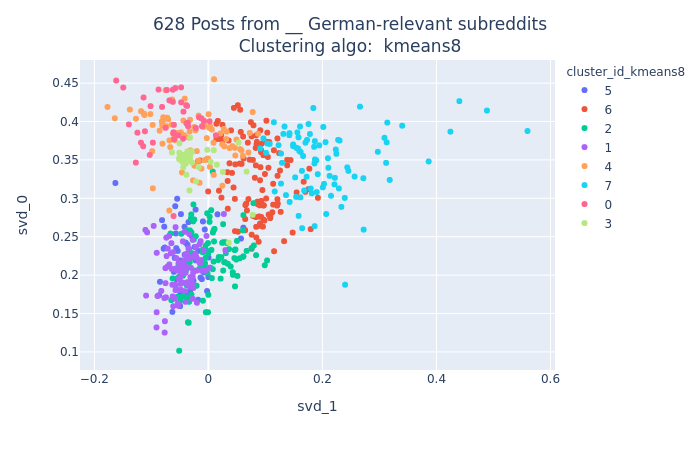

,cluster_id_kmeans8-count,cluster_id_kmeans8-percent,cluster_id_kmeans8-pct_cumulative_sum
6,117,18.6%,18.6%
2,109,17.4%,36.0%
1,99,15.8%,51.8%
7,88,14.0%,65.8%
4,84,13.4%,79.1%
5,55,8.8%,87.9%
0,42,6.7%,94.6%
3,34,5.4%,100.0%


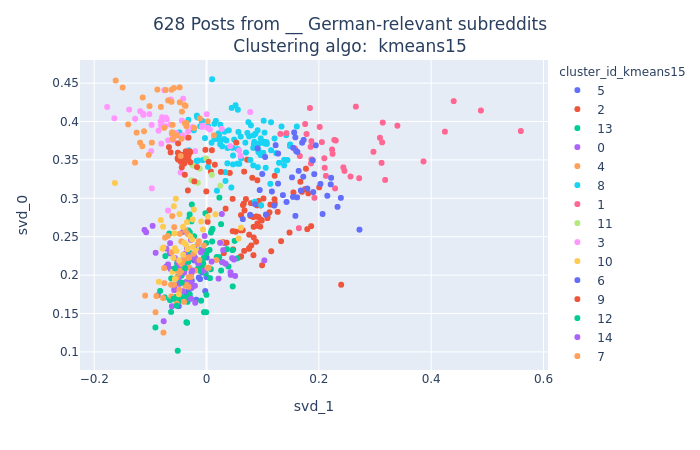

,cluster_id_kmeans15-count,cluster_id_kmeans15-percent,cluster_id_kmeans15-pct_cumulative_sum
8,99,15.8%,15.8%
13,70,11.1%,26.9%
2,69,11.0%,37.9%
0,53,8.4%,46.3%
3,49,7.8%,54.1%
4,48,7.6%,61.8%
6,42,6.7%,68.5%
1,40,6.4%,74.8%
7,39,6.2%,81.1%
10,36,5.7%,86.8%


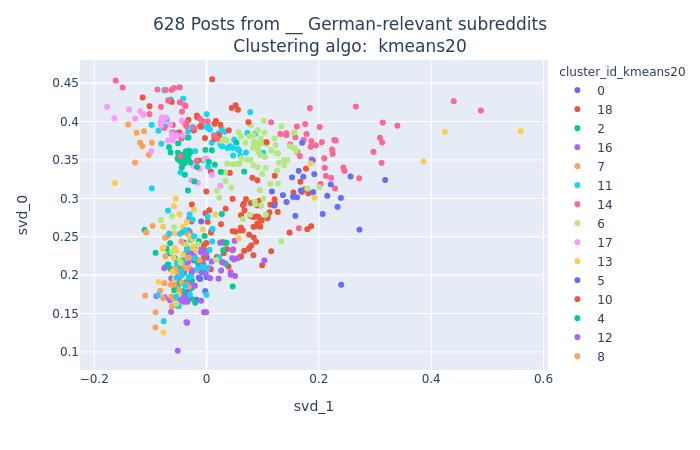

,cluster_id_kmeans20-count,cluster_id_kmeans20-percent,cluster_id_kmeans20-pct_cumulative_sum
18,80,12.7%,12.7%
6,72,11.5%,24.2%
2,55,8.8%,33.0%
11,47,7.5%,40.4%
14,42,6.7%,47.1%
16,39,6.2%,53.3%
4,34,5.4%,58.8%
7,32,5.1%,63.9%
15,31,4.9%,68.8%
9,30,4.8%,73.6%


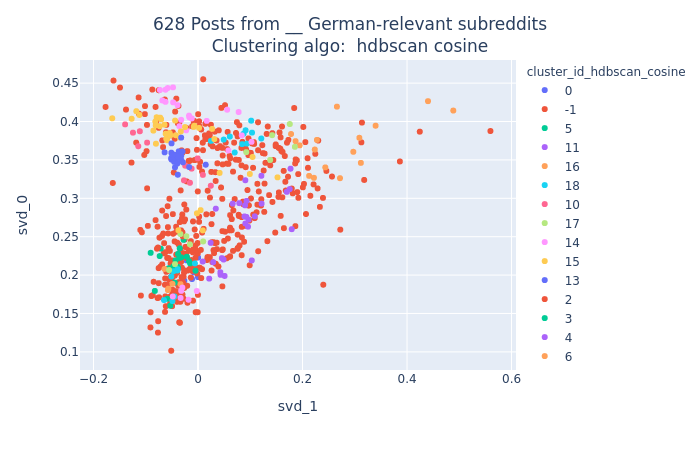

,cluster_id_hdbscan_cosine-count,cluster_id_hdbscan_cosine-percent,cluster_id_hdbscan_cosine-pct_cumulative_sum
-1,408,65.0%,65.0%
15,31,4.9%,69.9%
13,23,3.7%,73.6%
14,20,3.2%,76.8%
11,18,2.9%,79.6%
16,16,2.5%,82.2%
5,15,2.4%,84.6%
0,12,1.9%,86.5%
18,11,1.8%,88.2%
4,10,1.6%,89.8%


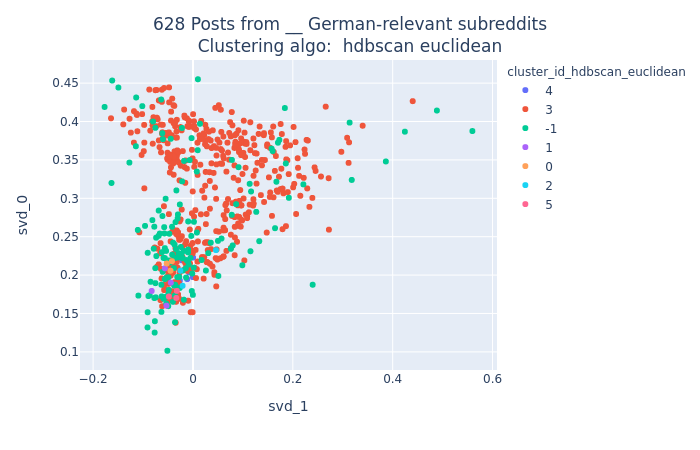

,cluster_id_hdbscan_euclidean-count,cluster_id_hdbscan_euclidean-percent,cluster_id_hdbscan_euclidean-pct_cumulative_sum
3,451,71.8%,71.8%
-1,153,24.4%,96.2%
4,11,1.8%,97.9%
1,4,0.6%,98.6%
2,3,0.5%,99.0%
5,3,0.5%,99.5%
0,3,0.5%,100.0%


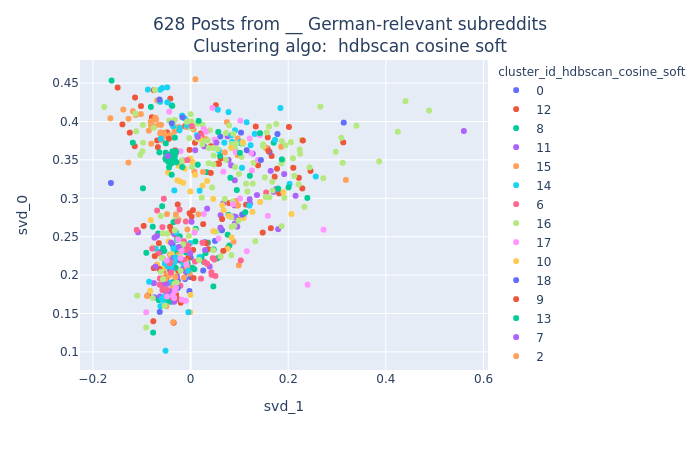

,cluster_id_hdbscan_cosine_soft-count,cluster_id_hdbscan_cosine_soft-percent,cluster_id_hdbscan_cosine_soft-pct_cumulative_sum
16,109,17.4%,17.4%
12,56,8.9%,26.3%
15,53,8.4%,34.7%
13,49,7.8%,42.5%
14,43,6.8%,49.4%
8,40,6.4%,55.7%
10,39,6.2%,61.9%
11,28,4.5%,66.4%
7,26,4.1%,70.5%
4,24,3.8%,74.4%


CPU times: user 1.64 s, sys: 39.5 ms, total: 1.68 s
Wall time: 3.85 s


In [649]:
%%time

df_plot_ = df_subs_meta_plot

for c_name in d_cluster_name_and_labels.keys():   
    fig = px.scatter(
        df_plot_,
        y='svd_0', x='svd_1',
        color=c_name,
    )

    fig.update_layout(
        title_text=(
            f"{len(df_plot_):,.0f} Posts from __ German-relevant subreddits"
            f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
            # f"<br>Using posts from 04-01-2021 to 05-08-2021"
        ),
        title_x=0.5,
        width=900,
        height=700,
    #     uniformtext_minsize=8, uniformtext_mode='hide'
    )

    # fig.show()
    fig.show(renderer='png')
    display(value_counts_and_pcts(df_plot_[c_name], top_n=10))

# Show subreddit names for each cluster

In [650]:
cols_to_front = [
    'subreddit_name',
    
    'manual_topic_and_rating',
    
    'subreddit_title',
    'post_median_word_count',
    'subreddit_name_title_and_clean_descriptions_word_count',
    
]
cols_to_exclude = [
    'subreddit_public_description',
    'subreddit_description',

    'subreddit_name_title_and_clean_descriptions',
    
]

In [651]:
# df_subs_meta_plot.head()

In [653]:
col_clustering = 'cluster_id_agg_ward_cosine_35'

for id_ in sorted(df_subs_meta_plot[col_clustering].unique()):
    mask_ = df_subs_meta_plot[col_clustering] == id_
    print(f"\nCluster ID: {id_}\n  {mask_.sum()} Subreddit count in group")
    
    cols_to_display = reorder_array(
        cols_to_front,
        df_subs_meta_plot.drop(cols_to_exclude, axis=1).columns
    )
    display(value_counts_and_pcts(df_subs_meta_plot[mask_][col_manual_labels]))
    display(
        style_df_numeric(
            df_subs_meta_plot[mask_][cols_to_display]
            .sort_values(by=['users_l28'], ascending=False)
            .head(10)
            ,
            rename_cols_for_display=True,
        )
    )


Cluster ID: 0
  11 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
uncategorized,4,36.4%,36.4%
food and drink,3,27.3%,63.6%
reddit institutions,2,18.2%,81.8%
outdoors and nature,1,9.1%,90.9%
home and garden,1,9.1%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
248,germanypics,outdoors and nature,Germany Pics,5,471,t5_348ch,0,23,11,0,0,1,2,13,2,-1,3,8,0.19,0.05,0.01,DE,1,797.00,None,None,outdoors and nature,outdoors and nature,pg,v3,Outdoors and Nature,v3,None,t,None,en,all_ads,"12,893",2020-08-24,2021-06-14,"1,776","5,554",7,70,11,101,2021-06-17,457,25.76%,60.61%,13.64%,36.36%,25.00%,38.64%,0.00%
559,spabiergang,uncategorized,Spabiergang,5,158,t5_3iui8,0,23,11,0,1,1,2,2,18,-1,-1,13,0.23,0.03,0.02,DE,1,535.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,all_ads,"3,849",2020-08-24,2021-06-14,912,"4,881",16,48,46,271,2021-06-17,153,81.98%,0.90%,17.12%,64.86%,22.52%,4.50%,8.11%
50,bavaria,uncategorized,"Bayern, Bavaria, Baviera, Bavarska, Bavorsko, Βαυαρία, Bajorország, Bawaria, Бавария",7,153,t5_2sifz,0,23,11,0,0,1,2,0,2,-1,3,4,0.21,0.03,-0.00,DE,1,662.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,all_ads,"5,379",2020-08-24,2021-06-14,"1,556","4,814",12,51,119,321,2021-06-17,137,50.00%,35.94%,14.06%,35.16%,19.53%,19.53%,25.78%
205,garten,home and garden,alles über den Garten,12,64,t5_2unl9,0,23,11,0,1,18,2,13,2,-1,-1,10,0.22,-0.01,-0.10,DE,1,676.00,None,None,home and garden,home and garden,pg,None,Home and Garden,v3,None,t,None,de,all_ads,"3,552",2020-08-24,2021-06-14,"1,297","3,837",28,131,221,713,2021-06-17,17,97.65%,0.88%,1.47%,32.65%,12.35%,28.53%,26.47%
63,bier,food and drink,Bier,9,135,t5_2tiu8,0,23,11,0,1,1,2,13,18,-1,-1,12,0.22,-0.00,0.01,DE,0,856.00,None,None,food and drink,food and drink,r,None,Food and Drink,v3,None,t,None,en,some_ads,"5,051",2020-08-24,2021-06-14,495,"1,966",7,24,20,115,2021-06-17,122,50.00%,29.41%,20.59%,32.35%,36.76%,13.24%,17.65%
459,naturfreunde,uncategorized,naturfreunde,6,76,t5_2ri0v6,0,23,11,0,1,1,2,2,18,-1,3,9,0.23,0.07,-0.04,DE,1,641.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,all_ads,"2,065",2020-08-24,2021-06-14,602,"1,264",21,75,107,372,2021-06-17,34,91.04%,0.50%,8.46%,46.27%,16.92%,33.83%,2.99%
601,wasserknaben,uncategorized,WasserKnaben,5,42,t5_2m5a5m,0,23,11,0,8,20,2,2,18,-1,-1,2,0.21,0.10,-0.00,DE,1,698.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,"3,181",2020-08-24,2021-06-14,227,885,0,9,3,35,2021-06-17,20,93.33%,0.00%,6.67%,20.00%,20.00%,46.67%,13.33%
103,daheim,reddit institutions,Denn Daheim ist immer am schönsten!,7,268,t5_2v4of6,0,23,11,0,3,24,2,13,12,-1,-1,0,0.21,0.03,0.00,None,-,-,reddit institutions,r/casualuk,reddit institutions,reddit institutions,pg,None,Internet Culture and Memes,v3,None,t,None,de,all_ads,"1,128",2020-08-24,2021-06-14,141,646,5,8,6,16,2021-06-17,224,88.89%,11.11%,0.00%,11.11%,22.22%,55.56%,11.11%
39,augenbleiche,reddit institutions,r/Augenbleiche,5,97,t5_3o3fz,0,23,11,0,1,1,2,2,18,-1,-1,8,0.24,0.08,0.01,None,-,-,reddit institutions,r/eyebleach,reddit institutions,reddit institutions,None,None,None,None,None,t,None,de,all_ads,72,2021-04-03,2021-06-14,36,303,3,15,


Cluster ID: 1
  13 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
gaming,9,69.2%,69.2%
"culture, entertainment, music",2,15.4%,84.6%
uncategorized,1,7.7%,92.3%
reddit institutions,1,7.7%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
395,lolteamsuche,uncategorized,League of Legends: Teamsuche,24,50,t5_2h3t30,11,5,4,1,15,7,5,10,13,-1,-1,0,0.32,-0.16,0.14,DE,1,531.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"1,147",2020-08-24,2021-06-14,672,"1,733",219,525,53,152,2021-06-17,9,88.92%,10.60%,0.48%,0.32%,0.05%,0.37%,99.26%
89,clashofclansde,gaming,Clash of Clans auf Deutsch,10,15,t5_3e2hl,0,10,1,1,10,31,5,10,13,2,-1,12,0.26,-0.04,0.06,None,-,-,gaming,game,gaming,gaming,None,None,None,None,None,t,None,de,all_ads,51,2021-04-30,2021-06-14,154,162,11,13,31,31,2021-06-17,0,87.50%,4.17%,8.33%,8.33%,4.17%,54.17%,33.33%
58,beziehungen,reddit institutions,Beziehungen,63,117,t5_33hvw,13,13,22,1,6,32,1,4,7,-1,-1,7,0.25,-0.07,-0.02,None,-,-,reddit institutions,r/relationships + r/relationshipadvice,reddit institutions,reddit institutions,None,None,None,None,None,t,None,de,all_ads,16,2020-09-05,2021-06-14,21,111,0,2,0,2,2021-06-17,84,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,100.00%
131,diesiedler,gaming,Die Siedler auf Deutsch,7,11,t5_4bw2c7,0,13,16,1,10,31,5,10,13,-1,-1,6,0.23,-0.04,0.09,None,-,-,gaming,settlers,gaming,gaming,None,None,None,None,None,t,None,en,all_ads,10,2021-04-29,2021-06-14,8,22,0,0,0,0,2021-06-17,0,85.71%,14.29%,0.00%,0.00%,14.29%,42.86%,42.86%
74,buehne,"culture, entertainment, music",Buehne,36,43,t5_4ckovw,12,13,22,1,6,32,5,0,9,-1,-1,12,0.17,-0.09,0.04,None,-,-,culture + entertainment,"sub for musicals, theatre and opera",culture + entertainment,culture + entertainment,None,None,None,None,None,t,None,de,all_ads,8,2021-05-03,2021-06-12,1,20,0,0,0,0,2021-06-17,22,100.00%,0.00%,0.00%,0.00%,50.00%,0.00%,50.00%
172,eurotruckde,gaming,EuroTruckDE,10,9,t5_4cdjio,0,13,16,1,10,31,5,10,13,-1,-1,8,0.23,-0.05,0.03,None,-,-,gaming,game,gaming,gaming,None,None,None,None,None,t,None,en,all_ads,11,2021-05-02,2021-06-14,11,20,0,0,0,0,2021-06-17,7,83.33%,0.00%,16.67%,0.00%,16.67%,50.00%,33.33%
623,zeldade,gaming,ZeldaDE,10,30,t5_4ck25y,0,13,16,1,10,31,5,10,13,-1,-1,0,0.24,-0.04,0.06,None,-,-,gaming,game,gaming,gaming,None,None,None,None,None,t,None,en,all_ads,11,2021-05-03,2021-06-13,6,17,1,1,0,0,2021-06-17,28,87.50%,12.50%,0.00%,0.00%,12.50%,50.00%,37.50%
193,fortnitede,gaming,Fortnite Community Deutschlands,17,41,t5_jiuwl,0,13,16,1,10,31,5,10,13,-1,-1,4,0.30,-0.05,0.08,None,-,-,gaming,game,gaming,gaming,None,None,None,None,f,t,None,de,None,27,2020-09-05,2021-06-14,10,16,1,5,0,0,2021-06-17,29,71.43%,14.29%,14.29%,0.00%,28.57%,14.29%,57.14%
425,mediende,"culture, entertainment, music",MedienDE,40,100,t5_4azjpj,13,13,22,1,6,32,1,4,16,-1,-1,9,0.21,-0.08,0.01,None,-,-,culture + entertainment,a subreddit dedicated to discussing german media,culture + entertainment,culture + entertainment,None,None,None,None,None,t,None,de,all_ads,7,2021-04-24,2021-06-08,1,15,0,1,0,0,2021-06-17,68,83.33%,16.67%,0.00%,0.00%,33.33%,0.00%,66.67%
18,animalcrossingde,gaming,AnimalCrossingDE,60,26,t5_30i1ea,13,13,16,1,10,31,5,10,13,-1,-


Cluster ID: 10
  28 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
uncategorized,16,57.1%,57.1%
reddit institutions,5,17.9%,75.0%
internet culture and memes,4,14.3%,89.3%
place/culture,2,7.1%,96.4%
funny/humor,1,3.6%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
109,de,place/culture,r/de – Extraordinär gut!,13,413,t5_22i0,12,3,3,10,1,4,2,13,16,8,3,8,0.20,-0.05,0.00,DE,1,1.00,None,None,uncategorized,uncategorized,pg13,v2,None,None,f,t,f,de,all_ads,"450,891",2020-08-24,2021-06-14,"390,101","1,234,882","1,418","5,470","62,292","252,056",2021-06-17,382,96.75%,1.75%,1.49%,10.67%,51.58%,5.05%,32.71%
42,austria,place/culture,reddit Rot-Weiß-Rot,10,636,t5_2qo9i,0,3,3,10,1,4,2,13,16,8,3,8,0.22,-0.01,-0.01,AT,1,1.00,None,None,place,place,pg,v2,Place,v3,f,t,f,de,all_ads,"198,305",2020-08-24,2021-06-14,"67,433","174,118",611,"2,186","9,614","38,505",2021-06-17,606,84.01%,10.12%,5.86%,31.32%,30.84%,9.05%,28.78%
423,mauerstrassenwetten,internet culture and memes,mauerstrassenwetten,8,129,t5_2eago4,0,8,8,10,5,28,2,13,18,-1,3,14,0.24,-0.00,-0.01,DE,1,20.00,None,None,internet culture and memes,internet culture and memes,r,None,Internet Culture and Memes,v3,None,t,None,en,some_ads,"102,900",2020-08-24,2021-06-14,"69,797","144,417",327,861,"19,700","64,795",2021-06-17,108,89.27%,3.54%,7.18%,52.99%,17.26%,13.90%,15.86%
2,600euro,internet culture and memes,Offizielle Außenstelle der deutsch GmbH kolonie der USA.,7,253,t5_3caax,0,23,11,10,1,4,2,13,18,-1,3,12,0.23,0.04,-0.01,DE,1,15.00,None,None,internet culture and memes,internet culture and memes,r,v2,Internet Culture and Memes,v3,None,f,None,de,some_ads,"31,975",2020-08-24,2021-06-14,"21,499","67,773",84,452,"3,020","12,581",2021-06-17,211,89.24%,2.12%,8.65%,69.83%,15.64%,11.13%,3.40%
284,ichbin40undlustig,internet culture and memes,ichbin40undlustig,15,14,t5_17d5ey,0,23,11,10,4,1,2,2,18,-1,-1,15,0.33,0.01,-0.08,DE,1,50.00,None,None,internet culture and memes,internet culture and memes,pg13,v2,Internet Culture and Memes,v3,None,t,None,en,all_ads,"25,234",2020-08-24,2021-06-14,"13,458","38,462",67,306,508,"2,154",2021-06-17,6,94.91%,0.20%,4.89%,81.26%,6.31%,11.91%,0.51%
147,egenbogen,reddit institutions,REGENBOGEN,14,203,t5_3eaxt,12,23,11,10,4,15,2,13,16,-1,3,5,0.26,-0.03,-0.02,None,-,-,reddit institutions,r/ainbow,reddit institutions,reddit institutions,None,None,None,None,None,t,None,de,all_ads,"1,801",2020-08-25,2021-06-14,"1,163","29,003",10,89,46,214,2021-06-17,128,90.20%,1.96%,7.84%,7.84%,54.90%,13.73%,23.53%
38,asozialesnetzwerk,uncategorized,AN Sektion Reddit,9,730,t5_392ha,0,23,11,10,1,4,2,13,16,-1,3,13,0.22,0.03,0.01,DE,1,141.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,all_ads,"13,002",2020-08-24,2021-06-14,"11,967","19,532",51,179,471,"1,268",2021-06-17,647,85.01%,5.75%,9.24%,23.00%,33.68%,32.24%,11.09%
79,bundeswehr,uncategorized,Bundeswehr - Wir. Dienen. Deutschland.,18,46,t5_2ty5z,13,23,11,10,0,10,1,13,16,-1,3,2,0.20,-0.05,-0.03,DE,1,105.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,all_ads,"5,112",2020-08-24,2021-06-14,"5,005","15,456",66,203,657,"2,252",2021-06-17,21,91.57%,7.23%,1.20%,13.05%,33.73%,4.62%,48.59%
252,geschichtsmaimais,internet culture a


Cluster ID: 11
  9 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
sports,9,100.0%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
327,kampfsport,sports,Kampfsport,8,69,t5_i0wle,12,2,5,11,11,25,5,5,0,-1,-1,2,0.20,-0.01,-0.01,None,-,-,sports,martial arts,sports,sports,None,None,None,None,f,t,None,de,all_ads,912,2021-04-28,2021-06-14,240,"12,978",39,153,71,220,2021-06-17,0,67.00%,19.50%,13.50%,1.50%,82.50%,6.00%,10.00%
192,formel1,sports,Formel 1,10,11,t5_3hik5,12,2,5,11,11,4,5,5,0,1,-1,0,0.18,-0.00,-0.01,None,-,-,sports,formula 1,sports,sports,None,None,None,None,None,t,None,de,None,"1,075",2020-08-24,2021-06-14,452,"6,533",42,169,97,454,2021-06-17,0,90.87%,1.98%,7.14%,1.98%,73.02%,17.06%,7.94%
511,radsport,sports,Radsport auf Reddit.,10,97,t5_394oo,12,2,5,11,11,25,5,5,0,1,5,1,0.17,-0.05,0.01,None,-,-,sports,cycling,sports,sports,None,None,None,None,None,t,None,de,all_ads,217,2020-08-24,2021-06-14,884,"1,260",53,155,53,136,2021-06-17,67,76.06%,11.21%,12.73%,0.51%,90.32%,0.34%,8.83%
447,motorsport_de,sports,Motorsport,10,17,t5_4bkv83,12,2,5,11,11,4,5,5,0,1,5,1,0.17,-0.03,-0.00,None,-,-,sports,motorsports,sports,sports,None,None,None,None,None,t,None,en,all_ads,110,2021-04-27,2021-06-14,158,440,45,116,4,15,2021-06-17,0,90.77%,4.62%,4.62%,0.00%,88.21%,10.77%,1.03%
555,sommerspiele,sports,Die Sommerspiele - Tokyo 2021,10,16,t5_4cf0rg,12,2,5,11,11,25,5,5,0,1,-1,1,0.17,-0.02,-0.00,None,-,-,sports,olympics,sports,sports,None,None,None,None,None,t,None,en,all_ads,61,2021-05-02,2021-06-14,71,232,7,55,0,7,2021-06-17,11,89.09%,7.27%,3.64%,0.00%,62.73%,34.55%,2.73%
505,platzreife,sports,Platzreife,8,26,t5_4c7a6m,12,2,5,11,11,25,5,5,0,-1,-1,1,0.17,-0.04,0.03,None,-,-,sports,golf,sports,sports,None,None,None,None,None,t,None,en,all_ads,24,2021-05-01,2021-06-14,39,140,4,23,3,6,2021-06-17,24,78.93%,14.05%,7.02%,0.00%,97.52%,0.41%,2.07%
580,tischtennis,sports,tischtennis,9,29,t5_3h9up,12,2,5,11,11,25,5,5,0,1,5,1,0.18,-0.03,0.01,None,-,-,sports,table tennis,sports,sports,None,None,None,None,None,t,None,en,all_ads,70,2020-08-27,2021-06-14,36,106,0,25,1,9,2021-06-17,0,82.95%,12.50%,4.55%,0.00%,96.02%,1.14%,2.84%
351,kreisliga,sports,Kreisliga. Das virtuelle Vereinsheim,10,90,t5_4cf1yq,12,2,5,11,11,25,5,5,0,0,-1,1,0.21,-0.01,0.02,None,-,-,sports,amateur football memes,sports,sports,None,None,None,None,None,t,None,en,all_ads,93,2021-05-02,2021-06-14,14,85,1,5,2,5,2021-06-17,10,94.59%,2.70%,2.70%,27.03%,59.46%,5.41%,8.11%
265,handball_de,sports,Handball,9,11,t5_4cefbk,12,2,5,11,11,25,5,5,0,1,-1,1,0.18,-0.03,0.01,None,-,-,sports,handball,sports,sports,None,None,None,None,None,t,None,en,all_ads,37,2021-05-02,2021-06-13,10,49,5,33,0,1,2021-06-17,0,97.53%,0.00%,2.47%,0.00%,97.53%,0.00%,2.47%



Cluster ID: 12
  34 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
uncategorized,18,52.9%,52.9%
over18_nsfw,16,47.1%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
166,encahaxhia,over18_nsfw,"Albanian Goddess, pop singer",1,11,t5_240jcz,7,1,28,12,1,6,7,1,14,16,3,16,0.37,0.19,0.07,DE,0,527.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"5,988",2020-08-24,2021-06-14,"17,222","39,358",22,80,234,528,2021-06-17,0,7.95%,25.83%,66.23%,41.72%,10.60%,35.76%,11.92%
46,badmomzjay,over18_nsfw,badmomzjay,0,20,t5_2otvlo,18,24,24,12,1,6,7,1,14,16,3,16,0.43,0.44,0.07,DE,1,122.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"9,128",2020-08-24,2021-06-14,"8,578","29,808",1,4,9,62,2021-06-17,5,0.00%,0.00%,100.00%,12.50%,79.17%,8.33%,0.00%
22,anne_wuensche,uncategorized,Anne_Wuensche,2,36,t5_2hhaz3,7,1,28,12,1,11,7,1,14,-1,3,9,0.38,0.23,-0.01,DE,1,136.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,"5,011",2020-08-24,2021-06-14,"7,653","27,143",23,59,104,202,2021-06-17,0,38.68%,1.89%,59.43%,33.96%,1.89%,60.38%,3.77%
427,melinasophie,over18_nsfw,"Bilder, Screenshots und Clips rund um die Youtuberin und influencerin Melina Sophie",2,37,t5_168aox,7,1,28,12,1,6,7,1,14,16,3,16,0.33,0.21,0.02,DE,1,90.00,None,None,mature themes and adult content,over18_nsfw,nc17,None,Mature Themes and Adult Content,v3,None,t,None,en,no_ads,"11,494",2020-08-24,2021-06-14,"5,203","19,774",4,23,6,82,2021-06-17,0,35.38%,15.38%,49.23%,46.15%,7.69%,44.62%,1.54%
324,justlucy,over18_nsfw,JustLucy,0,4,t5_36z9gc,18,24,24,12,1,6,7,1,14,16,-1,16,0.41,0.49,0.05,DE,1,103.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"7,013",2020-10-01,2021-06-14,"5,384","16,795",2,4,0,1,2021-06-17,2,0.00%,11.76%,88.24%,94.12%,0.00%,5.88%,0.00%
448,mrsbella,uncategorized,MrsBella,3,78,t5_23o43o,18,1,28,12,1,6,7,1,14,-1,3,16,0.36,0.22,0.08,DE,1,128.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,"5,536",2020-08-24,2021-06-14,"6,576","13,671",11,41,7,42,2021-06-17,41,16.28%,16.28%,67.44%,51.16%,9.30%,32.56%,6.98%
497,paolamariahot,over18_nsfw,Paola maria hot,2,25,t5_pp5l6,7,1,28,12,1,11,7,6,14,16,3,16,0.37,0.19,0.01,DE,1,202.00,None,None,mature themes and adult content,over18_nsfw,nc17,v3,Mature Themes and Adult Content,v3,f,t,None,en,no_ads,"6,010",2020-08-24,2021-06-14,"3,792","12,914",8,42,5,59,2021-06-17,8,38.46%,8.97%,52.56%,62.82%,1.28%,28.21%,7.69%
495,pamela_reif,uncategorized,Pamela Reif,2,65,t5_j49bq,7,1,28,12,1,6,7,1,14,16,3,16,0.36,0.22,-0.00,DE,1,248.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,en,None,"4,517",2020-08-24,2021-06-14,"2,896","9,609",26,67,21,74,2021-06-17,57,19.47%,26.55%,53.98%,62.83%,8.85%,28.32%,0.00%
164,emiliabte,uncategorized,EmiliaBte,2,15,t5_2oyuyj,7,1,28,12,1,6,7,1,14,16,3,16,0.34,0.24,0.03,DE,1,298.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"2,595",2020-08-24,2021-06-14,"3,204","8,100",29,62,24,93,2021-06-17,7,24.05%,18.99%,56.96%,45.57%,6.33%,48.10%,0.00%
298,janariva,uncategorized,Jana 


Cluster ID: 13
  32 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
over18_nsfw,22,68.8%,68.8%
uncategorized,10,31.2%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
608,wixbros,over18_nsfw,WixBros,8,17,t5_3kytod,15,6,9,13,1,14,0,7,15,14,3,14,0.44,-0.06,-0.09,DE,1,56.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,de,None,"18,375",2020-12-18,2021-06-14,"63,779","174,174","3,539","15,243","5,469","23,541",2021-06-17,15,90.02%,2.20%,7.79%,15.24%,0.82%,7.36%,76.59%
128,deutschetributes,over18_nsfw,Deutschetributes,8,28,t5_3nl4m8,15,6,9,13,1,14,0,7,15,14,3,14,0.40,-0.01,-0.08,DE,1,143.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,de,None,"9,165",2021-01-01,2021-06-14,"17,870","47,912",911,"1,514","1,478","3,214",2021-06-17,1,84.43%,4.49%,11.08%,25.30%,2.54%,14.32%,57.84%
401,loredanahot,over18_nsfw,LoredanaHOT,8,13,t5_2zskz2,15,6,9,13,1,14,0,7,10,14,3,14,0.43,-0.06,0.00,DE,1,225.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"2,218",2020-08-24,2021-06-14,"12,639","35,991",393,"1,228",469,"1,239",2021-06-17,11,66.39%,16.19%,17.42%,22.29%,15.19%,4.99%,57.54%
20,annaschmidt,uncategorized,AnnaSchmidti,7,20,t5_2sbqu6,15,6,9,13,1,14,0,8,10,14,3,18,0.41,-0.02,-0.01,DE,1,120.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,en,None,"4,681",2020-08-24,2021-06-14,"9,617","24,061",131,499,298,928,2021-06-17,8,80.57%,6.05%,13.38%,14.13%,14.42%,5.53%,65.92%
219,germancelebtribute,over18_nsfw,germancelebtribute,8,30,t5_33o2in,17,6,9,13,1,14,0,7,15,14,3,14,0.39,-0.04,-0.03,DE,1,266.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"1,533",2020-09-10,2021-06-14,"4,638","16,460",123,460,62,296,2021-06-17,12,50.00%,33.95%,16.05%,39.63%,14.32%,12.22%,33.83%
239,germantradesnsfw,over18_nsfw,GermanTradesNSFW,8,11,t5_2a8b3h,15,6,9,13,1,14,0,7,15,14,3,14,0.44,-0.05,-0.06,DE,1,230.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"3,287",2020-08-24,2021-06-14,"3,947","14,317",33,111,38,265,2021-06-17,9,74.44%,8.89%,16.67%,52.22%,14.44%,33.33%,0.00%
389,lisaandlenansfw,over18_nsfw,LISAANDLENANSFW,7,26,t5_2v7dgb,15,6,9,13,1,14,4,8,10,14,3,14,0.41,-0.02,0.04,DE,1,177.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"3,134",2020-08-24,2021-06-14,"3,590","12,407",30,93,47,139,2021-06-17,11,56.20%,21.90%,21.90%,22.73%,26.03%,6.20%,45.04%
222,germancumdumpandmore,over18_nsfw,Germancumdumpandmore,8,30,t5_3i9cec,15,6,9,13,1,14,0,7,15,14,3,14,0.42,-0.04,-0.07,DE,1,176.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"1,598",2020-12-03,2021-06-14,"2,263","9,747",36,318,32,350,2021-06-17,28,83.48%,4.80%,11.72%,12.97%,9.41%,13.50%,64.12%
540,schwesta_ewa,uncategorized,Schwesta_Ewa,9,6,t5_2rfnc2,15,6,9,13,1,14,0,8,10,-1,3,12,0.39,-0.01,-0.05,DE,1,303.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,en,None,"2,555",2020-08-24,2021-06-14,"3,212","9,467",12,27,24,70,2021-06-17,4,84.31%,1.96%,13.73%,35.29%,3.92%,17.65%,43.14%
553,sissygermany,over18_nsfw,SissyGermany,11,26,t5_2u3s2d,14,6,9,13,1


Cluster ID: 14
  11 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
over18_nsfw,8,72.7%,72.7%
uncategorized,3,27.3%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
54,berlinsocialclub,uncategorized,Berlin Social Club,64,51,t5_2sjnp,13,5,6,14,0,22,1,0,8,-1,3,7,0.26,-0.11,-0.02,DE,1,64.00,None,None,uncategorized,uncategorized,pg13,v1,None,None,None,t,None,en,all_ads,"22,973",2020-08-24,2021-06-14,"6,382","15,601",78,287,520,"2,161",2021-06-17,47,4.46%,93.49%,2.04%,5.58%,3.90%,3.53%,86.99%
544,sextreffen,over18_nsfw,sextreffen,12,29,t5_2ideas,14,5,6,14,0,0,0,7,8,12,3,16,0.39,-0.11,-0.08,DE,1,304.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"3,387",2020-08-24,2021-06-14,"4,723","15,015",354,"1,470",292,"1,663",2021-06-17,9,89.41%,6.72%,3.87%,13.20%,1.57%,1.82%,83.41%
135,dirtypenpals_germany,over18_nsfw,Dirtypenpals Germany,77,244,t5_3fslf,14,5,6,14,0,0,0,7,8,12,-1,12,0.37,-0.11,-0.11,DE,1,168.00,None,None,uncategorized,over18_nsfw,x,v1,None,None,t,t,None,en,no_ads,"6,333",2020-08-24,2021-06-14,"3,066","9,676",90,366,82,294,2021-06-17,204,94.49%,3.92%,1.59%,0.00%,0.00%,0.98%,99.02%
134,dirtyde4de,over18_nsfw,Dirty R4R - German Edition,37,129,t5_r7ocn,14,5,6,14,0,0,0,7,8,12,3,12,0.40,-0.14,-0.11,DE,1,201.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"4,217",2020-08-24,2021-06-14,"2,276","6,603",54,225,42,145,2021-06-17,111,82.83%,15.09%,2.08%,0.00%,0.00%,1.32%,98.68%
188,fkksaunaclubs,over18_nsfw,FKK & sauna clubs,23,75,t5_3nv7c,13,12,25,14,32,22,1,0,2,-1,-1,4,0.26,-0.11,-0.06,DE,0,404.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"2,100",2020-08-24,2021-06-14,"1,561","5,945",1,7,1,12,2021-06-17,41,0.00%,100.00%,0.00%,0.00%,9.09%,18.18%,72.73%
53,berlinhookup,over18_nsfw,berlinhookup,14,54,t5_11cb5m,14,5,6,14,0,0,0,7,8,12,3,16,0.37,-0.10,-0.11,DE,1,455.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,804,2020-08-24,2021-06-14,"1,531","5,239",42,152,36,148,2021-06-17,14,43.52%,48.77%,7.72%,11.42%,2.78%,3.09%,82.72%
451,munichsocialclub,uncategorized,The subreddit for meetups and hangouts in Munich,61,99,t5_34xla,14,5,6,14,0,22,1,0,8,-1,-1,9,0.26,-0.10,-0.04,DE,1,314.00,None,None,uncategorized,uncategorized,pg13,v2,None,None,None,t,None,en,all_ads,"3,641",2020-08-24,2021-06-14,"1,061","3,700",7,33,52,207,2021-06-17,75,10.77%,89.23%,0.00%,3.08%,4.62%,0.00%,92.31%
225,germanhookups,over18_nsfw,Germanhookups,17,16,t5_3g21u2,14,5,6,14,0,0,0,7,8,12,3,12,0.39,-0.12,-0.08,DE,1,729.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,971,2020-11-21,2021-06-14,"1,055","2,982",14,62,14,38,2021-06-17,14,83.04%,11.70%,5.26%,11.11%,2.92%,2.34%,83.63%
97,cuckoldgermany,over18_nsfw,CuckoldGermany,34,31,t5_2q9rll,14,5,6,14,0,0,0,7,8,-1,3,16,0.36,-0.10,-0.10,DE,1,630.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,974,2020-08-24,2021-06-14,986,"2,516",27,71,50,113,2021-06-17,21,95.16%,4.03%,0.81%,7.26%,1.61%,1.61%,89.52%
413,makefriendsingermany,uncategorized,Neue Freunde finden,48,246,t5_i6fnv,14,5,6,14,0,22,0,7,8,-1,


Cluster ID: 15
  16 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
uncategorized,6,37.5%,37.5%
reddit institutions,3,18.8%,56.2%
internet culture and memes,2,12.5%,68.8%
law,1,6.2%,75.0%
family and relationships,1,6.2%,81.2%
technology,1,6.2%,87.5%
"culture, race, and ethnicity",1,6.2%,93.8%
medical and mental health,1,6.2%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
196,fragreddit,reddit institutions,Frag Reddit - auf Deutsch,74,105,t5_2r6ca,13,22,10,15,0,10,1,4,7,7,3,13,0.21,-0.04,-0.07,DE,1,26.00,None,None,meta/reddit,meta/reddit,pg,v2,Meta/Reddit,v3,f,t,None,de,all_ads,"30,180",2020-08-24,2021-06-14,"33,296","109,435",187,667,"3,231","12,397",2021-06-17,100,99.46%,0.13%,0.40%,0.00%,0.00%,0.40%,99.60%
110,de_edv,technology,deutsches Subreddit zur Elektronischen Datenverarbeitung,73,219,t5_3ii04,13,10,1,15,0,10,1,4,7,-1,3,6,0.20,-0.05,0.01,DE,1,46.00,None,None,technology,technology,pg,v2,Technology,v3,None,t,None,de,all_ads,"18,808",2020-08-24,2021-06-14,"14,789","51,697",64,274,"1,046","4,736",2021-06-17,202,94.80%,3.20%,2.00%,5.87%,22.67%,7.20%,64.27%
347,kopiernudeln,internet culture and memes,Copypasta auf deutsch,172,21,t5_39uv3,13,22,10,15,0,3,1,4,3,7,3,16,0.24,-0.02,-0.06,DE,1,62.00,None,None,internet culture and memes,internet culture and memes,r,None,Internet Culture and Memes,v3,None,t,None,de,some_ads,"10,834",2020-08-24,2021-06-14,"5,704","24,332",10,63,109,493,2021-06-17,4,98.61%,1.39%,0.00%,0.00%,0.00%,0.00%,100.00%
359,lagerfeuer,reddit institutions,Lagerfeuer,276,110,t5_4cm6ve,13,22,10,15,0,3,2,4,3,-1,-1,3,0.22,0.02,-0.06,None,-,-,reddit institutions,"""campfire stories"" r/nosleep",reddit institutions,reddit institutions,None,None,None,None,None,t,None,de,all_ads,"1,795",2021-05-03,2021-06-14,"4,144","19,128",19,67,104,235,2021-06-17,85,90.20%,7.84%,1.96%,0.00%,1.96%,7.84%,90.20%
148,einfach_posten,internet culture and memes,omg so viele poste im imnternet!,67,91,t5_3b2y1,13,22,10,15,0,3,1,4,7,7,3,7,0.25,-0.03,-0.05,DE,1,73.00,None,None,none of these topics,none of these topics,pg,v2,None of these topics,v3,None,f,None,de,all_ads,"10,810",2020-08-24,2021-06-14,"7,160","18,350",87,400,"1,143","4,822",2021-06-17,82,98.22%,0.52%,1.26%,12.58%,4.93%,4.93%,77.57%
241,germantrees,uncategorized,A place for German ents,27,209,t5_2tcsn,13,22,10,15,0,10,1,4,2,-1,3,6,0.24,-0.01,-0.06,DE,1,130.00,None,None,uncategorized,uncategorized,r,v1,None,None,None,t,None,de,no_ads,"6,929",2020-08-24,2021-06-14,"5,297","18,187",27,149,224,"1,662",2021-06-17,196,83.55%,8.06%,8.39%,22.26%,12.26%,13.87%,51.61%
240,germantrans,uncategorized,Deutschsprachiger Trans-Subreddit,90,92,t5_3ftuc,13,22,10,15,0,10,1,4,7,-1,-1,7,0.25,-0.07,-0.10,DE,1,157.00,None,None,uncategorized,uncategorized,None,None,None,None,None,f,None,de,None,"3,302",2020-08-24,2021-06-14,"3,883","13,203",43,178,239,"1,638",2021-06-17,54,95.52%,4.48%,0.00%,0.00%,0.00%,0.25%,99.75%
602,weibsvolk,"culture, race, and ethnicity","Kann es sein, dass Weibsvolk anwesend ist?",60,465,t5_3jflo,13,22,10,15,0,10,1,4,7,-1,3,10,0.24,-0.04,-0.09,DE,1,171.00,None,None,"culture, race, and ethnicity","culture, race, and ethnicity",pg,v2,"Culture, Race, and Ethnicity",v3,None,f,None,de,all_ads,"4,641",2020-08-24,2021-06-14,"3,072","8,946",12,59,414,"1,513",2021-06-17,382,92.74%,5.65%,1.61%,5.65%,25.81%,15.32%,53.23%
143,dsa_r


Cluster ID: 16
  11 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
uncategorized,9,81.8%,81.8%
"business, economics, and finance",2,18.2%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
184,finanzen,"business, economics, and finance",Fragen und Antworten zu Finanzen,95,286,t5_35m5e,13,8,8,16,5,28,1,4,7,-1,-1,6,0.19,-0.06,-0.02,DE,1,9.00,None,None,"business, economics, and finance","business, economics, and finance",pg,v1,"Business, Economics, and Finance",v3,None,t,None,de,all_ads,"102,477",2020-08-24,2021-06-14,"85,311","266,832",241,962,"8,283","30,368",2021-06-17,257,93.82%,5.53%,0.65%,5.24%,7.27%,3.87%,83.62%
8,aktien,uncategorized,"Aktien, Handel und Investmentstrategien",25,165,t5_313tk,13,8,8,16,5,28,1,4,7,-1,3,6,0.21,-0.05,-0.02,DE,1,355.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,de,all_ads,"15,932",2020-08-24,2021-06-14,"20,060","32,890",554,796,"3,158","5,633",2021-06-17,94,93.46%,3.31%,3.23%,4.97%,9.24%,9.07%,76.72%
616,yotta,uncategorized,Yotta Savings,38,67,t5_3f382,13,8,8,16,5,28,1,4,7,-1,-1,11,0.17,-0.06,-0.02,DE,1,374.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,985,2020-08-26,2021-06-14,"2,429","15,751",7,29,29,123,2021-06-17,16,1.37%,94.52%,4.11%,17.81%,2.74%,5.48%,73.97%
115,defiblockchain,uncategorized,defiblockchain,52,14,t5_2p8jo9,13,8,8,16,5,28,1,4,7,-1,-1,1,0.15,-0.09,0.03,DE,0,335.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"2,698",2020-08-24,2021-06-14,"3,063","9,829",38,206,289,"1,832",2021-06-17,6,2.16%,96.10%,1.73%,6.93%,11.26%,6.06%,75.76%
114,debitismus_forum,uncategorized,Wirtschaft und Gesellschaft ist Debitismus,52,198,t5_hs5by,13,8,8,16,5,28,1,4,16,-1,-1,8,0.17,-0.04,0.03,DE,1,306.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,de,None,329,2020-08-24,2021-06-14,"1,739","4,478",61,279,133,670,2021-06-17,126,90.66%,8.48%,0.86%,0.14%,0.29%,2.73%,96.84%
65,bitwala,uncategorized,[Blockchain Banking](https://www.bitwala.com/),54,190,t5_3hpbt,13,8,8,16,5,28,1,4,7,-1,-1,16,0.17,-0.11,0.01,DE,0,614.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,627,2020-08-24,2021-06-14,282,"1,559",3,19,24,101,2021-06-17,156,4.05%,95.95%,0.00%,5.41%,1.35%,4.05%,89.19%
64,bitcoinde,uncategorized,Bitcoin Nachrichten und Informationen auf Deutsch,11,96,t5_2wqam,13,8,8,16,5,28,1,4,16,-1,-1,2,0.17,-0.09,0.04,DE,1,485.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,"2,395",2020-08-24,2021-06-14,283,"1,359",16,77,5,53,2021-06-17,81,86.34%,13.11%,0.55%,2.73%,70.49%,4.92%,21.86%
503,pfennigaktien,uncategorized,Pfennigaktien,26,74,t5_3n0pf4,0,8,8,16,5,28,2,4,16,-1,3,13,0.21,0.00,0.01,DE,1,751.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"2,032",2020-12-29,2021-06-14,576,"1,278",1,8,9,46,2021-06-17,28,57.14%,35.71%,7.14%,14.29%,7.14%,21.43%,57.14%
561,sparfuechse,"business, economics, and finance",Sparsam & Wirtschaftlich,14,101,t5_373aq,13,8,8,16,5,28,1,4,7,-1,-1,7,0.19,-0.08,0.02,DE,1,710.00,None,None,"business, economics, and finance","business, economics, and 


Cluster ID: 17
  10 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
over18_nsfw,6,60.0%,60.0%
uncategorized,4,40.0%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
229,germannsfw,over18_nsfw,GermanNSFW,16,29,t5_27awla,5,5,6,17,1,0,0,7,15,-1,-1,8,0.45,-0.16,-0.09,DE,1,214.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"11,166",2020-08-24,2021-06-14,"5,883","20,685",181,621,40,205,2021-06-17,16,7.29%,84.33%,8.39%,30.17%,32.60%,9.09%,28.13%
408,lunaperuna,uncategorized,LunaPeruna,9,11,t5_2stq3b,0,6,27,17,20,26,4,3,11,-1,-1,4,0.28,-0.07,0.08,DE,1,197.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,640,2020-08-24,2021-06-14,"3,187","11,575",0,4,0,5,2021-06-17,1,50.00%,50.00%,0.00%,83.33%,0.00%,16.67%,0.00%
267,hannasecret,over18_nsfw,HannaSecret,5,11,t5_mz0lb,0,6,27,17,1,0,4,3,11,-1,3,12,0.43,-0.04,0.13,DE,1,284.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,de,None,"1,747",2020-08-24,2021-06-14,"2,256","10,868",4,33,0,12,2021-06-17,9,60.00%,22.00%,18.00%,40.00%,48.00%,0.00%,12.00%
490,onlyfansgermany,over18_nsfw,onlyfansgermany,23,10,t5_32zyu2,17,6,27,17,1,0,0,7,15,-1,-1,8,0.38,-0.06,-0.03,DE,1,191.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,de,None,"1,241",2020-09-06,2021-06-14,"2,435","9,491",13,46,5,34,2021-06-17,4,82.73%,13.64%,3.64%,70.91%,10.91%,15.45%,2.73%
126,deutschepornosx,uncategorized,Deutsche Pornos,11,24,t5_2ftk5g,17,6,27,17,1,0,0,7,15,-1,3,13,0.42,-0.08,-0.00,DE,1,764.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,383,2020-08-24,2021-06-14,"1,833","6,515",4,15,9,20,2021-06-17,0,86.96%,4.35%,8.70%,36.96%,10.87%,28.26%,23.91%
489,onlyfans_germany,over18_nsfw,OnlyFans_Germany,10,80,t5_3ixdaf,0,6,27,17,1,0,4,7,15,-1,3,7,0.36,-0.05,0.04,DE,1,411.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,de,None,826,2020-12-07,2021-06-14,"1,773","6,001",6,13,5,25,2021-06-17,39,68.75%,25.00%,6.25%,53.12%,40.62%,0.00%,6.25%
233,germanpornvideos,over18_nsfw,German Porn Videos,8,7,t5_3ethw8,1,6,27,17,1,0,4,3,15,-1,3,15,0.41,-0.10,0.10,DE,1,655.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,740,2020-11-14,2021-06-14,"1,163","4,350",4,28,3,15,2021-06-17,3,63.79%,24.14%,12.07%,34.48%,37.93%,5.17%,22.41%
299,janaxnell,uncategorized,Janaxnell,6,6,t5_1lh7xr,0,6,27,17,1,0,4,8,11,-1,3,16,0.37,0.02,0.06,DE,1,294.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,"2,602",2020-08-24,2021-06-14,890,"3,247",3,17,0,3,2021-06-17,0,50.00%,21.74%,28.26%,43.48%,34.78%,6.52%,15.22%
210,german_nsfw,over18_nsfw,Germans having sex,17,4,t5_3cmno,5,5,6,17,1,0,0,7,15,-1,-1,12,0.44,-0.15,-0.06,DE,1,719.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"1,656",2020-08-24,2021-06-14,628,"3,211",15,146,1,24,2021-06-17,0,25.64%,63.37%,10.99%,6.23%,55.31%,8.79%,29.67%
224,germanfaptribu,uncategorized,Germanfaptribu,10,9,t5_2tqtbk,0,6,27,17,1,0,0,7,15,-1,-1,16,0.39,-0.08,0.02,DE,1,735.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,


Cluster ID: 18
  11 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
uncategorized,8,72.7%,72.7%
sports,3,27.3%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
77,bundesliga,sports,German Bundesliga: News & Highlights,14,254,t5_2s82y,12,2,26,18,11,25,5,5,0,0,4,0,0.19,-0.03,0.01,DE,1,69.00,None,None,sports,sports,pg13,v1,Sports,v3,None,t,None,de,all_ads,"314,381",2020-08-24,2021-06-14,"11,564","33,860",34,168,372,"1,533",2021-06-17,217,34.38%,58.68%,6.94%,0.35%,57.29%,6.60%,35.76%
202,fussball,sports,/r/fussball - Das deutschsprachige subreddit rund ums Thema Fußball,11,44,t5_2tndt,12,2,26,18,11,25,5,5,0,0,4,0,0.22,-0.03,0.02,None,-,-,sports,football,sports,sports,None,None,None,None,None,t,None,de,all_ads,"2,578",2020-08-24,2021-06-14,"1,229","15,044",56,291,147,739,2021-06-17,22,81.46%,12.01%,6.53%,0.78%,57.44%,10.18%,31.59%
275,herthabsc,sports,Hertha BSC,13,182,t5_2t5jh,0,2,26,18,11,25,5,5,0,0,4,0,0.19,-0.01,0.01,DE,0,599.00,None,None,sports,sports,pg,v3,Sports,v3,None,t,None,en,all_ads,"1,503",2020-08-24,2021-06-14,"1,528","4,891",5,22,38,129,2021-06-17,163,24.39%,65.85%,9.76%,12.20%,40.24%,10.98%,36.59%
536,schalke04,uncategorized,FC Schalke 04,12,231,t5_2t2g0,0,2,26,18,11,25,5,5,0,0,4,0,0.20,-0.01,0.02,DE,1,218.00,None,None,uncategorized,uncategorized,pg,v1,None,None,None,t,None,en,all_ads,"5,997",2020-08-24,2021-06-14,"1,403","4,094",21,67,163,451,2021-06-17,222,15.28%,76.85%,7.87%,17.59%,39.35%,8.33%,34.72%
150,eintracht,uncategorized,Eintracht Frankfurt,11,164,t5_2vg30,0,2,26,18,11,25,5,5,0,0,4,0,0.20,-0.00,0.01,DE,1,473.00,None,None,uncategorized,uncategorized,pg,v2,None,None,None,t,None,en,all_ads,"2,557",2020-08-24,2021-06-14,803,"3,112",4,30,11,205,2021-06-17,151,36.64%,53.44%,9.92%,25.19%,31.30%,12.21%,31.30%
595,vfbstuttgart,uncategorized,VfB Stuttgart,11,117,t5_2v51x,12,2,26,18,11,25,5,5,0,0,4,0,0.21,-0.06,0.03,DE,1,350.00,None,None,uncategorized,uncategorized,pg,v1,None,None,None,t,None,en,all_ads,"2,824",2020-08-24,2021-06-14,"1,167","3,016",9,36,95,279,2021-06-17,100,11.21%,77.57%,11.21%,14.95%,42.06%,1.87%,41.12%
280,hsv,uncategorized,Hamburger SV - der Dino,14,102,t5_2qt6s,0,2,26,18,11,25,5,5,0,0,4,0,0.21,-0.01,0.02,DE,1,666.00,None,None,uncategorized,uncategorized,pg,v2,None,None,f,t,None,de,all_ads,"1,964",2020-08-24,2021-06-14,613,"2,469",2,17,2,104,2021-06-17,84,26.56%,54.69%,18.75%,12.50%,26.56%,7.81%,53.12%
146,effzeh,uncategorized,Üvverall jitt et Fans vum FC Kölle,18,317,t5_2vz5t,0,2,26,18,11,25,5,5,0,0,4,0,0.22,-0.02,0.02,DE,1,720.00,None,None,uncategorized,uncategorized,pg,v1,None,None,None,t,None,en,all_ads,"1,974",2020-08-24,2021-06-14,598,"2,351",8,48,46,382,2021-06-17,285,18.92%,79.28%,1.80%,9.01%,44.14%,3.60%,43.24%
0,1fcnuernberg,uncategorized,Wir sind der Club,10,212,t5_30jst,12,2,26,18,11,25,5,5,0,0,4,0,0.22,0.00,0.02,DE,1,659.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,822,2020-08-24,2021-06-14,463,"1,712",5,15,17,81,2021-06-17,190,80.49%,9.76%,9.76%,19.51%,46.34%,2.44%,31.71%
190,fohlenelf,uncategorized,r/fohlenelf: For Borussia fans on Reddit,14,631,t5_2zuzn,12,2,26,18,11,25,5,5,


Cluster ID: 19
  11 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
uncategorized,5,45.5%,45.5%
over18_nsfw,2,18.2%,63.6%
music,1,9.1%,72.7%
"culture, entertainment, music",1,9.1%,81.8%
podcasts and streamers,1,9.1%,90.9%
"reading, writing, and literature",1,9.1%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
161,elisalam,over18_nsfw,A Subreddit for the curious case of the Elisa Lam death,46,66,t5_38b13,0,0,12,19,7,13,2,4,9,-1,-1,6,0.20,-0.05,0.03,DE,1,132.00,None,None,mature themes and adult content,over18_nsfw,pg13,v3,Mature Themes and Adult Content,v3,None,t,None,en,all_ads,"6,993",2020-08-24,2021-06-14,"2,641","11,287",2,27,29,195,2021-06-17,32,6.76%,86.49%,6.76%,0.00%,28.38%,1.35%,70.27%
545,sextreffenweiber,over18_nsfw,Sextreffen mit sexy Girls ohne finanzielle Kosten,47,210,t5_3ppwi,14,17,17,19,25,23,0,4,3,-1,-1,16,0.28,-0.06,-0.10,DE,1,351.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,de,None,"1,432",2020-08-24,2021-06-14,"1,479","4,969",0,5,0,10,2021-06-17,126,100.00%,0.00%,0.00%,0.00%,50.00%,50.00%,0.00%
73,buecher,"reading, writing, and literature",/R/BÜCHER | LIES ETWAS,56,191,t5_2sroz,13,22,10,19,0,3,1,4,9,-1,-1,6,0.21,0.00,-0.05,DE,1,357.00,None,None,"reading, writing, and literature","reading, writing, and literature",pg,v2,"Reading, Writing, and Literature",v3,None,t,None,de,all_ads,"5,929",2020-08-24,2021-06-14,906,"3,095",8,34,84,273,2021-06-17,168,100.00%,0.00%,0.00%,6.76%,10.81%,2.70%,79.73%
467,nicoledollanganger,music,Nicole Dollanganger,44,64,t5_39sxc,0,0,12,19,7,13,2,4,9,-1,-1,16,0.25,-0.05,-0.05,DE,1,457.00,None,None,music,music,pg13,v3,Music,v3,None,t,None,en,all_ads,962,2020-08-24,2021-06-14,388,"1,736",1,7,3,21,2021-06-17,33,0.00%,100.00%,0.00%,8.70%,17.39%,13.04%,60.87%
108,dasohristderweg,uncategorized,"nachrichten, features, hörspiele","1,642",119,t5_3a7ys,13,0,33,19,12,3,1,4,3,-1,-1,0,0.23,-0.06,0.06,DE,0,761.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,653,2020-08-24,2021-06-14,431,"1,678",6,35,1,16,2021-06-17,86,96.34%,1.22%,2.44%,2.44%,0.00%,7.32%,90.24%
209,gemischteshack,uncategorized,GemischtesHack,45,14,t5_voolj,0,0,12,19,12,3,2,13,9,-1,-1,2,0.28,-0.03,0.02,DE,1,449.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,en,None,805,2020-08-24,2021-06-14,304,"1,427",0,4,3,22,2021-06-17,12,96.00%,4.00%,0.00%,20.00%,0.00%,8.00%,72.00%
113,de_podcasts,podcasts and streamers,Deutschsprachige Podcasts,13,72,t5_2v1xw,12,0,12,19,12,3,2,13,9,-1,3,2,0.20,-0.04,0.03,DE,1,782.00,None,None,podcasts and streamers,podcasts and streamers,pg,None,Podcasts and Streamers,v3,None,t,None,de,all_ads,"4,310",2020-08-24,2021-06-14,261,"1,298",12,54,5,50,2021-06-17,56,84.42%,6.53%,9.05%,1.51%,67.34%,9.05%,22.11%
140,dreifragezeichen,uncategorized,Die drei Fragezeichen,11,320,t5_35z0s,0,0,12,19,12,3,2,13,9,-1,3,8,0.21,-0.02,-0.01,DE,1,603.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,"1,284",2020-08-24,2021-06-14,362,"1,276",4,21,12,69,2021-06-17,289,94.74%,5.26%,0.00%,14.04%,57.89%,5.26%,22.81%
356,kurrent,uncategorized,Kurrent,14,353,t5_3i1pz,13,12,25,19,0,3,1,4,2,-1,-1,8,0.23,-0.02,-0.08,DE,1,589.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,"1,315"


Cluster ID: 2
  14 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
food and drink,12,85.7%,85.7%
uncategorized,2,14.3%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
590,vegande,food and drink,Vegan auf Deutsch,15,623,t5_37ruc,0,7,7,2,3,18,2,14,12,-1,2,9,0.21,-0.03,-0.03,DE,1,74.00,None,None,food and drink,food and drink,pg,v2,Food and Drink,v3,None,t,None,de,all_ads,"10,004",2020-08-24,2021-06-14,"7,804","26,247",48,168,726,"2,465",2021-06-17,608,95.36%,3.53%,1.10%,17.44%,30.91%,12.58%,39.07%
593,vegetarischkochen,food and drink,VegetarischKochen,6,201,t5_4c0s5s,0,7,7,2,3,24,2,14,12,4,3,4,0.20,0.04,-0.02,None,-,-,food,vegetarian cooking,food,food,None,None,None,None,None,t,None,en,all_ads,"2,276",2021-04-30,2021-06-14,365,"13,930",8,80,37,299,2021-06-17,148,79.12%,4.40%,16.48%,52.75%,1.10%,37.36%,8.79%
592,vegetarischde,food and drink,vegetarischDE,9,149,t5_4c06em,0,7,7,2,3,18,2,14,12,-1,2,6,0.19,-0.02,-0.02,None,-,-,food,vegetarian sub,food,food,None,None,None,None,None,t,None,en,all_ads,"1,444",2021-04-30,2021-06-14,359,"10,080",6,51,32,268,2021-06-17,138,95.95%,1.35%,2.70%,9.46%,67.57%,16.89%,6.08%
345,kochen,food and drink,Kochen,8,310,t5_35aia,0,7,7,2,3,24,2,14,12,4,3,4,0.22,0.01,-0.05,DE,1,203.00,None,None,food and drink,food and drink,pg,None,Food and Drink,v3,None,t,None,de,all_ads,"10,787",2020-08-24,2021-06-14,"2,528","7,965",17,75,333,"1,392",2021-06-17,304,85.46%,3.96%,10.57%,30.40%,8.37%,25.55%,35.68%
337,keinstresskochen,uncategorized,keinstresskochen,7,6,t5_2ktjiz,0,7,7,2,3,24,2,14,12,4,3,4,0.24,0.02,-0.05,DE,1,236.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"8,020",2020-08-24,2021-06-14,"2,342","5,900",38,110,309,"1,021",2021-06-17,4,81.02%,3.27%,15.71%,56.33%,6.53%,27.76%,9.39%
45,backen,food and drink,Backen,6,153,t5_3lt69,0,7,7,2,3,24,2,14,12,4,3,4,0.22,0.05,-0.06,None,-,-,food,baking,food,food,None,None,None,None,None,t,None,de,all_ads,720,2020-08-25,2021-06-14,93,"2,485",6,59,9,178,2021-06-17,113,76.32%,6.58%,17.11%,59.21%,2.63%,26.32%,11.84%
352,kreisvegs,uncategorized,kreisvegs: vegancirclejerk auf Deutsch,10,124,t5_25v3wn,0,7,7,2,3,18,2,13,12,-1,2,3,0.23,0.05,-0.01,DE,1,421.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,"1,770",2020-08-24,2021-06-14,711,"1,814",10,41,78,362,2021-06-17,113,89.91%,0.92%,9.17%,44.04%,27.52%,25.69%,2.75%
567,studentenkueche,food and drink,"Schnell, einfach und günstig!",5,96,t5_4c27j9,0,7,7,2,3,24,2,14,12,4,3,4,0.20,0.04,-0.01,None,-,-,food,student cooking (similar to r/cheapandhealthy),food,food,None,None,None,None,None,t,None,de,all_ads,177,2021-04-30,2021-06-14,114,"1,092",6,26,11,79,2021-06-17,68,81.63%,0.00%,18.37%,51.02%,2.04%,30.61%,16.33%
206,gaumengraus,food and drink,"Was auf den Tisch kommt, wird gegessen!",5,109,t5_4c23cl,0,7,7,2,3,24,2,14,12,4,3,4,0.22,0.05,-0.03,None,-,-,food,shittyfoodporn,food,food,None,None,None,None,None,None,None,de,all_ads,170,2021-04-30,2021-06-14,406,696,4,14,21,52,2021-06-17,74,87.88%,3.03%,9.09%,51.52%,0.00%,45.45%,3.03%
591,veganerezepte,food and drink,Für die besten veganen Rezepte,6,271,t5_3murrc


Cluster ID: 20
  4 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
uncategorized,2,50.0%,50.0%
sports,1,25.0%,75.0%
fitness and nutrition,1,25.0%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
176,fahrrad,sports,Raddit!,36,106,t5_33emc,13,22,10,20,0,10,1,4,2,-1,-1,8,0.22,-0.04,-0.06,DE,1,87.00,None,None,outdoors and nature,outdoors and nature,pg,v1,Outdoors and Nature,v3,None,f,None,de,all_ads,"16,496",2020-08-24,2021-06-14,"8,538","19,739",78,287,"1,497","5,095",2021-06-17,98,96.68%,1.92%,1.40%,14.69%,17.88%,14.69%,52.75%
312,jpperformance,uncategorized,Jean Pierre Kraemer | JP Performance / JP Army subreddit,10,150,t5_3bda3,0,2,5,20,19,2,5,5,9,-1,-1,2,0.16,-0.05,-0.03,DE,1,874.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,505,2020-08-24,2021-06-14,206,"1,032",6,22,5,14,2021-06-17,134,72.73%,24.24%,3.03%,0.00%,87.88%,4.55%,7.58%
187,fitnessde,fitness and nutrition,Fitness auf Deutsch,60,276,t5_35ipo,13,22,10,20,23,10,1,4,7,-1,-1,6,0.18,-0.05,-0.08,DE,1,659.00,None,None,fitness and nutrition,fitness and nutrition,pg,None,Fitness and Nutrition,v3,None,t,None,de,all_ads,"1,356",2020-08-24,2021-06-14,368,909,3,11,16,43,2021-06-17,235,95.00%,5.00%,0.00%,5.00%,5.00%,10.00%,80.00%
44,automobil,uncategorized,Automobil!,103,173,t5_39mnc,13,22,10,20,0,10,1,4,7,-1,-1,3,0.21,-0.02,-0.07,DE,1,770.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,825,2020-08-24,2021-06-14,170,740,7,20,5,120,2021-06-17,161,89.19%,8.11%,2.70%,0.00%,24.32%,2.70%,72.97%



Cluster ID: 21
  9 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
uncategorized,6,66.7%,66.7%
learning and education,2,22.2%,88.9%
reddit institutions,1,11.1%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
111,de_iama,reddit institutions,Triff interessante Leute und frage ihnen Löcher in den Bauch!,50,177,t5_30305,13,22,10,21,0,5,1,4,7,-1,3,13,0.21,-0.03,-0.06,DE,1,21.00,None,None,none of these topics,none of these topics,pg,v1,None of these topics,v3,None,t,None,de,all_ads,"386,145",2020-08-24,2021-06-14,"31,751","69,823",16,70,"1,468","4,989",2021-06-17,160,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,100.00%
171,ethz,uncategorized,ETH Zurich,74,255,t5_2spa3,13,11,2,21,0,5,1,12,7,3,1,3,0.16,-0.05,-0.05,CH,0,5.00,None,None,uncategorized,uncategorized,pg13,v2,None,None,None,t,None,en,all_ads,"8,019",2020-08-24,2021-06-14,"3,092","9,810",10,82,93,562,2021-06-17,245,1.55%,97.94%,0.52%,2.06%,3.09%,1.03%,93.81%
374,lehrerzimmer,learning and education,Das Lehrerzimmer,105,62,t5_3grce,13,11,2,21,0,5,1,12,7,3,-1,7,0.21,-0.04,-0.06,DE,1,294.00,None,None,learning and education,learning and education,pg,None,Learning and Education,v3,None,t,None,de,all_ads,"2,677",2020-08-24,2021-06-14,"1,644","6,385",4,30,28,355,2021-06-17,47,100.00%,0.00%,0.00%,7.21%,6.31%,2.70%,83.78%
32,arbeitsleben,uncategorized,arbeitsleben,126,36,t5_34p2nx,13,11,2,21,0,5,1,12,7,3,-1,5,0.17,-0.06,-0.05,DE,1,151.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"2,842",2020-09-16,2021-06-14,"2,312","4,296",17,65,175,785,2021-06-17,34,98.14%,1.86%,0.00%,0.62%,1.24%,5.59%,92.55%
585,tuberlin,learning and education,TU Berlin,81,111,t5_2v6r0,13,11,2,21,0,5,1,12,7,3,1,10,0.18,-0.08,-0.04,DE,0,695.00,None,None,learning and education,learning and education,pg,v3,Learning and Education,v3,None,f,None,en,all_ads,"1,602",2020-08-24,2021-06-14,687,"2,863",6,25,24,89,2021-06-17,103,18.00%,82.00%,0.00%,0.00%,0.00%,6.00%,94.00%
289,informatik,uncategorized,Informatik,83,120,t5_38yld,13,11,2,21,0,5,1,12,7,3,1,14,0.19,-0.04,-0.03,DE,1,570.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,"1,545",2020-08-24,2021-06-14,442,"1,376",5,27,20,117,2021-06-17,100,98.25%,1.75%,0.00%,5.26%,1.75%,5.26%,87.72%
532,samplesize_dach,uncategorized,Deutschsprachige Version von SampleSize - Poste hier deine Umfrage!,89,65,t5_37u1s,13,11,2,21,0,5,1,12,7,3,-1,9,0.22,-0.07,-0.02,DE,1,502.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,888,2020-08-24,2021-06-14,155,590,13,69,9,76,2021-06-17,46,87.58%,11.80%,0.62%,1.24%,4.97%,3.73%,90.06%
568,studium,uncategorized,/r/Studium: Die Online-Fachschaft für Studenten in Deutschland,82,161,t5_2ww4w,13,11,2,21,0,5,1,12,7,3,1,10,0.21,-0.06,-0.06,DE,1,721.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,502,2020-08-24,2021-06-14,115,387,4,17,5,27,2021-06-17,133,96.88%,3.12%,0.00%,0.00%,12.50%,3.12%,84.38%
256,goettingen,uncategorized,Göttingen - Stadt die Wissen schafft,44,31,t5_2xcv2,13,12,25,21,0,5,1,0,2,-1,-1,3,0.25,-0.00,-0.08,DE,1,820.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,6


Cluster ID: 22
  39 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
over18_nsfw,23,59.0%,59.0%
uncategorized,16,41.0%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
464,nicoledobrikov1,uncategorized,Nicole Dobrikov Fans,6,4,t5_3oioc0,0,6,27,22,1,14,4,3,11,-1,3,17,0.36,-0.02,0.13,DE,1,131.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,en,no_ads,"25,273",2021-01-06,2021-06-14,"200,437","452,807",8,41,"4,425","12,356",2021-06-17,0,36.15%,24.62%,39.23%,26.54%,51.92%,2.69%,18.85%
230,germannudes,over18_nsfw,GermanNudes,7,6,t5_2jpezf,0,6,27,22,1,0,4,3,11,15,3,15,0.40,-0.07,0.08,DE,1,81.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"10,960",2020-08-24,2021-06-14,"45,708","144,521",854,"3,441","1,120","3,687",2021-06-17,4,39.19%,41.69%,19.12%,40.43%,36.73%,2.54%,20.31%
231,germanonlyfans,over18_nsfw,GermanonlyFans,7,8,t5_31x8ah,0,6,27,22,1,0,4,3,11,15,3,15,0.37,-0.08,0.10,DE,1,80.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"6,853",2020-08-29,2021-06-14,"35,651","133,834",630,"2,353",330,"1,686",2021-06-17,6,23.91%,56.86%,19.23%,44.28%,38.58%,0.95%,16.19%
215,germancelebritiesfap2,over18_nsfw,germanCelebritiesFAP2,5,81,t5_3grc9y,7,6,27,22,1,14,4,8,6,15,3,15,0.38,0.03,0.05,DE,1,44.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,de,None,"11,320",2020-11-25,2021-06-14,"38,267","132,472",93,362,99,465,2021-06-17,26,54.66%,13.23%,32.10%,36.44%,31.02%,18.44%,14.10%
175,eyfreundin,uncategorized,eyFreundin,4,23,t5_38f59s,7,9,0,22,1,11,4,8,11,18,3,17,0.38,0.05,0.10,DE,1,109.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"12,080",2020-10-09,2021-06-14,"27,745","113,522",68,286,118,600,2021-06-17,6,55.38%,12.37%,32.26%,32.80%,32.80%,10.75%,23.66%
157,elisaalinenudes,over18_nsfw,ElisaAlineNudes,8,16,t5_3i93hk,17,6,27,22,1,1,4,9,4,-1,3,12,0.37,-0.07,0.02,DE,1,85.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"3,528",2020-12-03,2021-06-14,"23,461","68,260",603,"1,909",167,613,2021-06-17,4,21.97%,59.51%,18.53%,51.76%,37.83%,0.97%,9.44%
463,nicoledobri,uncategorized,NicoleDobri,6,5,t5_3mvj8q,0,6,27,22,1,14,4,3,11,15,3,14,0.39,-0.01,0.15,DE,1,72.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,"2,122",2020-12-28,2021-06-14,"20,417","45,927",44,129,56,133,2021-06-17,3,56.04%,15.75%,28.21%,24.54%,45.42%,12.82%,17.22%
216,germancelebrityfap,uncategorized,GermanCelebrityFAP,5,13,t5_3ggagp,7,6,27,22,1,14,4,3,11,15,3,15,0.39,-0.01,0.14,DE,1,66.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"4,721",2020-11-23,2021-06-14,"10,599","38,307",22,113,23,140,2021-06-17,11,52.57%,14.34%,33.09%,23.90%,32.72%,14.71%,28.68%
436,micaelaschaefer,over18_nsfw,Micaela Schäfer,4,75,t5_3b6x0,7,9,0,22,1,11,4,3,11,-1,3,12,0.37,0.04,0.14,DE,1,110.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"13,761",2020-08-24,2021-06-14,"7,000","27,769",9,43,2,33,2021-06-17,59,33.33%,28.57%,38.10%,33.33%,57.14%,0.00%,9.52%
426,melinacelinefap,uncategorized,MelinaCelineFA


Cluster ID: 23
  7 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
over18_nsfw,7,100.0%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
159,elisaalineunconsored,over18_nsfw,ElisaAlineUnconsored,8,21,t5_3fkpat,10,18,18,23,1,19,4,11,17,10,3,10,0.34,-0.02,0.04,DE,1,8.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,de,None,"73,613",2020-11-18,2021-06-14,"78,777","215,930",131,437,285,786,2021-06-17,9,69.94%,11.39%,18.67%,16.77%,53.80%,3.48%,25.95%
153,elisa_aline,over18_nsfw,Elisa_Aline,9,27,t5_3kr422,10,18,18,23,1,19,4,11,17,10,3,10,0.32,-0.03,0.04,DE,1,4.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"39,781",2020-12-17,2021-06-14,"43,371","132,046",71,329,143,513,2021-06-17,10,70.70%,12.89%,16.41%,14.45%,74.61%,0.78%,10.16%
154,elisaaline1,over18_nsfw,Elisa Aline fans,6,8,t5_3n6h9c,10,18,18,23,1,19,4,11,17,10,3,10,0.35,-0.00,0.13,DE,1,22.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,no_ads,"20,291",2020-12-30,2021-06-14,"38,590","119,426",4,25,545,"1,983",2021-06-17,4,40.29%,26.62%,33.09%,17.27%,73.38%,3.60%,5.76%
158,elisaalineuncensored,over18_nsfw,ElisaAlineUncensored,8,3,t5_3kuhzf,10,18,18,23,1,19,4,11,17,10,3,10,0.32,-0.02,0.08,DE,1,153.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,883,2020-12-17,2021-06-14,"3,695","9,074",64,229,17,27,2021-06-17,1,51.42%,20.33%,28.25%,1.83%,92.89%,1.02%,4.27%
156,elisaaline_of,over18_nsfw,ElisaAline_OF,6,10,t5_3mu9nb,10,18,18,23,1,19,4,11,17,10,3,10,0.33,0.01,0.09,DE,1,908.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,278,2020-12-28,2021-06-14,"1,023","3,980",27,91,3,15,2021-06-17,8,19.50%,30.00%,50.50%,12.00%,85.00%,2.00%,1.00%
12,alineelisa,over18_nsfw,AlineElisa,6,11,t5_3ea3dx,10,18,18,23,1,19,4,11,17,10,3,10,0.32,0.02,0.10,DE,1,454.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,816,2020-11-11,2021-06-14,"1,556","3,365",13,20,5,6,2021-06-17,5,5.56%,44.44%,50.00%,0.00%,100.00%,0.00%,0.00%
155,elisaaline_new,over18_nsfw,ElisaAline_new,6,19,t5_3kzruc,10,18,18,23,1,19,4,11,17,10,3,10,0.34,-0.01,0.15,DE,1,137.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,986,2020-12-18,2021-06-14,471,"2,675",9,40,5,18,2021-06-17,17,27.03%,28.38%,44.59%,2.70%,89.19%,2.03%,6.08%



Cluster ID: 24
  26 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
over18_nsfw,22,84.6%,84.6%
uncategorized,4,15.4%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
466,nicoledobrikovof,over18_nsfw,NicoleDobrikovOF,6,11,t5_3k1wb9,3,16,34,24,1,0,4,3,19,15,3,15,0.41,-0.12,0.29,DE,1,29.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"9,395",2020-12-14,2021-06-14,"110,941","208,213","1,129","2,972","2,520","4,414",2021-06-17,1,30.08%,40.96%,28.95%,6.92%,62.78%,1.22%,29.08%
421,marisolyotta,over18_nsfw,marisolyotta,5,8,t5_33w78n,7,16,34,24,1,0,4,3,11,15,3,15,0.38,-0.03,0.17,DE,1,31.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,no_ads,"16,155",2020-09-11,2021-06-14,"71,006","198,636",45,201,"1,412","1,893",2021-06-17,6,31.13%,40.40%,28.48%,23.84%,52.32%,3.31%,20.53%
335,katjakrasavicenudes,over18_nsfw,KatjaKrasaviceNudes,6,11,t5_2wbrpb,3,16,34,24,1,0,4,3,19,15,3,15,0.41,-0.11,0.24,DE,1,149.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"6,748",2020-08-24,2021-06-14,"50,043","171,772","1,131","5,430",740,"4,136",2021-06-17,9,19.41%,51.84%,28.75%,18.20%,56.38%,0.38%,25.04%
617,yottalifeof,over18_nsfw,yottalifeOF,6,19,t5_3d13v7,0,16,34,24,1,0,4,3,19,15,3,15,0.38,-0.06,0.20,DE,1,49.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"6,234",2020-11-05,2021-06-14,"18,620","105,297",12,79,54,551,2021-06-17,1,33.33%,41.27%,25.40%,9.52%,46.03%,6.35%,38.10%
362,laramarieconrads,over18_nsfw,Laramarieconrads,5,14,t5_2y0kj3,3,16,34,24,1,0,4,3,19,15,3,15,0.38,-0.04,0.21,DE,1,34.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"14,197",2020-08-24,2021-06-14,"17,685","47,818",105,339,114,302,2021-06-17,5,50.20%,22.35%,27.45%,10.20%,52.55%,1.57%,35.69%
465,nicoledobrikov2,over18_nsfw,Nicoledobrikov2,6,11,t5_2yy8ll,6,16,34,24,1,0,4,3,19,15,3,15,0.40,-0.16,0.37,DE,1,14.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,no_ads,"11,045",2020-08-24,2021-06-14,"13,010","34,599",109,109,356,"1,204",2021-06-17,3,15.07%,54.79%,30.14%,0.00%,64.38%,0.00%,35.62%
435,miajuliaof,over18_nsfw,MiaJuliaOF,6,9,t5_30q7xx,0,16,34,24,1,0,4,3,11,15,3,15,0.39,-0.05,0.15,DE,1,83.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"7,346",2020-08-24,2021-06-14,"8,805","29,877",8,47,16,57,2021-06-17,7,38.41%,36.23%,25.36%,5.07%,62.32%,0.72%,31.88%
307,jodiecalussifap,over18_nsfw,JodieCalussiFAP,6,10,t5_2oalfg,3,16,34,24,1,0,4,3,19,15,3,15,0.40,-0.13,0.30,DE,1,68.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"12,106",2020-08-24,2021-06-14,"9,848","28,003",168,751,168,550,2021-06-17,6,30.51%,45.71%,23.78%,2.79%,67.11%,0.72%,29.37%
332,katikareninaof,over18_nsfw,KatiKareninaOF,6,5,t5_32h15w,3,16,34,24,1,0,4,3,19,15,3,15,0.38,-0.05,0.23,DE,1,45.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"9,081",2020-09-02,2021-06-14,"6,484","19,288",7,40,10,53,2021-06-17,3,52.73%,29.09%,18.18%,5.45%,52.73%,10.91%,30.91%
484,nura_sxtn,over18_nsfw,Nuras Körper/Oberweite,8,13,t5_221mr6,8,16,34,24,1


Cluster ID: 25
  24 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
over18_nsfw,22,91.7%,91.7%
uncategorized,2,8.3%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
237,germansgonewild,over18_nsfw,Germans Gone Wild,9,90,t5_37g5b,9,21,21,25,1,1,3,9,4,-1,3,12,0.36,-0.03,-0.15,DE,1,13.00,None,None,uncategorized,over18_nsfw,x,v2,None,None,t,t,None,de,no_ads,"128,697",2020-08-24,2021-06-14,"112,313","341,971",586,"2,186","4,254","16,244",2021-06-17,42,92.25%,3.61%,4.14%,75.74%,17.58%,6.59%,0.10%
24,annitheduck,over18_nsfw,Fansub für AnniTheDuck.,8,84,t5_22ov32,17,21,21,25,1,1,3,9,4,13,3,13,0.36,-0.03,-0.16,DE,1,38.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"18,716",2020-08-24,2021-06-14,"18,027","64,568",352,"1,238",47,216,2021-06-17,59,5.78%,82.56%,11.66%,91.35%,4.81%,2.58%,1.26%
419,marialoeffler,over18_nsfw,Marialoeffler,8,3,t5_292qve,17,21,21,25,1,1,3,9,4,13,3,13,0.35,-0.04,-0.07,DE,1,93.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"3,896",2020-08-24,2021-06-14,"12,696","45,502",372,"1,273",112,528,2021-06-17,1,15.84%,68.33%,15.84%,72.27%,17.73%,0.48%,9.53%
245,germanwomenandcouples,uncategorized,germanwomenandcouples,8,39,t5_2mixtk,17,21,21,25,1,1,3,9,4,13,3,13,0.35,-0.03,-0.16,DE,1,274.00,None,None,uncategorized,uncategorized,None,None,None,None,f,f,None,en,None,"10,360",2020-08-24,2021-06-14,"14,748","41,497",463,"1,516",715,"2,361",2021-06-17,6,27.89%,63.23%,8.87%,87.74%,5.57%,5.11%,1.58%
316,julesboringlifehot,over18_nsfw,JulesboringlifeHot,7,9,t5_35ivuz,17,21,21,25,1,1,3,9,4,13,3,13,0.38,-0.03,-0.03,DE,1,86.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"6,749",2020-09-21,2021-06-14,"10,703","33,282",508,"1,743",321,"1,146",2021-06-17,5,25.47%,57.83%,16.70%,62.31%,17.17%,1.66%,18.86%
287,influencernsfw,uncategorized,InfluencerNSFW,5,23,t5_3l7tu4,7,21,21,25,1,1,3,9,4,-1,3,17,0.33,0.07,-0.08,DE,1,101.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,de,None,"6,175",2020-12-19,2021-06-14,"10,278","31,904",91,874,19,65,2021-06-17,8,6.36%,55.78%,37.86%,87.28%,2.02%,10.69%,0.00%
165,emmyruss,over18_nsfw,EmmyRuss,8,13,t5_2jxrx9,17,21,21,25,1,1,3,9,4,13,3,13,0.36,-0.04,-0.05,DE,1,164.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"5,069",2020-08-24,2021-06-14,"7,994","31,071",380,"1,320",34,156,2021-06-17,11,18.19%,67.89%,13.92%,69.95%,23.38%,0.34%,6.33%
61,bibisbeautypalacensfw,over18_nsfw,BibisBeautyPalaceNSFW,9,40,t5_148amn,17,21,21,25,1,1,3,9,4,13,3,13,0.36,-0.04,-0.17,DE,1,89.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"9,551",2020-08-24,2021-06-14,"10,891","30,911",373,"1,229",97,409,2021-06-17,26,7.53%,81.10%,11.37%,92.37%,2.68%,2.68%,2.27%
319,juliabeautx_xxx,over18_nsfw,JuliaBeautx_XXX,9,50,t5_2xmam4,17,21,21,25,1,1,3,9,4,13,3,13,0.36,-0.05,-0.16,DE,1,113.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"6,843",2020-08-24,2021-06-14,"9,804","27,503",448,"1,309",213,401,2021-06-17,37,8.31%,81.35%,10.34%,92.22%,1.52%,1.52%,4.75%
212,germancelebfap,over18_nsfw,G


Cluster ID: 26
  6 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
"culture, entertainment, music",2,33.3%,33.3%
uncategorized,2,33.3%,66.7%
music,1,16.7%,83.3%
reddit institutions,1,16.7%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
234,germanrap,"culture, entertainment, music",Das Deutschrap-Forum,8,466,t5_2v7pv,0,0,12,26,2,1,2,13,9,-1,3,8,0.26,0.01,0.01,DE,1,27.00,None,None,music,music,r,v2,Music,v3,None,t,None,de,some_ads,"18,232",2020-08-24,2021-06-14,"13,792","52,357",109,464,868,"3,325",2021-06-17,448,66.13%,14.86%,19.01%,8.11%,63.24%,4.23%,24.41%
250,germusic,music,German Music,6,385,t5_2t6i4,0,0,12,26,2,1,2,13,9,-1,3,8,0.22,0.02,0.03,DE,0,679.00,None,None,music,music,pg13,None,Music,v3,None,t,None,en,all_ads,"7,019",2020-08-24,2021-06-14,714,"3,029",20,88,32,105,2021-06-17,375,51.85%,22.22%,25.93%,0.00%,85.86%,7.07%,7.07%
59,bibi,uncategorized,BIBI (비비),10,32,t5_2qvay,0,0,12,26,2,13,2,13,9,-1,-1,1,0.22,-0.02,-0.06,DE,0,775.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,en,None,317,2020-08-24,2021-06-14,488,"1,846",1,10,5,22,2021-06-17,30,5.56%,75.00%,19.44%,5.56%,63.89%,5.56%,25.00%
433,mgpmppjwfa,uncategorized,Der kommissar's in town,5,77,t5_39ea8,0,0,12,26,2,1,2,2,18,-1,3,3,0.22,0.06,0.01,DE,1,766.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"5,729",2020-08-24,2021-06-14,209,691,7,29,1,8,2021-06-17,58,67.95%,12.82%,19.23%,0.00%,100.00%,0.00%,0.00%
452,musizierende,"culture, entertainment, music","MusizierenDE - Musizieren, Recording, Produzieren, Live Gigs: Musikmachen auf Deutsch",12,113,t5_3fkx8,0,0,12,26,2,12,2,4,9,-1,-1,15,0.19,-0.04,0.01,None,-,-,culture + entertainment,a sub for musicians,culture + entertainment,culture + entertainment,None,None,None,None,None,t,None,de,all_ads,400,2020-09-22,2021-06-14,587,617,23,31,130,146,2021-06-17,69,79.59%,16.33%,4.08%,0.00%,51.02%,10.20%,38.78%
200,fremdscham,reddit institutions,Fremdscham,8,79,t5_2uhmm,0,0,12,26,2,1,2,13,18,-1,-1,1,0.26,0.01,-0.03,None,-,-,reddit institutions,cringe,reddit institutions,reddit institutions,None,None,None,None,None,t,None,de,all_ads,349,2020-08-25,2021-06-14,17,72,1,6,1,2,2021-06-17,53,83.33%,16.67%,0.00%,0.00%,58.33%,33.33%,8.33%



Cluster ID: 27
  12 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
uncategorized,9,75.0%,75.0%
world news,2,16.7%,91.7%
"culture, race, and ethnicity",1,8.3%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
94,coronavirusdach,world news,CoronavirusDACH,10,74,t5_2gqps0,12,3,3,27,4,4,2,13,16,-1,3,6,0.17,-0.04,-0.01,DE,1,111.00,None,None,world news,world news,pg,None,World News,v3,None,t,None,en,all_ads,"12,143",2020-08-24,2021-06-14,"5,768","20,031",103,336,557,"1,833",2021-06-17,51,95.60%,2.76%,1.64%,1.43%,83.21%,6.65%,8.70%
100,dachschaden,"culture, race, and ethnicity",DACHschaden,10,402,t5_irnzx,12,3,3,27,4,4,2,13,16,8,3,17,0.21,-0.04,0.02,DE,1,144.00,None,None,"culture, race, and ethnicity","culture, race, and ethnicity",r,v2,"Culture, Race, and Ethnicity",v3,f,t,None,de,some_ads,"19,521",2020-08-24,2021-06-14,"8,105","18,100",50,189,527,"1,349",2021-06-17,392,90.64%,5.07%,4.29%,7.80%,72.12%,11.50%,8.58%
7,afdwatch,uncategorized,AfD Watch,12,100,t5_3g4p3,12,3,3,27,4,4,2,13,16,-1,3,6,0.20,-0.06,0.03,DE,1,370.00,None,None,uncategorized,uncategorized,r,v2,None,None,None,t,None,de,some_ads,"1,976",2020-08-24,2021-06-14,950,"3,303",38,123,109,397,2021-06-17,83,98.86%,0.76%,0.38%,0.76%,84.85%,13.26%,1.14%
509,pozilei,uncategorized,"Böse Pozilei, Keine Krapfen!",10,79,t5_jd3zt,12,3,3,27,4,4,2,13,16,-1,3,16,0.19,-0.03,0.01,DE,1,267.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,de,None,"3,938",2020-08-24,2021-06-14,"1,787","3,198",24,67,200,362,2021-06-17,24,97.50%,1.00%,1.50%,3.00%,68.00%,22.50%,6.50%
599,volksverpetzer,uncategorized,Volksverpetzer,11,9,t5_w375w,12,3,3,27,4,4,2,13,16,8,3,10,0.20,-0.05,-0.00,DE,1,390.00,None,None,uncategorized,uncategorized,pg,v1,None,None,f,t,None,en,all_ads,"1,722",2020-08-24,2021-06-14,877,"2,822",9,29,9,65,2021-06-17,7,98.97%,1.03%,0.00%,0.00%,100.00%,0.00%,0.00%
5,afd,uncategorized,Alternative fürs Denken,10,61,t5_2ri5p,12,3,3,27,4,4,2,13,16,-1,3,15,0.23,-0.02,0.02,DE,1,296.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,"2,491",2020-08-24,2021-06-14,853,"2,487",7,32,37,130,2021-06-17,48,92.05%,1.14%,6.82%,43.18%,38.64%,18.18%,0.00%
461,netzpolitik,uncategorized,Politik im digitalen Zeitalter,10,136,t5_32lep,12,3,3,27,4,4,2,13,16,8,3,8,0.17,-0.07,0.04,DE,1,877.00,None,None,uncategorized,uncategorized,pg,v2,None,None,None,t,None,de,all_ads,"1,090",2020-08-24,2021-06-14,594,"2,462",30,163,16,29,2021-06-17,103,96.01%,2.56%,1.42%,0.00%,90.31%,0.28%,9.40%
6,afdkritisiertafd,uncategorized,"Kommt rein, aber putzt Euch vorher die Schuhe ab",32,59,t5_i8jrb,12,3,3,27,4,4,2,13,16,-1,3,14,0.22,-0.03,0.01,DE,1,378.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,de,None,"3,426",2020-08-24,2021-06-14,849,"2,354",6,29,34,141,2021-06-17,23,95.38%,1.54%,3.08%,29.23%,49.23%,21.54%,0.00%
453,nachrichten,world news,Nachrichten,10,253,t5_2vk0m,12,3,3,27,4,4,2,13,16,8,3,8,0.17,-0.05,0.02,DE,1,476.00,None,None,world news,world news,pg,v2,World News,v3,None,t,None,de,all_ads,"5,179",2020-08-24,2021-06-14,723,"1,800",39,138,60,160,2021-06-17,247,97.97%,0.34%,1.69%,0.34%,59.32%,40.34%,0.00%
121,derwachsen,uncategorized,


Cluster ID: 28
  10 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
uncategorized,4,40.0%,40.0%
"culture, entertainment, music",2,20.0%,60.0%
history,1,10.0%,70.0%
reddit institutions,1,10.0%,80.0%
food and drink,1,10.0%,90.0%
science,1,10.0%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
411,mahlzeitvideos,food and drink,MahlzeitVideos,11,278,t5_4eohn6,12,3,3,28,14,2,2,13,9,-1,-1,14,0.17,-0.05,-0.04,None,-,-,food,meal videos,food,food,None,None,None,None,None,t,None,en,all_ads,"1,610",2021-05-13,2021-06-14,602,"16,330",20,75,17,61,2021-06-17,227,97.39%,1.74%,0.87%,0.00%,96.52%,1.74%,1.74%
251,geschichte,history,Geschichte auf Deutsch,10,57,t5_31z8u,12,3,3,28,4,4,2,13,16,-1,3,7,0.17,-0.03,-0.01,DE,1,563.00,None,None,history,history,pg,None,History,v3,None,t,None,de,all_ads,"4,592",2020-08-24,2021-06-14,854,"5,079",23,75,44,135,2021-06-17,45,88.57%,3.81%,7.62%,1.43%,77.14%,8.10%,13.33%
606,wissenschaft,science,Wissenschaft,9,107,t5_2sd33,12,3,3,28,4,4,2,13,16,-1,3,1,0.17,-0.01,-0.03,DE,1,498.00,None,None,science,science,pg,None,Science,v3,None,t,None,de,all_ads,"6,133",2020-08-24,2021-06-14,970,"3,288",18,67,16,75,2021-06-17,97,92.90%,4.52%,2.58%,0.65%,78.06%,7.74%,13.55%
261,gutenachrichten,reddit institutions,GuteNachrichten,10,47,t5_4e6q9m,12,3,3,28,4,4,2,13,16,-1,3,12,0.14,-0.03,-0.01,None,-,-,reddit institutions,r/upliftingnews,reddit institutions,reddit institutions,None,None,None,None,None,t,None,de,all_ads,"1,350",2021-05-11,2021-06-14,"1,072","2,408",13,48,36,53,2021-06-17,37,98.51%,1.49%,0.00%,0.00%,91.04%,4.48%,4.48%
137,dokumentationen,"culture, entertainment, music",Dokumentationen in deutscher Sprache,10,221,t5_2ti1q,12,3,3,28,4,4,2,13,9,-1,3,12,0.17,-0.03,-0.02,DE,1,587.00,culture + entertainment,like r/documentaries,culture + entertainment,culture + entertainment,pg,None,Movies,v3,None,t,None,de,all_ads,"6,056",2020-08-24,2021-06-14,502,"1,625",12,48,6,29,2021-06-17,180,89.33%,4.00%,6.67%,0.00%,69.33%,18.67%,12.00%
84,caschysblog,uncategorized,"Caschys Blog Web, Software, Hardware, Mobile Computing & Co",10,19,t5_9uu3h,12,10,1,28,10,9,5,13,16,-1,-1,0,0.15,-0.06,0.04,DE,0,809.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,de,None,302,2020-08-24,2021-06-14,388,"1,297",225,838,4,18,2021-06-17,10,89.45%,5.73%,4.82%,0.00%,99.95%,0.00%,0.05%
407,luftraum,uncategorized,Luft- und Raumfahrt,9,174,t5_q02q4,12,3,3,28,4,4,2,13,16,-1,-1,2,0.14,-0.04,0.00,DE,1,550.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,de,all_ads,924,2020-08-24,2021-06-14,506,"1,005",81,287,52,122,2021-06-17,153,92.19%,5.52%,2.29%,2.29%,96.23%,0.81%,0.67%
460,neomagazin,uncategorized,Sieh's mal neo! NEO MAGAZIN MIT JAN BÖHMERMANN,11,160,t5_34jol,12,3,3,28,14,2,2,13,9,-1,-1,8,0.25,-0.07,0.03,DE,1,670.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,"1,832",2020-08-24,2021-06-14,136,779,1,4,0,5,2021-06-17,110,85.19%,14.81%,0.00%,0.00%,85.19%,0.00%,14.81%
587,umwelt_de,uncategorized,umwelt_de,9,20,t5_116ou4,12,3,3,28,4,4,2,13,16,-1,3,10,0.15,-0.00,-0.01,DE,1,657.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"1,983",2020-08-24,2021-06-14,294,643,16,51,17,52,2021-06-17,7,91.38%,4.31%,4.31%,8.62%,60.34%,


Cluster ID: 29
  22 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
over18_nsfw,11,50.0%,50.0%
uncategorized,11,50.0%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
308,jodiecalussiof,over18_nsfw,JodieCalussiOF,4,23,t5_2sxyri,7,1,14,29,1,11,6,8,6,-1,3,15,0.29,0.10,0.03,DE,1,16.00,None,None,mature themes and adult content,over18_nsfw,nc17,v3,Mature Themes and Adult Content,v3,t,t,None,en,no_ads,"32,980",2020-08-24,2021-06-14,"33,462","87,310",4,20,28,244,2021-06-17,14,48.72%,25.64%,25.64%,20.51%,33.33%,28.21%,17.95%
218,germancelebs,over18_nsfw,German Celebs,3,19,t5_39d59,7,1,14,29,1,8,6,6,6,15,3,16,0.33,0.10,0.02,DE,1,48.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,de,None,"13,635",2020-08-24,2021-06-14,"20,224","60,197",66,227,175,400,2021-06-17,11,50.56%,11.45%,37.99%,42.74%,23.46%,24.58%,9.22%
406,lucycat,over18_nsfw,Lucy Cat,4,31,t5_35mfg,7,9,0,29,1,14,6,8,6,-1,3,11,0.34,0.08,0.02,DE,1,54.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"37,572",2020-08-24,2021-06-14,"13,575","49,804",10,72,15,108,2021-06-17,0,50.00%,35.42%,14.58%,66.67%,4.17%,4.17%,25.00%
214,germancelebnew,over18_nsfw,GermanCelebNew,5,82,t5_2i6tfd,7,1,14,29,1,8,6,6,6,15,3,16,0.35,0.10,0.02,DE,1,41.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"7,954",2020-08-24,2021-06-14,"12,748","43,350",52,120,16,96,2021-06-17,8,48.86%,12.33%,38.81%,42.01%,41.55%,6.39%,10.05%
236,germansexyyoutubers,over18_nsfw,GermanSexyYoutubers,3,15,t5_225tgu,7,1,14,29,1,11,6,8,6,-1,-1,3,0.34,0.09,0.06,DE,1,71.00,None,None,mature themes and adult content,over18_nsfw,nc17,None,Mature Themes and Adult Content,v3,f,t,None,de,no_ads,"7,792",2020-08-24,2021-06-14,"9,171","38,662",1,4,12,26,2021-06-17,2,45.45%,9.09%,45.45%,63.64%,0.00%,27.27%,9.09%
469,nicolemariejeannmj,uncategorized,Nicole Marie Jean,5,9,t5_re0fe,7,1,14,29,1,8,6,6,6,-1,3,9,0.27,0.06,-0.01,DE,0,166.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,en,None,"16,402",2020-08-24,2021-06-14,"7,462","30,537",6,23,29,130,2021-06-17,0,3.08%,78.46%,18.46%,58.46%,0.00%,41.54%,0.00%
213,germancelebfeet,uncategorized,GermanCelebFeet,3,8,t5_2ktwai,7,1,14,29,1,8,7,6,5,15,3,16,0.33,0.15,0.05,DE,1,251.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,en,None,"1,893",2020-08-24,2021-06-14,"5,594","16,806",20,49,60,183,2021-06-17,6,48.39%,9.68%,41.94%,49.46%,3.23%,43.01%,4.30%
249,germanysnexttopmodel,uncategorized,germanysnexttopmodel,3,15,t5_2nw87y,7,1,14,29,1,8,7,6,5,-1,3,11,0.33,0.19,0.03,DE,1,394.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,de,None,"1,140",2020-08-24,2021-06-14,"2,000","7,093",7,29,8,64,2021-06-17,4,31.11%,7.22%,61.67%,43.33%,3.89%,46.11%,6.67%
106,daniela_katzenberger,over18_nsfw,Daniela_Katzenberger,1,18,t5_2nhyq0,7,1,14,29,1,8,7,1,6,-1,-1,12,0.36,0.16,-0.01,DE,1,585.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,de,None,672,2020-08-24,2021-06-14,"1,095","6,322",0,4,0,16,2021-06-17,0,60.00%,0.00%,40.00%,20.00%,0.00%,40.00%,40.00%
573,sylviemeis,uncategorized,Sylvie Meis,4,3,t5_34jho,7,1


Cluster ID: 3
  12 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
uncategorized,5,41.7%,41.7%
over18_nsfw,3,25.0%,66.7%
internet culture and memes,2,16.7%,83.3%
"culture, entertainment, music",1,8.3%,91.7%
reddit institutions,1,8.3%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
282,ich_iel,internet culture and memes,ich iel - selbsties der seele,2,170,t5_37k29,4,4,15,3,1,6,7,1,1,-1,-1,7,0.39,0.56,0.09,DE,1,3.00,None,None,internet culture and memes,internet culture and memes,pg13,v2,Internet Culture and Memes,v3,None,t,None,de,all_ads,"312,181",2020-08-24,2021-06-14,"256,974","691,276","1,651","6,407","20,852","85,478",2021-06-17,161,99.14%,0.12%,0.74%,86.00%,6.66%,6.93%,0.41%
367,lauramueller1,over18_nsfw,lauramueller1,6,9,t5_2xnnxg,7,9,0,3,1,11,4,8,11,-1,3,16,0.36,0.05,0.08,DE,1,88.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"4,789",2020-08-24,2021-06-14,"2,647","12,876",9,35,1,8,2021-06-17,7,58.97%,28.21%,12.82%,41.03%,35.90%,0.00%,23.08%
405,ltb_iel,internet culture and memes,Lustige Taschenbücher im echten Leben,2,49,t5_3pheq,18,4,15,3,1,6,7,1,1,-1,-1,16,0.35,0.39,0.14,DE,1,347.00,None,None,internet culture and memes,internet culture and memes,pg,v2,Internet Culture and Memes,v3,f,t,None,de,all_ads,"9,575",2020-08-24,2021-06-14,"1,971","6,018",11,36,55,220,2021-06-17,16,7.87%,1.12%,91.01%,77.53%,19.10%,3.37%,0.00%
86,celebroom,uncategorized,CelebRoom,1,15,t5_35isyg,7,1,29,3,17,21,7,1,14,-1,-1,12,0.26,0.16,0.18,DE,1,877.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"1,719",2020-09-21,2021-06-14,"2,024","5,818",1,7,0,0,2021-06-17,5,0.00%,0.00%,100.00%,0.00%,40.00%,0.00%,60.00%
305,jessicasulikowski,uncategorized,jessicasulikowski,3,13,t5_2xeqhw,7,9,0,3,1,11,7,8,14,-1,3,16,0.39,0.16,0.08,DE,1,367.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"1,976",2020-08-24,2021-06-14,"1,799","5,608",7,25,20,42,2021-06-17,4,55.56%,11.11%,33.33%,50.00%,8.33%,33.33%,8.33%
581,tja,reddit institutions,/r/tja,1,73,t5_3jxvk,18,4,13,3,1,6,7,1,1,-1,-1,16,0.39,0.42,0.07,DE,1,688.00,reddit institutions,r/wellthatsucks (kind of),reddit institutions,reddit institutions,None,None,None,None,None,t,None,de,all_ads,"3,956",2020-08-24,2021-06-14,835,"2,976",4,31,44,157,2021-06-17,48,4.35%,0.00%,95.65%,56.52%,30.43%,10.87%,2.17%
264,hamburger_pussy,over18_nsfw,Hamburger Pussy,5,77,t5_3a2f8,18,4,13,3,1,6,7,1,1,-1,-1,16,0.35,0.19,-0.03,DE,0,618.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"2,329",2020-08-24,2021-06-14,713,"2,973",1,8,0,1,2021-06-17,74,0.00%,50.00%,50.00%,7.14%,21.43%,35.71%,35.71%
369,lauravetter,uncategorized,lauravetter,3,13,t5_2xf0hv,7,9,0,3,1,11,7,1,14,-1,3,16,0.37,0.21,0.07,DE,1,467.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"1,045",2020-08-24,2021-06-14,658,"2,648",1,10,0,10,2021-06-17,4,50.00%,5.00%,45.00%,60.00%,5.00%,35.00%,0.00%
152,elifmusic,over18_nsfw,Elifmusic,5,2,t5_3b60kq,18,4,13,3,1,6,6,1,1,-1,-1,16,0.30,0.19,0.12,DE,1,499.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,507,2020-10-25,2021-06-14,414,"1,525",3,9,1,7,2021-06-17,0,57.14%,0.00%,42.86%,57.14%,0.00%,0.00%,42.86%
528,


Cluster ID: 30
  14 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
over18_nsfw,13,92.9%,92.9%
uncategorized,1,7.1%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
232,germanpornstuff,over18_nsfw,Porn from Germany - Filthy as ever …,6,25,t5_3mv2j,17,6,9,30,1,14,3,9,4,-1,3,15,0.33,0.03,-0.05,DE,1,97.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"24,278",2020-08-24,2021-06-14,"12,098","43,706",29,142,31,224,2021-06-17,12,34.13%,50.00%,15.87%,22.22%,23.02%,46.83%,7.94%
125,deutschepornos,over18_nsfw,Die Besten Deutschen Pornos,8,105,t5_39v20,17,6,9,30,1,14,3,9,4,13,3,13,0.37,-0.05,-0.12,DE,1,238.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,de,None,"5,334",2020-08-24,2021-06-14,"8,656","31,232",121,525,97,500,2021-06-17,80,61.38%,31.73%,6.89%,47.44%,18.91%,6.41%,27.24%
303,jerkoffgermancelebs,over18_nsfw,JerkOffGermanCelebs,15,49,t5_31umz2,0,23,11,30,4,33,6,13,6,-1,3,16,0.30,0.02,-0.08,DE,1,337.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"2,133",2020-08-29,2021-06-14,"7,955","26,815",56,224,215,812,2021-06-17,21,78.65%,14.91%,6.44%,62.95%,23.08%,10.52%,3.45%
43,austriansgonewild,over18_nsfw,Austriansgonewild,7,21,t5_2463cm,17,6,9,30,1,14,3,9,4,-1,3,12,0.36,-0.00,-0.08,AT,0,7.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"7,097",2020-08-24,2021-06-14,"7,288","21,154",69,296,282,"1,263",2021-06-17,10,73.24%,13.24%,13.53%,61.76%,14.71%,9.56%,13.97%
207,gaygermany,over18_nsfw,GayGermany,8,35,t5_2ed3nl,14,6,9,30,1,14,0,7,15,-1,3,12,0.38,-0.05,-0.10,DE,1,195.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"4,657",2020-08-24,2021-06-14,"6,614","20,038",726,"2,851",596,"2,748",2021-06-17,7,74.01%,18.49%,7.50%,41.77%,1.49%,6.83%,49.91%
220,germancocks,over18_nsfw,germancocks,5,13,t5_2pnfxx,7,6,9,30,1,14,6,2,6,-1,3,16,0.35,0.07,-0.08,DE,1,509.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"2,642",2020-08-24,2021-06-14,"2,660","7,813",69,217,103,402,2021-06-17,5,76.59%,9.43%,13.98%,72.03%,3.74%,19.35%,4.88%
228,germannoir,over18_nsfw,GermanNoir,19,81,t5_2dv0w8,17,6,9,30,1,1,3,9,4,-1,-1,8,0.24,0.04,-0.08,DE,0,389.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,de,None,"5,919",2020-08-24,2021-06-14,"1,658","5,259",12,66,54,224,2021-06-17,39,63.31%,25.90%,10.79%,89.21%,5.76%,5.04%,0.00%
255,gntm,uncategorized,gntm,10,2,t5_2x86v,0,9,0,30,1,14,6,8,6,-1,3,8,0.33,0.03,0.03,DE,1,958.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,136,2020-08-24,2021-06-14,372,"3,894",0,7,0,28,2021-06-17,0,83.33%,11.11%,5.56%,27.78%,5.56%,5.56%,61.11%
235,germansexporn,over18_nsfw,German Germany Porn sex erotic pics gifs videos full movies NSFW,6,23,t5_2mrnuk,17,6,9,30,1,14,3,9,4,-1,3,10,0.35,0.00,-0.08,DE,1,584.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,378,2020-08-24,2021-06-14,530,"2,055",6,21,9,32,2021-06-17,11,25.00%,62.50%,12.50%,41.67%,45.83%,12.50%,0.00%
243,germantwinks,over18_nsfw,Deutsche Twinks,5,8,t5_2haja2,0,6,9,30,1,14,0,7,15,-1,3,14


Cluster ID: 31
  4 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
uncategorized,3,75.0%,75.0%
over18_nsfw,1,25.0%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
306,jodiecalussi,uncategorized,Jodie Calussi,4,92,t5_23kt9t,7,9,0,31,1,14,6,8,6,-1,3,16,0.30,0.09,0.02,DE,1,17.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,de,None,"26,626",2020-08-24,2021-06-14,"28,323","81,634",21,100,55,362,2021-06-17,59,35.82%,37.31%,26.87%,17.91%,7.46%,70.15%,4.48%
318,juliabeautx,over18_nsfw,Julia Beautx,8,39,t5_q04qi,0,9,0,31,1,14,6,8,6,-1,3,3,0.31,0.04,-0.03,DE,1,58.00,None,None,uncategorized,over18_nsfw,nc17,v2,None,None,f,t,None,en,no_ads,"12,277",2020-08-24,2021-06-14,"14,652","40,427",44,143,143,330,2021-06-17,0,60.00%,7.74%,32.26%,16.13%,6.45%,76.77%,0.65%
331,katikarenina,uncategorized,Kati Karenina,6,95,t5_24e9jr,0,9,0,31,1,14,6,8,6,-1,3,5,0.31,0.02,0.02,DE,1,11.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,en,no_ads,"19,903",2020-08-24,2021-06-14,"14,301","35,577",13,57,62,194,2021-06-17,56,47.50%,40.00%,12.50%,45.00%,0.00%,37.50%,17.50%
603,whosrobin,uncategorized,Whosrobin,2,21,t5_3m5cud,7,9,0,31,1,14,6,8,6,-1,-1,16,0.32,0.11,0.09,DE,1,818.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,en,None,397,2020-12-25,2021-06-14,492,"1,047",5,11,7,16,2021-06-17,9,8.82%,64.71%,26.47%,38.24%,0.00%,41.18%,20.59%



Cluster ID: 32
  41 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
uncategorized,30,73.2%,73.2%
internet culture and memes,5,12.2%,85.4%
podcasts and streamers,2,4.9%,90.2%
place/culture,1,2.4%,92.7%
sports,1,2.4%,95.1%
food and drink,1,2.4%,97.6%
reddit institutions,1,2.4%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
560,spacefrogs,podcasts and streamers,SPACE FROGS,5,25,t5_i7p64,0,19,19,32,1,11,6,2,18,11,3,11,0.28,0.09,0.01,DE,1,40.00,None,None,podcasts and streamers,podcasts and streamers,pg13,None,Podcasts and Streamers,v3,f,t,None,de,all_ads,"57,351",2020-08-24,2021-06-14,"22,758","69,999",299,"1,194","1,274","5,939",2021-06-17,0,70.27%,9.62%,20.11%,75.67%,3.05%,17.84%,3.44%
486,okbrudimongo,internet culture and memes,Ok Brudi Mongo,4,409,t5_ofkj1,7,19,19,32,1,11,6,2,18,11,3,13,0.33,0.12,-0.01,DE,1,67.00,None,None,internet culture and memes,internet culture and memes,r,v2,Internet Culture and Memes,v3,f,t,None,de,some_ads,"32,178",2020-08-24,2021-06-14,"17,084","45,081",134,563,534,"2,353",2021-06-17,400,61.63%,3.71%,34.66%,83.95%,3.99%,10.56%,1.50%
605,wirklichgutefrage,uncategorized,wirklichgutefrage,4,32,t5_2p95wu,0,19,19,32,1,11,6,2,18,11,3,11,0.26,0.10,-0.01,DE,1,82.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,"10,242",2020-08-24,2021-06-14,"8,557","39,297",54,196,364,"2,240",2021-06-17,15,80.29%,2.49%,17.22%,73.24%,20.75%,4.56%,1.45%
499,papaplatte,podcasts and streamers,Papaplatte Subreddit,5,80,t5_xwqca,0,19,19,32,1,11,6,2,18,-1,3,10,0.28,0.07,0.02,DE,1,59.00,None,None,podcasts and streamers,podcasts and streamers,pg,v2,Podcasts and Streamers,v3,None,t,None,de,all_ads,"74,352",2020-08-24,2021-06-14,"10,229","30,275",59,257,150,569,2021-06-17,58,57.84%,15.80%,26.37%,51.37%,20.15%,21.39%,7.09%
75,buenzli,internet culture and memes,Will mer wüssed que nous sommes il migliore!,7,241,t5_2xbtv,0,19,19,32,1,11,2,2,18,11,3,12,0.29,0.08,-0.03,CH,1,2.00,None,None,internet culture and memes,internet culture and memes,pg,None,Internet Culture and Memes,v3,None,t,None,de,all_ads,"43,455",2020-08-24,2021-06-14,"10,704","28,619",81,297,"1,184","5,022",2021-06-17,231,77.54%,5.29%,17.17%,57.08%,15.88%,18.74%,8.30%
487,okoidawappler,uncategorized,"rot weiß rote wappler, tschuxln, habakuks, schwarzene*ggers, oiders, nicht amtsführende stadträte",5,120,t5_w2zxy,0,19,19,32,1,11,6,2,18,11,3,11,0.32,0.09,-0.01,AT,1,4.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,de,None,"10,272",2020-08-24,2021-06-14,"6,588","15,613",71,240,244,"1,099",2021-06-17,14,63.94%,3.51%,32.55%,81.30%,5.01%,12.35%,1.34%
4,aeiou,internet culture and memes,A.E.I.O.U - Alles Erdreich ist Österreich-Ungarn Untertan,5,133,t5_2qmr6,0,19,19,32,1,11,6,2,18,11,3,11,0.28,0.09,0.02,AT,1,5.00,None,None,internet culture and memes,internet culture and memes,pg,v1,Internet Culture and Memes,v3,f,t,None,de,all_ads,"20,250",2020-08-24,2021-06-14,"4,924","15,105",20,63,84,440,2021-06-17,116,68.85%,8.20%,22.95%,55.19%,9.84%,32.79%,2.19%
326,kait,place/culture,KaIT,6,19,t5_zsfas,0,19,19,32,1,11,6,2,18,-1,3,16,0.26,0.05,-0.02,DE,1,94.00,None,None,place,place,pg,v2,Place,v3,None,t,None,en,all_ads,"6,068",2020-08-24,2021-06-14,"5,845","14,099",26,77,175,440,2021-06-17,8,71.57%,13.04%,15.38%,67.56%,4.35%,20.40%,7.


Cluster ID: 33
  2 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
uncategorized,2,100.0%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
116,dejobs,uncategorized,Jobs in Germany,14,88,t5_2tevb,13,11,2,33,9,5,1,12,7,-1,-1,3,0.13,-0.09,-0.02,DE,1,980.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"2,313",2020-08-24,2021-06-14,252,729,22,85,0,8,2021-06-17,60,54.82%,40.61%,4.57%,2.54%,73.10%,1.52%,22.84%
112,de_it,uncategorized,IT auf Deutsch►,11,34,t5_2rod8,12,11,2,33,9,5,1,13,16,-1,-1,0,0.17,-0.07,0.02,DE,1,737.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,"2,719",2020-08-24,2021-06-14,272,664,13,41,16,44,2021-06-17,30,84.26%,12.96%,2.78%,0.00%,89.81%,5.56%,4.63%



Cluster ID: 34
  4 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
"culture, entertainment, music",3,75.0%,75.0%
movies,1,25.0%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
183,filme,movies,Filme - Diskussion und Neuigkeiten auf Deutsch,52,375,t5_2r3zh,13,0,23,34,12,16,2,4,9,-1,0,6,0.22,-0.04,-0.04,DE,1,497.00,None,None,movies,movies,pg,v2,Movies,v3,f,t,None,de,all_ads,"3,166",2020-08-24,2021-06-14,506,"2,025",5,20,60,179,2021-06-17,359,95.00%,0.00%,5.00%,0.00%,31.67%,1.67%,66.67%
227,germanmovies,"culture, entertainment, music",Ihr habt einen guten deutschen Film gesehen? Erzählt davon!,10,329,t5_2tqth,0,0,23,34,12,16,2,13,9,-1,0,5,0.22,-0.05,0.01,DE,0,925.00,culture + entertainment,replacement for deutschefilme,culture + entertainment,culture + entertainment,None,None,None,None,None,t,None,de,None,"3,033",2020-08-24,2021-06-14,130,953,0,16,5,51,2021-06-17,264,41.67%,56.25%,2.08%,2.08%,62.50%,4.17%,31.25%
565,streamen,"culture, entertainment, music",Streamen - die Alternative zum linearen Fernsehen,111,80,t5_4cmjcc,13,0,23,34,12,16,2,4,9,-1,0,10,0.21,-0.04,0.02,None,-,-,culture + entertainment,sub for all legal streaming services (e.g. netflix),culture + entertainment,culture + entertainment,None,None,None,None,None,t,None,de,all_ads,132,2021-05-03,2021-06-14,33,244,7,18,5,12,2021-06-17,52,90.32%,6.45%,3.23%,0.00%,25.81%,3.23%,70.97%
272,heimkino,"culture, entertainment, music","Heimkinos - entwerfen, umsetzen, präsentieren, genießen",222,94,t5_4bovy,13,0,23,34,33,16,1,4,3,-1,-1,14,0.16,-0.05,-0.01,None,-,-,culture + entertainment,"a sub to discuss ""home cinema"" tech/setups",culture + entertainment,culture + entertainment,None,None,None,None,f,t,None,de,all_ads,10,2020-08-24,2021-06-14,6,34,0,6,0,20,2021-06-17,58,100.00%,0.00%,0.00%,0.00%,0.00%,10.00%,90.00%



Cluster ID: 4
  66 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
uncategorized,33,50.0%,50.0%
over18_nsfw,32,48.5%,98.5%
podcasts and streamers,1,1.5%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
117,denisemski,over18_nsfw,Denise,4,17,t5_13oc31,7,9,0,4,1,11,6,8,6,18,3,16,0.37,0.08,0.06,DE,1,23.00,None,None,uncategorized,over18_nsfw,nc17,v2,None,None,f,t,None,de,no_ads,"20,977",2020-08-24,2021-06-14,"26,518","77,729",107,378,187,700,2021-06-17,0,56.42%,17.32%,26.26%,38.55%,17.32%,23.74%,20.39%
546,shirindavid,over18_nsfw,Shirin David,5,38,t5_htsbz,7,9,0,4,1,11,6,8,6,18,3,17,0.40,0.10,0.03,DE,1,25.00,None,None,uncategorized,over18_nsfw,nc17,v1,None,None,f,t,None,de,no_ads,"22,228",2020-08-24,2021-06-14,"19,209","76,086",69,366,60,278,2021-06-17,0,54.55%,10.61%,34.85%,25.76%,14.65%,33.33%,26.26%
556,sonnyloops,over18_nsfw,Subreddit zu Sonny Loops,4,21,t5_jtfz5,7,9,0,4,1,11,6,8,6,17,3,17,0.35,0.14,0.00,DE,1,28.00,None,None,celebrity,over18_nsfw,nc17,None,Celebrity,v3,t,t,None,de,no_ads,"19,439",2020-08-24,2021-06-14,"20,054","49,767",70,273,112,548,2021-06-17,0,57.95%,11.66%,30.39%,48.76%,9.54%,24.03%,17.67%
338,kellymissesvlog,over18_nsfw,"Bilder, Screenshots und Clips rund um die Youtuberin Kelly Missesvlog",5,37,t5_121bii,7,9,0,4,1,11,6,8,6,-1,3,14,0.37,0.09,0.00,DE,1,42.00,None,None,mature themes and adult content,over18_nsfw,nc17,None,Mature Themes and Adult Content,v3,None,t,None,de,no_ads,"20,103",2020-08-24,2021-06-14,"10,521","39,544",10,44,12,89,2021-06-17,0,56.84%,5.26%,37.89%,38.95%,5.26%,28.42%,27.37%
480,nonakanal,uncategorized,Nonakanal,5,21,t5_2ltn31,7,9,0,4,1,14,6,8,6,-1,3,16,0.37,0.09,-0.03,DE,1,154.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"6,030",2020-08-24,2021-06-14,"11,144","28,670",85,310,286,"1,008",2021-06-17,7,74.85%,4.99%,20.16%,37.13%,5.19%,18.16%,39.52%
535,sarashionette,uncategorized,Sarashionette,4,11,t5_3c2723,7,9,0,4,1,14,6,8,6,-1,3,16,0.34,0.05,0.02,DE,1,147.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"2,659",2020-10-31,2021-06-14,"17,723","22,483",10,16,34,56,2021-06-17,9,60.00%,16.67%,23.33%,63.33%,16.67%,3.33%,16.67%
380,lenameyerlandrut,over18_nsfw,Lena Meyer-Landrut,4,19,t5_31fv3,7,1,28,4,1,11,6,8,6,14,3,14,0.37,0.10,0.08,DE,1,135.00,None,None,uncategorized,over18_nsfw,nc17,v1,None,None,None,t,None,en,no_ads,"8,420",2020-08-24,2021-06-14,"6,256","19,956",13,43,2,17,2021-06-17,15,47.67%,17.44%,34.88%,30.23%,32.56%,17.44%,19.77%
514,ramona_jst,uncategorized,Ramona_jst,7,6,t5_3arsjy,0,9,0,4,1,14,6,8,6,-1,3,10,0.32,0.03,-0.03,DE,1,115.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"2,244",2020-10-23,2021-06-14,"7,347","17,976",4,33,63,417,2021-06-17,4,81.18%,9.41%,9.41%,17.65%,3.53%,18.82%,60.00%
102,dagibeehot,over18_nsfw,Dagi Bee,6,23,t5_wv7c1,7,9,0,4,1,11,6,8,6,18,3,16,0.37,0.09,-0.01,DE,1,70.00,None,None,mature themes and adult content,over18_nsfw,nc17,None,Mature Themes and Adult Content,v3,f,t,None,de,no_ads,"9,508",2020-08-24,2021-06-14,"6,629","17,482",44,129,80,190,2021-06-17,10,65.35%,4.72%,29.92%,33.86%,11.81%,23.62%,30.71%
589,vanessamainew,


Cluster ID: 5
  20 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
gaming,20,100.0%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
49,battlefieldde,gaming,BattlefieldDE,11,44,t5_4ccqmf,0,10,1,5,10,29,5,10,13,-1,-1,3,0.20,-0.06,0.04,None,-,-,gaming,game,gaming,gaming,None,None,None,None,None,t,None,en,all_ads,615,2021-05-02,2021-06-14,410,"5,658",40,84,158,214,2021-06-17,21,79.38%,15.46%,5.15%,5.15%,39.18%,30.93%,24.74%
26,annode,gaming,AnnoDE,10,32,t5_4boee2,0,10,1,5,10,29,2,13,18,-1,3,8,0.21,0.01,-0.01,None,-,-,gaming,anno,gaming,gaming,None,None,None,None,None,t,None,en,all_ads,606,2021-04-28,2021-06-14,340,"5,428",12,52,60,200,2021-06-17,15,90.22%,4.35%,5.43%,23.91%,20.65%,38.04%,17.39%
625,zocken,gaming,/r/zocken: Spiele und alles was dazugehört,14,287,t5_2vz1s,0,10,1,5,10,31,5,10,13,2,3,10,0.24,-0.08,0.05,DE,1,400.00,None,None,gaming,gaming,pg,v2,Gaming,v3,None,t,None,de,all_ads,"3,917",2020-08-24,2021-06-14,"1,629","3,666",34,87,289,460,2021-06-17,268,87.18%,9.62%,3.21%,3.21%,33.97%,20.51%,42.31%
194,fortsgame,gaming,Forts: a game of construction and destruction,18,186,t5_3j6qq,0,10,1,5,10,29,5,10,13,-1,-1,5,0.19,-0.08,0.02,DE,1,517.00,None,None,gaming,gaming,pg13,v3,Gaming,v3,None,t,None,en,no_ads,"1,011",2020-08-24,2021-06-14,466,"1,612",2,10,3,46,2021-06-17,102,0.00%,96.67%,3.33%,20.00%,10.00%,33.33%,36.67%
95,counterstrikede,gaming,CounterStrikeDE,8,18,t5_4c1ste,0,10,1,5,10,29,5,10,13,2,3,15,0.25,-0.03,0.04,None,-,-,gaming,game,gaming,gaming,None,None,None,None,None,t,None,en,all_ads,510,2021-04-30,2021-06-14,398,"1,302",29,99,132,435,2021-06-17,8,86.50%,4.91%,8.59%,19.02%,26.38%,40.49%,14.11%
438,minecraftde,gaming,Alles rund um Minecraft (auf Deutsch)!,10,48,t5_2xur8,0,10,1,5,10,29,2,10,13,-1,3,1,0.25,-0.03,0.02,None,-,-,gaming,game,gaming,gaming,None,None,None,None,None,t,None,de,all_ads,622,2020-08-24,2021-06-14,293,892,17,77,131,564,2021-06-17,31,92.80%,3.20%,4.00%,22.40%,5.60%,57.60%,14.40%
394,lolde,gaming,League of Legends Deutschland,15,10,t5_4d13ku,0,10,1,5,10,29,5,10,13,2,3,8,0.29,-0.06,0.06,None,-,-,gaming,game,gaming,gaming,None,None,None,None,None,t,None,en,None,238,2021-05-05,2021-06-14,618,642,33,37,296,300,2021-06-17,5,88.89%,5.56%,5.56%,11.11%,11.11%,29.63%,48.15%
30,aoede,gaming,Age of Empires DE,6,21,t5_3lvit,0,10,1,5,10,29,5,10,18,-1,3,7,0.26,0.06,0.06,None,-,-,gaming,age of empires,gaming,gaming,None,None,None,None,None,t,None,en,all_ads,168,2020-09-01,2021-06-14,78,558,0,14,1,25,2021-06-17,1,78.95%,1.75%,19.30%,17.54%,19.30%,47.37%,15.79%
31,apexlegendsde,gaming,ApexLegendsDE,7,15,t5_4d9911,0,10,1,5,10,29,5,10,13,2,3,2,0.26,-0.01,0.03,None,-,-,gaming,game,gaming,gaming,None,None,None,None,None,t,None,en,all_ads,221,2021-05-06,2021-06-14,177,556,8,52,42,285,2021-06-17,5,85.07%,8.96%,5.97%,11.94%,13.43%,53.73%,20.90%
513,raketenliga,gaming,RaketenLiga,7,16,t5_4bw1ly,0,10,1,5,10,29,5,10,13,2,3,2,0.28,0.02,0.05,None,-,-,gaming,rocketleague,gaming,gaming,None,None,None,None,None,t,None,de,all_ads,198,2021-04-29,2021-06-14,275,526,12,26,47,98,2021-06-17,1,71.79%,10.26%,17.95%,7.69%,12.82%,53.85%,25.64%


Cluster ID: 6
  47 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
uncategorized,36,76.6%,76.6%
place/culture,9,19.1%,95.7%
reddit institutions,2,4.3%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
246,germany,place/culture,Germany,48,186,t5_2qi4z,13,12,25,6,0,22,1,0,2,6,3,15,0.19,-0.03,-0.02,DE,1,10.00,None,None,place,place,pg,v2,Place,v3,f,t,f,en,all_ads,"291,334",2020-08-24,2021-06-14,"136,722","387,606",508,"2,075","6,247","21,699",2021-06-17,173,4.90%,88.00%,7.10%,10.93%,17.54%,4.96%,66.57%
52,berlin,place/culture,Neues Aus Berlin,39,189,t5_2qt49,13,12,25,6,0,22,1,0,2,6,3,6,0.18,-0.06,-0.03,DE,1,19.00,None,None,place,place,pg,v2,Place,v3,f,t,f,en,all_ads,"119,946",2020-08-24,2021-06-14,"49,399","176,945",278,"1,126","3,573","16,395",2021-06-17,173,16.34%,79.50%,4.16%,12.22%,15.53%,7.74%,64.51%
572,switzerland,place/culture,Switzerland,38,102,t5_2qhp6,13,12,25,6,0,22,1,0,2,-1,3,9,0.17,-0.03,-0.03,CH,1,1.00,None,None,uncategorized,uncategorized,pg13,v2,None,None,f,t,None,en,no_ads,"119,048",2020-08-24,2021-06-14,"27,027","85,016",162,693,"3,011","11,096",2021-06-17,97,9.13%,86.30%,4.57%,10.43%,23.04%,6.09%,60.43%
604,wien,place/culture,nachrichten über/aus/von wien,26,248,t5_2scoa,13,12,25,6,0,22,1,0,2,5,3,18,0.21,-0.04,-0.04,AT,1,2.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,all_ads,"42,259",2020-08-24,2021-06-14,"16,842","44,551",120,484,"2,512","8,470",2021-06-17,190,78.06%,18.68%,3.26%,17.19%,14.03%,8.99%,59.78%
450,munich,place/culture,Subreddit für München,49,145,t5_2s6s2,13,12,25,6,0,22,1,0,2,6,3,7,0.19,-0.05,-0.05,DE,1,39.00,None,None,place,place,pg,v1,Place,v3,None,t,None,en,all_ads,"45,742",2020-08-24,2021-06-14,"12,045","36,194",84,311,664,"2,330",2021-06-17,139,14.51%,82.04%,3.45%,16.58%,6.74%,6.22%,70.47%
36,askswitzerland,reddit institutions,Question about Switzerland? Get your answer here!,85,50,t5_2tob7,13,12,25,6,0,22,1,0,7,-1,3,14,0.16,-0.06,-0.07,CH,1,3.00,None,None,uncategorized,uncategorized,pg,v1,None,None,None,f,None,en,all_ads,"44,176",2020-08-24,2021-06-14,"10,551","32,160",65,293,982,"4,387",2021-06-17,35,2.26%,97.59%,0.15%,2.11%,0.75%,1.35%,95.79%
35,askagerman,reddit institutions,For everything you've always wanted to know about Germany,56,422,t5_2y3st,13,12,25,6,0,22,1,0,2,6,3,6,0.18,-0.06,-0.06,DE,1,139.00,None,None,none of these topics,none of these topics,pg,v2,None of these topics,v3,None,t,None,en,all_ads,"20,789",2020-08-24,2021-06-14,"10,809","30,287",53,264,"1,389","6,819",2021-06-17,397,3.60%,95.74%,0.65%,0.00%,0.00%,0.16%,99.84%
263,hamburg,place/culture,Hansestadt Hamburg,15,191,t5_2r4mj,13,12,25,6,0,22,1,0,2,5,3,16,0.22,-0.02,-0.02,DE,1,100.00,None,None,place,place,pg,v2,Place,v3,f,None,None,de,all_ads,"14,808",2020-08-24,2021-06-14,"6,662","19,232",51,185,376,"1,880",2021-06-17,172,75.30%,20.43%,4.28%,21.38%,23.52%,9.03%,46.08%
197,frankfurt,place/culture,News/Events in Frankfurt am Main and area,11,199,t5_2s8n1,13,12,25,6,0,22,1,0,2,-1,3,8,0.19,-0.04,-0.02,DE,1,65.00,None,None,place,place,pg,v1,Place,v3,None,f,None,en,all_ads,"37,821",2020-08-24,2021-06-14,"5,554","17,543",46,210,259,"1,162",2021-06-17,165,47.16%,46.2


Cluster ID: 7
  20 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
uncategorized,11,55.0%,55.0%
podcasts and streamers,3,15.0%,70.0%
internet culture and memes,2,10.0%,80.0%
reddit institutions,2,10.0%,90.0%
"culture, entertainment, music",1,5.0%,95.0%
over18_nsfw,1,5.0%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
600,wasletztepreis,internet culture and memes,Was letzte Preis?,3,268,t5_3ntp6,0,19,19,7,1,11,6,2,18,-1,-1,10,0.23,0.08,0.01,DE,1,12.00,None,None,funny/humor,funny/humor,pg,v2,Funny/Humor,v3,None,t,None,de,all_ads,"138,358",2020-08-24,2021-06-14,"84,463","215,617",112,652,"2,352","8,867",2021-06-17,261,92.26%,2.92%,4.82%,76.84%,9.25%,12.99%,0.92%
358,laesterschwestern,podcasts and streamers,Lästerschwestern Podcast,22,293,t5_kgrc1,0,0,12,7,1,12,2,13,9,7,3,13,0.25,-0.02,0.00,DE,1,30.00,None,None,podcasts and streamers,podcasts and streamers,pg,v2,Podcasts and Streamers,v3,f,t,None,de,all_ads,"14,848",2020-08-24,2021-06-14,"13,203","52,738",26,113,181,864,2021-06-17,236,84.21%,4.82%,10.96%,9.21%,36.40%,6.58%,47.81%
523,rocketbeans,podcasts and streamers,Alles was die Böhnchen betrifft..,28,496,t5_2zn9o,0,0,12,7,1,12,2,4,9,9,3,9,0.26,-0.04,0.00,DE,1,36.00,None,None,podcasts and streamers,podcasts and streamers,pg,v2,Podcasts and Streamers,v3,None,t,f,de,all_ads,"78,322",2020-08-24,2021-06-14,"19,821","52,318",30,114,583,"2,722",2021-06-17,473,89.87%,5.73%,4.41%,13.22%,22.47%,4.85%,59.47%
516,rbtv_cj,internet culture and memes,Rocket Beans Circlejerk,8,168,t5_k3zhu,0,0,12,7,1,12,2,13,18,9,3,9,0.28,-0.00,0.01,DE,1,47.00,None,None,internet culture and memes,internet culture and memes,pg,v2,Internet Culture and Memes,v3,f,f,None,de,all_ads,"6,937",2020-08-24,2021-06-14,"11,258","32,830",66,289,"1,854","10,118",2021-06-17,164,87.55%,4.28%,8.18%,53.16%,13.01%,13.01%,20.82%
504,pietsmiet,podcasts and streamers,PietSmiet - Will mehr als nur spielen!,10,314,t5_2vx7p,0,0,12,7,1,12,2,13,18,9,3,16,0.26,0.01,-0.00,DE,1,57.00,None,None,podcasts and streamers,podcasts and streamers,pg,v2,Podcasts and Streamers,v3,None,t,f,de,all_ads,"36,404",2020-08-24,2021-06-14,"10,114","25,704",35,102,361,"1,127",2021-06-17,298,85.71%,6.59%,7.69%,32.97%,8.79%,26.37%,31.87%
562,sprechstunde,uncategorized,Sprechstunde,18,107,t5_pn88b,0,0,12,7,1,12,2,13,9,7,3,8,0.24,0.01,-0.04,DE,1,138.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,de,all_ads,"15,689",2020-08-24,2021-06-14,"3,523","10,647",84,365,377,"1,505",2021-06-17,52,87.92%,6.17%,5.92%,27.25%,9.37%,13.81%,49.57%
431,memesmiet,uncategorized,"PietSmiet x Memes: Vorschläge, Feedback, usw,",10,83,t5_vfdf3,0,0,12,7,1,12,2,2,18,9,3,9,0.28,0.00,-0.01,DE,1,358.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,de,None,"4,780",2020-08-24,2021-06-14,"1,644","6,742",11,62,39,128,2021-06-17,56,86.45%,5.16%,8.39%,7.10%,29.03%,36.77%,27.10%
259,gronkh,uncategorized,/r/Gronkh - Ein Herz für Spiele. Und für Dich.,24,201,t5_2tuy6,0,0,12,7,1,12,2,10,9,-1,3,9,0.28,0.00,0.00,DE,1,215.00,None,None,uncategorized,uncategorized,None,None,None,None,f,t,None,de,None,"3,546",2020-08-24,2021-06-14,"1,689","5,498",3,13,9,73,2021-06-17,181,90.62%,6.25%,3.12%,28.12%,12.50%,6.25%,53.12%
445,mois_kid,uncategorized,Hier werden Väter gefickt!,9,21,t5_tgb18,0,0,12,7,1,12,4,


Cluster ID: 8
  6 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
gaming,5,83.3%,83.3%
uncategorized,1,16.7%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
502,pcbaumeister,gaming,PCBaumeister,12,18,t5_4c1x98,0,10,1,8,26,9,5,10,13,-1,-1,11,0.18,-0.05,0.02,None,-,-,gaming,game,gaming,gaming,None,None,None,None,None,t,None,de,all_ads,"1,351",2021-04-30,2021-06-14,464,"10,466",9,75,105,363,2021-06-17,8,75.44%,15.79%,8.77%,7.02%,35.96%,27.19%,29.82%
479,nintendode,gaming,Nintendo Deutschland,8,45,t5_hcw0h,0,10,1,8,10,9,5,10,13,-1,-1,16,0.22,-0.06,0.07,None,-,-,gaming,game,gaming,gaming,None,None,None,None,f,t,None,de,None,877,2020-08-24,2021-06-14,105,"6,772",16,69,20,174,2021-06-17,29,58.06%,14.52%,27.42%,14.52%,27.42%,22.58%,35.48%
48,bapcsalesgermany,uncategorized,Build a PC Sales - Germany,28,201,t5_383de,13,10,1,8,26,9,1,4,13,-1,-1,13,0.13,-0.08,0.04,DE,0,641.00,None,None,uncategorized,uncategorized,pg,v1,None,None,None,t,None,de,all_ads,"3,768",2020-08-24,2021-06-14,614,"1,111",2,5,20,35,2021-06-17,195,28.57%,57.14%,14.29%,0.00%,42.86%,14.29%,42.86%
612,xboxde,gaming,Xbox auf Deutsch,10,14,t5_4618oa,0,10,1,8,10,9,5,10,13,-1,-1,8,0.24,-0.06,0.06,None,-,-,gaming,game,gaming,gaming,None,None,None,None,None,t,None,en,all_ads,85,2021-03-27,2021-06-14,140,226,10,20,50,61,2021-06-17,3,86.36%,2.27%,11.36%,11.36%,38.64%,38.64%,11.36%
506,playsi,gaming,PlayStation auf Deutsch,10,11,t5_4bw26y,0,10,1,8,10,9,5,10,13,-1,-1,3,0.19,-0.06,0.06,None,-,-,gaming,playstation,gaming,gaming,None,None,None,None,None,t,None,en,all_ads,21,2021-04-29,2021-06-14,41,121,8,20,6,11,2021-06-17,0,91.67%,4.17%,4.17%,10.42%,45.83%,37.50%,6.25%
571,switchde,gaming,Nintendo Switch: Deutschland,15,68,t5_4cjyj4,0,13,16,8,10,31,5,10,13,-1,-1,1,0.22,-0.05,0.08,None,-,-,gaming,game,gaming,gaming,None,None,None,None,None,t,None,de,all_ads,14,2021-05-03,2021-06-13,10,22,0,0,0,0,2021-06-17,48,71.43%,28.57%,0.00%,0.00%,14.29%,42.86%,42.86%



Cluster ID: 9
  22 Subreddit count in group


,manual_topic_and_rating-count,manual_topic_and_rating-percent,manual_topic_and_rating-pct_cumulative_sum
uncategorized,15,68.2%,68.2%
over18_nsfw,7,31.8%,100.0%


,subreddit name,manual topic and rating,subreddit title,post median word count,subreddit name title and clean descriptions word count,subreddit id,cluster id kmeans20 all,cluster id agg ward 25,cluster id agg ward 35,cluster id agg ward cosine 35,cluster id agg avg cosine 35,cluster id agg complete cosine 35,cluster id kmeans8,cluster id kmeans15,cluster id kmeans20,cluster id hdbscan cosine,cluster id hdbscan euclidean,cluster id hdbscan cosine soft,svd 0,svd 1,svd 2,geo country code,pct sv country,rank no,subreddit info ambassador,subreddit topic ambassador,combined topic,combined topic and rating,rating,rating version,topic,topic version,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,pt,subreddit clean description word count,German posts percent,English posts percent,other language posts percent,image post type percent,link post type percent,other post type percent,text post type percent
468,nicolekopchak,over18_nsfw,Nicole Kopchak,2,181,t5_lcxlv,7,1,14,9,1,8,7,6,5,-1,3,11,0.34,0.16,0.05,DE,1,61.00,None,None,mature themes and adult content,over18_nsfw,nc17,v3,Mature Themes and Adult Content,v3,f,t,None,en,no_ads,"19,320",2020-08-24,2021-06-14,"12,386","35,715",7,13,8,10,2021-06-17,168,0.00%,50.00%,50.00%,40.00%,50.00%,0.00%,10.00%
494,palinarojinski,uncategorized,Palina Rojinski,3,3,t5_35t17,7,1,14,9,1,11,7,6,5,-1,3,17,0.28,0.16,0.02,DE,1,63.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"8,827",2020-08-24,2021-06-14,"9,115","22,992",38,96,142,494,2021-06-17,0,54.71%,7.65%,37.65%,31.76%,10.59%,57.06%,0.59%
271,heidiklum,over18_nsfw,Heidi Klum,3,144,t5_2xy6g,7,1,14,9,1,11,7,6,6,-1,3,11,0.36,0.13,0.05,DE,0,226.00,None,None,celebrity,over18_nsfw,nc17,v3,Celebrity,v3,f,t,None,en,no_ads,"10,006",2020-08-24,2021-06-14,"5,967","19,398",11,34,16,47,2021-06-17,134,25.25%,27.27%,47.47%,33.33%,30.30%,22.22%,14.14%
470,nicolescherzinger,over18_nsfw,Nicole Scherzinger,2,102,t5_2uhtc,7,1,14,9,1,8,7,6,5,-1,3,16,0.30,0.16,0.02,DE,0,183.00,None,None,celebrity,over18_nsfw,nc17,v3,Celebrity,v3,None,t,None,en,no_ads,"13,617",2020-08-24,2021-06-14,"4,687","15,918",8,31,17,47,2021-06-17,92,8.47%,42.37%,49.15%,32.20%,23.73%,42.37%,1.69%
377,lenagercke,uncategorized,Lena Gercke,2,64,t5_2wqn5,7,1,14,9,1,6,7,6,5,-1,3,13,0.30,0.24,0.03,DE,1,98.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"6,431",2020-08-24,2021-06-14,"3,902","11,994",10,47,27,94,2021-06-17,47,13.16%,31.58%,55.26%,46.49%,0.88%,52.63%,0.00%
361,laralofthot,uncategorized,LaraLoftHot,4,18,t5_2nhhsc,7,1,14,9,1,11,6,6,6,-1,3,13,0.31,0.09,0.01,DE,1,229.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,de,None,"2,061",2020-08-24,2021-06-14,"2,534","8,385",6,29,21,118,2021-06-17,0,73.33%,8.89%,17.78%,46.67%,4.44%,26.67%,22.22%
379,lenalandrut,uncategorized,Lena Meyer-Landrut,1,68,t5_2yr149,7,1,14,9,1,6,7,6,5,-1,3,16,0.29,0.23,0.06,DE,1,169.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"4,339",2020-08-24,2021-06-14,"3,180","8,151",11,38,21,84,2021-06-17,52,11.69%,33.77%,54.55%,46.75%,7.79%,45.45%,0.00%
27,annyaurora,over18_nsfw,Anny Aurora,3,102,t5_3c8go,7,1,14,9,1,6,7,6,6,-1,3,13,0.31,0.18,-0.00,DE,0,313.00,None,None,uncategorized,over18_nsfw,None,None,None,None,t,t,None,en,None,"10,983",2020-08-24,2021-06-14,"2,463","7,501",5,16,1,10,2021-06-17,91,6.90%,65.52%,27.59%,58.62%,37.93%,3.45%,0.00%
533,sarah_lombardi_new,uncategorized,Sarah_Lombardi_New,3,53,t5_2o5llt,7,1,14,9,1,8,7,6,5,-1,3,16,0.30,0.15,0.00,DE,1,287.00,None,None,uncategorized,uncategorized,None,None,None,None,None,t,None,en,None,"1,704",2020-08-24,2021-06-14,"1,660","6,167",3,20,4,18,2021-06-17,21,43.37%,9.64%,46.99%,66.27%,2.41%,30.12%,1.20%
558,sophiathomalla,uncategorized,Sophia Thomalla,1,66,t5_2zh7o,7,1,14,9,1,6,7,1,5,-1,3,14,0.33,0.26,0.05,DE,1,227.00,None,

In [654]:
# col_clustering = 'cluster_id_hdbscan_cosine_soft'

# for id_ in sorted(df_subs_meta_plot[col_clustering].unique()):
#     mask_ = df_subs_meta_plot[col_clustering] == id_
#     print(f"\nCluster ID: {id_}\n  {mask_.sum()} Subreddit count in group")
    
#     cols_to_display = reorder_array(
#         cols_to_front,
#         df_subs_meta_plot.drop(cols_to_exclude, axis=1).columns
#     )
#     display(value_counts_and_pcts(df_subs_meta_plot[mask_][col_manual_labels]))
#     display(
#         style_df_numeric(
#             df_subs_meta_plot[mask_][cols_to_display]
#             .sort_values(by=['users_l28'], ascending=False)
#             .head(10)
#             ,
#             rename_cols_for_display=False,
#         )
#     )

## Post-level

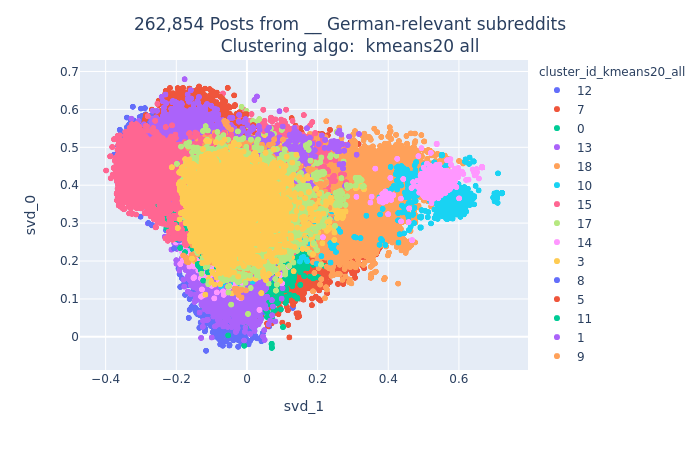

,cluster_id_kmeans20_all-count,cluster_id_kmeans20_all-percent,cluster_id_kmeans20_all-pct_cumulative_sum
13,"29,350",11.2%,11.2%
0,"28,215",10.7%,21.9%
7,"23,958",9.1%,31.0%
12,"23,506",8.9%,40.0%
15,"21,761",8.3%,48.2%
17,"16,761",6.4%,54.6%
5,"14,681",5.6%,60.2%
16,"11,171",4.2%,64.4%
18,"10,612",4.0%,68.5%
2,"10,509",4.0%,72.5%


CPU times: user 2.31 s, sys: 50.2 ms, total: 2.36 s
Wall time: 4.89 s


In [587]:
%%time

df_plot_ = df_all_meta_plot

for c_name in d_cluster_name_and_labels_all.keys():   
    fig = px.scatter(
        df_plot_,
        y='svd_0', x='svd_1',
        color=c_name,
    )

    fig.update_layout(
        title_text=(
            f"{len(df_plot_):,.0f} Posts from __ German-relevant subreddits"
            f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
            # f"<br>Using posts from 04-01-2021 to 05-08-2021"
        ),
        title_x=0.5,
        width=900,
        height=700,
    #     uniformtext_minsize=8, uniformtext_mode='hide'
    )

    # fig.show()
    fig.show(renderer='png')
    display(value_counts_and_pcts(df_plot_[c_name], top_n=10))

### Subreddit groups, based on k-means on posts AND subs

If we clustering at the post-level, could we get meaningful clusters at the subreddit-level?

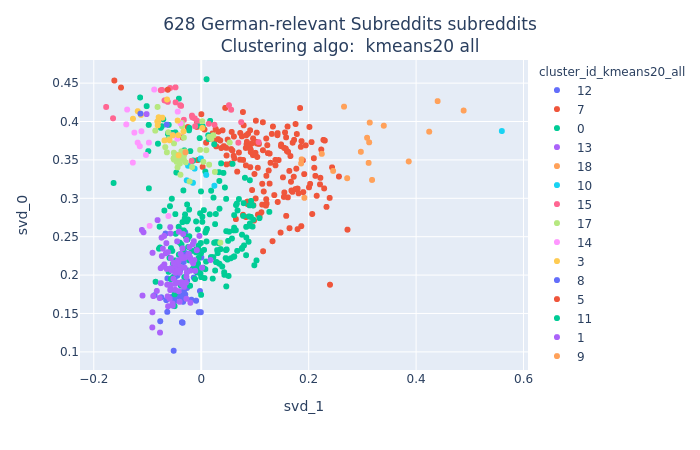

,cluster_id_kmeans20_all-count,cluster_id_kmeans20_all-percent,cluster_id_kmeans20_all-pct_cumulative_sum
0,192,30.6%,30.6%
7,162,25.8%,56.4%
13,94,15.0%,71.3%
12,45,7.2%,78.5%
17,41,6.5%,85.0%
15,23,3.7%,88.7%
18,18,2.9%,91.6%
3,17,2.7%,94.3%
14,16,2.5%,96.8%
10,7,1.1%,97.9%


CPU times: user 134 ms, sys: 7.32 ms, total: 141 ms
Wall time: 376 ms


In [601]:
%%time

df_plot_ = df_all_meta_plot[df_all_meta_plot['post_id'].isnull()]

for c_name in d_cluster_name_and_labels_all.keys():   
    fig = px.scatter(
        df_plot_,
        y='svd_0', x='svd_1',
        color=c_name,
    )

    fig.update_layout(
        title_text=(
            f"{len(df_plot_):,.0f} German-relevant Subreddits subreddits"
            f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
            # f"<br>Using posts from 04-01-2021 to 05-08-2021"
        ),
        title_x=0.5,
        width=900,
        height=700,
    #     uniformtext_minsize=8, uniformtext_mode='hide'
    )

    # fig.show()
    fig.show(renderer='png')
    display(value_counts_and_pcts(df_plot_[c_name], top_n=10))

In [551]:
cols_to_front = [
    'subreddit_name',
    
    'manual_topic_and_rating',
    
    'subreddit_title',
    'subreddit_public_description',
    'post_median_word_count',
    'subreddit_name_title_and_clean_descriptions_word_count',
    
]
cols_to_exclude = [
    'subreddit_description',
    'subreddit_name_title_and_clean_descriptions',
    
]

In [603]:
# df_all_meta_plot.head()

In [623]:
# col_clustering = 'cluster_id_kmeans20_all'
# df_plot_ = df_all_meta_plot[df_all_meta_plot['post_id'].isnull()]

# for id_ in sorted(df_plot_[col_clustering].unique()):
#     mask_ = df_plot_[col_clustering] == id_
#     print(f"\nCluster ID: {id_}\n  {mask_.sum()} Subreddit count in group")
    
#     cols_to_display = reorder_array(
#         cols_to_front,
#         df_plot_.drop(cols_to_exclude, axis=1).columns
#     )
#     display(value_counts_and_pcts(df_plot_[mask_][col_manual_labels]))
#     display(
#         style_df_numeric(
#             df_plot_[mask_][cols_to_display]
#             .sort_values(by=['users_l28'], ascending=False)
#             .head(5)
#             ,
#             rename_cols_for_display=True,
#         )
#     )

In [35]:
# %%time

# cluster_posts = hdbscan.HDBSCAN()

# cluster_posts.fit(df_v_posts[l_cols_embeddings])

In [37]:
# set(cluster_posts.labels_)

# Upload model results to GCS

Primary file to use to create tables:

`df_subs_only-multiple_clustering_algos-628_by_58.parquet`
- This has the column for the best-looking cluster algo so far: `cluster_id_agg_ward_cosine_35`
- Also contains 1st 3 SVD dimensions

`df_subs_meta_and_svd-628_by_93.parquet`
- All meta AND all 50 SVD dimensions

`df_posts_meta_and_svd-262226_by_72.parquet`
- All post meta AND 50 SVD dimensions (no cluster labels)

---
Nevermind:
Split into post-level df and subreddit-level files...?
- `df_svd_posts_and_subs-262854_by_50.parquet`
<br> This file has SVD matrix for all posts AND subreddits...
Would it make sense to create a new column to flag which things are posts & which are comments?


In [ ]:
BREAK

In [70]:
# this manual path is for the run that had the best results.
path_manual_model = Path(
    '/home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_2021-07-20_15_13'
)
path_manual_model

PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_2021-07-20_15_13')

### Check files to upload

In [71]:
[f.name for f in path_manual_model.glob('*') if f.is_file()]

['df_subs_only-multiple_clustering_algos-628_by_54.parquet',
 'df_subs_only-multiple_clustering_algos-628_by_53.parquet',
 'df_subs_meta_and_svd-628_by_93.parquet',
 'df_svd_posts_and_subs-262854_by_50.parquet',
 'df_posts_and_subs-k_means_clustering-262854_by_48.parquet',
 'df_posts_meta_and_svd-262226_by_72.parquet',
 'df_subs_only-multiple_clustering_algos-628_by_58.parquet',
 'df_subs_only-multiple_clustering_algos-628_by_95.parquet']

In [72]:
# for f in [f for f in path_manual_model.glob('*') if f.is_file()]:
#     print(f.name)
#     if f.name == 'df_svd_posts_and_subs-262854_by_50.parquet':
#         df_svd_all = pd.read_parquet(f)
# #         df_vect_svd = pd.read_parquet(f)
#     else:
#         pass

In [73]:
for f in [f for f in path_manual_model.glob('*') if f.is_file()]:
    print(f.name)
    
    df_ = pd.read_parquet(f)
    display(df_.iloc[:5, :10])
#     display(df_.head())

df_subs_only-multiple_clustering_algos-628_by_54.parquet


,subreddit_name,subreddit_id,cluster_id_kmeans20_all,cluster_id_agg_cluster_ward_25,cluster_id_kmeans8,cluster_id_kmeans15,cluster_id_kmeans20,cluster_id_hdbscan_cosine,cluster_id_hdbscan_euclidean,cluster_id_hdbscan_cosine_soft
0,1fcnuernberg,t5_30jst,12,2,5,5,0,0,4,0
1,3thedward,t5_2eeymn,7,19,6,2,18,-1,3,12
2,600euro,t5_3caax,0,23,2,13,18,-1,3,12
3,aachen,t5_2t4y2,13,12,1,0,2,5,3,8
4,aeiou,t5_2qmr6,0,19,6,2,18,11,3,11


df_subs_only-multiple_clustering_algos-628_by_53.parquet


,subreddit_name,subreddit_id,cluster_id_kmeans20_all,cluster_id_kmeans8,cluster_id_kmeans15,cluster_id_kmeans20,cluster_id_hdbscan_cosine,cluster_id_hdbscan_euclidean,cluster_id_hdbscan_cosine_soft,svd_0
0,1fcnuernberg,t5_30jst,12,5,5,0,0,4,0,0.222840
1,3thedward,t5_2eeymn,7,6,2,18,-1,3,12,0.255387
2,600euro,t5_3caax,0,2,13,18,-1,3,12,0.233825
3,aachen,t5_2t4y2,13,1,0,2,5,3,8,0.219124
4,aeiou,t5_2qmr6,0,6,2,18,11,3,11,0.276386


df_subs_meta_and_svd-628_by_93.parquet


,subreddit_id,subreddit_name,geo_country_code,pct_sv_country,rank_no,subreddit_info_ambassador,subreddit_topic_ambassador,combined_topic,combined_topic_and_rating,rating
0,t5_30jst,1fcnuernberg,DE,0.851266,659.0,None,None,uncategorized,uncategorized,None
1,t5_2eeymn,3thedward,DE,0.909091,984.0,None,None,uncategorized,uncategorized,None
2,t5_3caax,600euro,DE,0.926953,15.0,None,None,internet culture and memes,internet culture and memes,r
3,t5_2t4y2,aachen,DE,0.839318,210.0,None,None,uncategorized,uncategorized,pg
4,t5_2qmr6,aeiou,AT,0.856129,5.0,None,None,internet culture and memes,internet culture and memes,pg


df_svd_posts_and_subs-262854_by_50.parquet


,,,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9
subreddit_name,subreddit_id,post_id,,,,,,,,,,
1fcnuernberg,t5_30jst,NaN,0.222840,0.000204,0.024081,0.063317,-0.132110,-0.055637,0.040146,-0.046460,-0.052776,-0.008773
3thedward,t5_2eeymn,NaN,0.255387,0.147757,0.032305,-0.061291,-0.118992,-0.000174,-0.009139,-0.058684,0.043216,0.009949
600euro,t5_3caax,NaN,0.233825,0.036164,-0.006401,0.014257,-0.148316,0.001211,0.042717,0.000280,-0.027061,0.000389
aachen,t5_2t4y2,NaN,0.219124,-0.043050,-0.050471,0.158570,-0.120792,-0.057563,-0.022799,0.029657,0.046299,0.026831
aeiou,t5_2qmr6,NaN,0.276386,0.088939,0.015256,-0.029987,-0.155789,0.010343,0.001697,-0.013627,-0.002120,0.028648


df_posts_and_subs-k_means_clustering-262854_by_48.parquet


,subreddit_name,subreddit_id,post_id,cluster_id_kmeans20_all,svd_0,svd_1,svd_2,geo_country_code,pct_sv_country,rank_no
0,1fcnuernberg,t5_30jst,None,12,0.222840,0.000204,0.024081,DE,0.851266,659.0
1,3thedward,t5_2eeymn,None,7,0.255387,0.147757,0.032305,DE,0.909091,984.0
2,600euro,t5_3caax,None,0,0.233825,0.036164,-0.006401,DE,0.926953,15.0
3,aachen,t5_2t4y2,None,13,0.219124,-0.043050,-0.050471,DE,0.839318,210.0
4,aeiou,t5_2qmr6,None,0,0.276386,0.088939,0.015256,AT,0.856129,5.0


df_posts_meta_and_svd-262226_by_72.parquet


,subreddit_name,subreddit_id,post_id,submit_date,upvotes,combined_topic_and_rating,post_type,post_nsfw,geolocation_country_code,post_url
0,1fcnuernberg,t5_30jst,t3_mjwbjc,2021-04-04,18,uncategorized,text,False,de,/r/1FCNuernberg/comments/mjwbjc/1_fc_nürnberg_sc_paderborn_07_21_11/
1,1fcnuernberg,t5_30jst,t3_mjwik7,2021-04-04,47,uncategorized,image,False,de,https://i.redd.it/ng48176vu5r61.png
2,1fcnuernberg,t5_30jst,t3_mm8azo,2021-04-07,28,uncategorized,image,False,de,https://i.redd.it/0xr02x7ulsr61.jpg
3,1fcnuernberg,t5_30jst,t3_moqu14,2021-04-11,9,uncategorized,text,False,de,/r/1FCNuernberg/comments/moqu14/fc_würzburger_kickers_1_fc_nürnberg_11_01/
4,1fcnuernberg,t5_30jst,t3_mpibr7,2021-04-12,4,uncategorized,link,False,de,https://www.fcn.de/index.php?id=19217&tx_ttnews%5Btt_news%5D=33136&cHash=0602ee17c1f5efadbed49bf5150514c8


df_subs_only-multiple_clustering_algos-628_by_58.parquet


,subreddit_name,subreddit_id,cluster_id_kmeans20_all,cluster_id_agg_ward_25,cluster_id_agg_ward_35,cluster_id_agg_ward_cosine_35,cluster_id_agg_avg_cosine_35,cluster_id_agg_complete_cosine_35,cluster_id_kmeans8,cluster_id_kmeans15
0,1fcnuernberg,t5_30jst,12,2,26,18,11,25,5,5
1,3thedward,t5_2eeymn,7,19,19,32,1,11,6,2
2,600euro,t5_3caax,0,23,11,10,1,4,2,13
3,aachen,t5_2t4y2,13,12,25,6,0,22,1,0
4,aeiou,t5_2qmr6,0,19,19,32,1,11,6,2


df_subs_only-multiple_clustering_algos-628_by_95.parquet


,subreddit_name,subreddit_id,cluster_id_kmeans20_all,geo_country_code_x,pct_sv_country_x,rank_no_x,subreddit_info_ambassador_x,subreddit_topic_ambassador_x,combined_topic_x,combined_topic_and_rating_x
0,1fcnuernberg,t5_30jst,12,DE,0.851266,659.0,None,None,uncategorized,uncategorized
1,3thedward,t5_2eeymn,7,DE,0.909091,984.0,None,None,uncategorized,uncategorized
2,600euro,t5_3caax,0,DE,0.926953,15.0,None,None,internet culture and memes,internet culture and memes
3,aachen,t5_2t4y2,13,DE,0.839318,210.0,None,None,uncategorized,uncategorized
4,aeiou,t5_2qmr6,0,AT,0.856129,5.0,None,None,internet culture and memes,internet culture and memes


### Upload files

In [75]:
path_this_model_prev_run

PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_2021-07-20_15_13')

In [76]:
bucket_upload_dir = f'gs://i18n-subreddit-clustering/data/models/clustering/{path_this_model_prev_run.name}'
bucket_upload_dir

'gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-07-20_15_13'

In [77]:
!echo $path_this_model_prev_run $bucket_upload_dir

/home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_2021-07-20_15_13 gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-07-20_15_13


In [78]:
!gsutil -m cp -r $path_this_model_prev_run $bucket_upload_dir

Copying file:///home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_2021-07-20_15_13/df_subs_only-multiple_clustering_algos-628_by_54.parquet [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_2021-07-20_15_13/df_subs_only-multiple_clustering_algos-628_by_53.parquet [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_2021-07-20_15_13/df_subs_meta_and_svd-628_by_93.parquet [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_2021-07-20_15_13/df_svd_posts_and_subs-262854_by_50.parquet [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_2021-07-20_15_13/df_posts_and_subs-k_means_clustering-262854_by_48.parquet [Content-Type=application/octet-stream]...
Copying file:///home/